# Proximal Policy Optimization
## Jared Nielsen
Link to [arXiv paper](https://arxiv.org/pdf/1707.06347.pdf)  

Here we apply PPO to CartPole and Space Invaders RAM.

In [18]:
import functools
from itertools import chain
import gym
import imageio
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
from queue import Queue
import time
import sys
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
gym.logger.set_level(40)

In [17]:
!{sys.executable} -m pip install JSAnimation

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /home/jared/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


## Network Topology, Datasets

In [2]:
# Policy Network
# Chooses the next move.
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim=4, action_dim=2):
        super().__init__()
        self._net = nn.Sequential(
            nn.Linear(state_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, action_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x, get_action=True):
        """
        Receives input x of shape [batch, state_dim].
        Outputs action distribution (categorical distribution) of shape [batch, action_dim],
        as well as a sampled action (optional).
        """
        probs = self._net(x)
        
        if not get_action:
            return probs

        # Possibly return a sampled action
        # This code is taken from Josh's code, but written myself :)
        batch_size = x.shape[0]
        actions = np.empty((batch_size, 1), dtype=np.uint8) # easiest to modify in-place
        probs_np = probs.cpu().detach().numpy() # numpy functions can only run on cpu
        for i in range(batch_size):
            action_one_hot = np.random.multinomial(1, probs_np[i]) # 1 draw from the given probs
            action_idx = np.argmax(action_one_hot) # get the index of the 1 in the one-hot vector
            actions[i, 0] = action_idx # create the vector of action indices
        return probs, actions

# Value Network
# Estimates the value of a state.
class ValueNetwork(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        
    def forward(self, x):
        return self.net(x)
    
class EmbeddingNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self._net = nn.Linear(n_in, n_out)
    
    def forward(self, x):
        return self._net(x)
    

# These datasets sample *observations*, not rollouts.
# Policy dataset returns (prev_state, action, reward, ret) tuples.
class PolicyDataset(Dataset):
    def __init__(self, experience):
        super(PolicyDataset, self).__init__()
        self._exp = []
        for x in experience:
            self._exp.extend(x)
        self._length = len(self._exp)

    def __getitem__(self, index):
        return self._exp[index]

    def __len__(self):
        return self._length

## Calculate Returns, Advantages
## Rollout and Train

In [3]:
def _calculate_returns(rollouts, gamma):
    """
    Modifies `rollouts` in-place from (state, action_dist, action, reward) to 
    (state, action_dist, action, reward, return).
    """
    for i, rollout in enumerate(rollouts):
        current_return = 0
        for j in reversed(range(len(rollout))):
            state, action_dist, action, reward = rollout[j]
            ret = reward + gamma*current_return
            rollouts[i][j] = (state, action_dist, action, reward, ret)
            current_return = ret

def likelihood_fn(action_dist, action):
    return action_dist[range(action_dist.shape[0]), action.long()[:,0]].unsqueeze(1)

def likelihood_fn_bad(action_dist, action):
    """
    Always check your shapes!!!
    This is indexing action_dist using action instead of action[:,0]
    which makes likelihood have shape (256,1,256) instead of (256,1).
    This didn't throw any errors but ruined everything.
    """
    print("action shape: {}".format(action.shape))
    n = action_dist.shape[0]
    likelihood = action_dist[range(n), action].unsqueeze(1)
    print("likelihood shape: {}".format(likelihood.shape))
    return likelihood

def _prepare_numpy(ndarray, device):
    """
    Adds a dimension of length 1, so we don't have to deal with PyTorch converting
    floats to doubles.
    Fx (256,) becomes (256,1).
    """
    return torch.Tensor(ndarray).to(device).unsqueeze(0)

def _prepare_tensor_batch(tensor, device):
    return tensor.detach().float().to(device)

def main(env, embedding, policy, value, device, rewards_queue, n_epochs, n_episodes, max_episode_length):
    # Initialize environment and networks
    policy = policy.to(device)
    value = value.to(device)
    
    # Hyperparameters
    gamma = 0.99
    policy_epochs = 5
    batch_size = 256
    epsilon_ppo = 0.2
    lr = 1e-3
    weight_decay = 0.01
    betas=(0.9, 0.999)
    
    # Optimizers
    params = chain(value.parameters(), policy.parameters())
    if embedding:
        embedding = embedding.to(device)
        params = chain(params, embedding.parameters())
    optimizer = optim.Adam(params, lr=lr, betas=betas, weight_decay=weight_decay)
    value_criteria = nn.MSELoss()
    
    
    loop = tqdm(total=n_epochs, position=0, leave=False)
    
    # Training
    for _ in range(n_epochs):
#         Generate Rollouts
        rollouts = []
        rewards_per_rollout = []
        for _ in range(n_episodes):
            state = env.reset() # Reset environment each episode

            rollout = []
            reward_total = 0
            for _ in range(max_episode_length):
                # Compute policy probabilities
                input_state = _prepare_numpy(state, device)
                if embedding:
                    input_state = embedding(input_state)
                action_dist, action = policy(input_state)
                action_dist, action = action_dist[0], action[0]

                # Take Action
                state_prime, reward, done, _ = env.step(action.item())
#                 position, velocity = state_prime
#                 shaped_reward = min(1, 10*abs(velocity))
#                 reward += shaped_reward
#                 print("shaped_reward: {}".format(shaped_reward))
                # Ensure you store state instead of state_prime
                rollout.append((state.astype(np.float32), action_dist.cpu().detach().numpy(), action, reward))
                reward_total += reward

                if done:
                    break
                    
                state = state_prime

            rollouts.append(rollout)
            rewards_per_rollout.append(reward_total)
            rewards_queue.put(reward_total)
#         End Rollouts
        
#         Prepare Data
        _calculate_returns(rollouts, gamma) # modifies rollouts inplace
        avg_reward = sum(rewards_per_rollout) / len(rewards_per_rollout)
        
        
        experience_dataset = PolicyDataset(rollouts)
        data_loader = DataLoader(experience_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
        # End Prepare Data
        
        # Train
        for _ in range(policy_epochs):
            avg_value_loss = 0
            avg_policy_loss = 0
            for state, action_dist, action, reward, ret in data_loader:
                # state is an (n_timesteps,4) tensor; action/reward/ret are all (n_timestaps,) tensors
                optimizer.zero_grad()
                
                # Convert float64 to float32, detach tensors
                state = _prepare_tensor_batch(state, device)
                action_dist = _prepare_tensor_batch(action_dist, device)
                action = _prepare_tensor_batch(action, device).long()
                reward = _prepare_tensor_batch(reward, device)
                ret = _prepare_tensor_batch(ret, device).unsqueeze(1)

                if embedding:
                    state = embedding(state)
                
                # Calculate the ratio term (this was the weeklong trip-up; faulty fancy indexing)
                current_action_dist = policy(state, get_action=False)
                current_likelihood = likelihood_fn(current_action_dist, action)
                old_likelihood = likelihood_fn(action_dist, action)
                ratio = (current_likelihood / old_likelihood)
                
                # Value Loss
                expected_returns = value(state)
                value_loss = value_criteria(expected_returns, ret)
        
                # Proximal Policy Optimization
                advantage = ret - expected_returns.detach()
                lhs = ratio * advantage
                rhs = torch.clamp(ratio, 1-epsilon_ppo, 1+epsilon_ppo) * advantage
                policy_loss = -1*torch.mean(torch.min(lhs, rhs))
        
                # Policy gradient (for comparison)
#                 likelihood = likelihood_fn(current_action_dist, action)
#                 policy_loss = -1*torch.mean(torch.log(likelihood)*advantage)
                
                # Logging
                avg_value_loss += value_loss.item()
                avg_policy_loss += policy_loss.item()
                
                # Backpropagate
                loss = policy_loss + value_loss
                loss.backward()
                optimizer.step()
              
            avg_value_loss /= len(data_loader)
            avg_policy_loss /= len(data_loader)
         
        ratio_print = ratio.mean().item()
        adv_print = advantage.mean().item()
        ret_print = ret[0].item()
        exp_ret_print = expected_returns.mean().item()
        # debugging print-statements
        if False:
            print(
                "avg reward: {:.3f}, value loss: {:.3f}, policy loss: {:.3f}, ratio: {:.3f}, adv: {:.3f}".format(
                avg_reward, avg_value_loss, avg_policy_loss, ratio_print, adv_print)
            )
        loop.set_description(
            "avg reward: {:.3f}, value loss: {:.3f}, policy loss: {:.3f}".format(
            avg_reward, avg_value_loss, avg_policy_loss))
        loop.update(1)
        print()

# # CartPole environment
# env = gym.make('CartPole-v0')
# n_state_size = 4
# n_action_size = 2 
# max_episode_length = 200

# # MountainCar environment
# env = gym.make('MountainCar-v0') # state is (position, velocity);
# # action is 0-push left, 1-no push, 2-push right
# n_state_size = 2
# n_action_size = 3

# SpaceInvaders-RAM environment
# env = gym.make('SpaceInvaders-ram-v0')
# n_state_size = 128
# n_embedding_size = 32
# n_action_size = 6
# max_episode_length = 500

# n_epochs = 100
# n_episodes = 100
# device = 'cpu'
# embedding = EmbeddingNetwork(n_state_size, n_embedding_size).to(device)
# policy = PolicyNetwork(n_embedding_size, n_action_size).to(device)
# value = ValueNetwork(n_embedding_size).to(device)
# reward_queue_spaceinvaders = Queue()
# main(env, embedding, policy, value, device, reward_queue_spaceinvaders, n_epochs, n_episodes, max_episode_length)
# print("done")


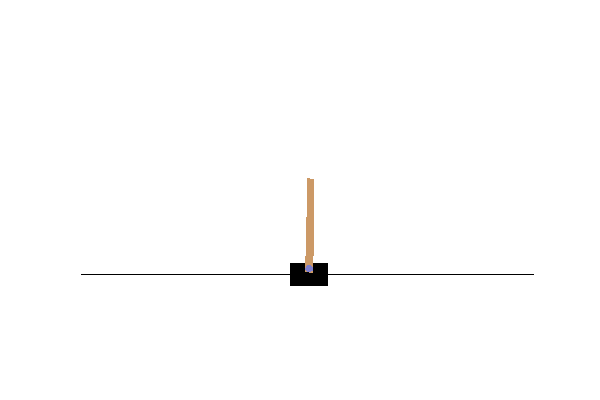
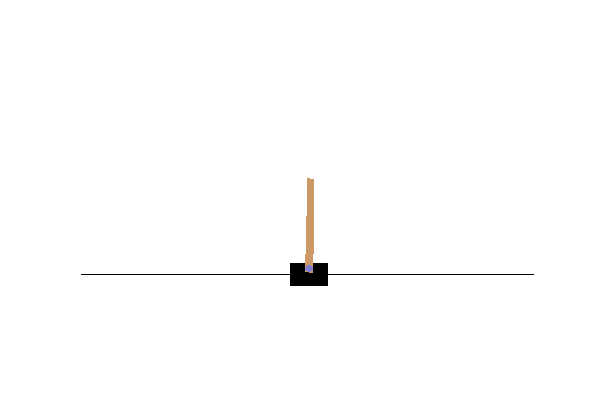
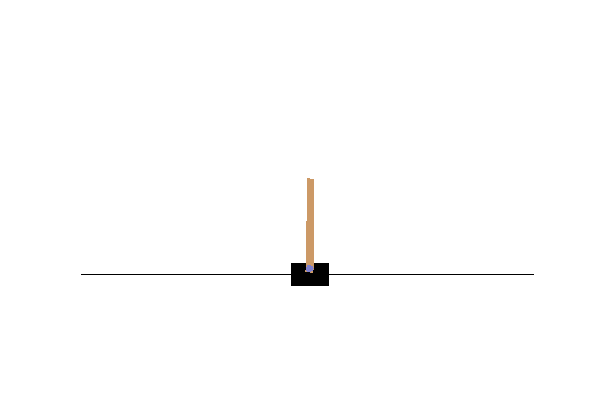
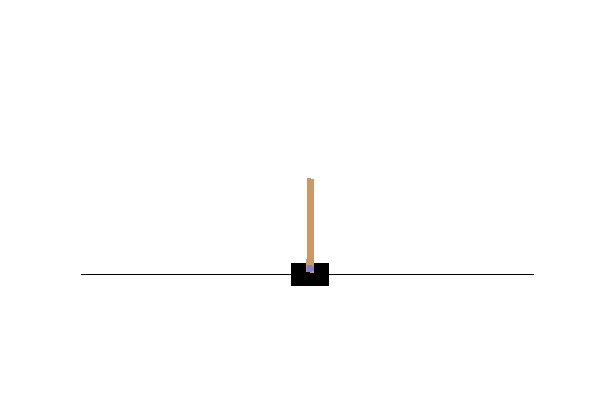
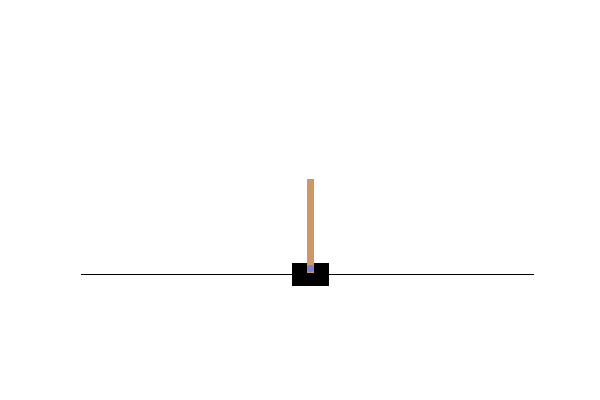
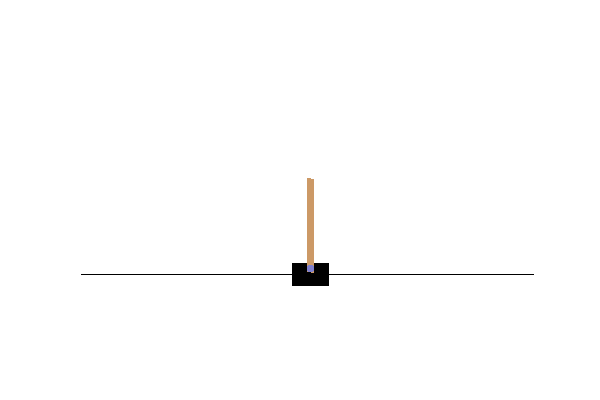
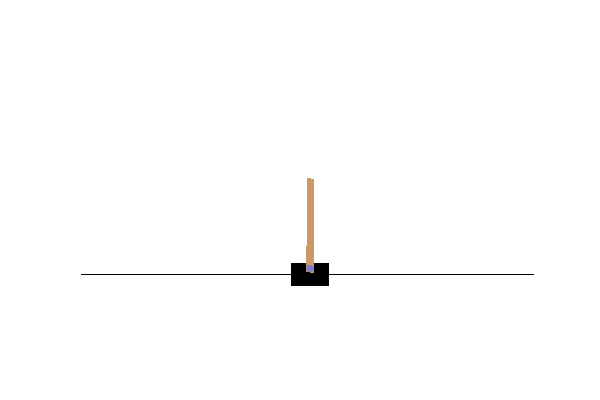
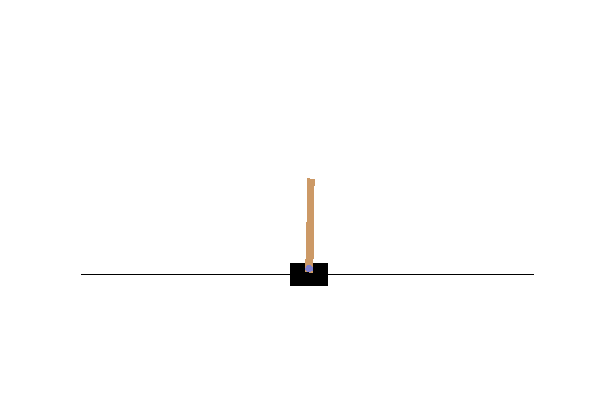
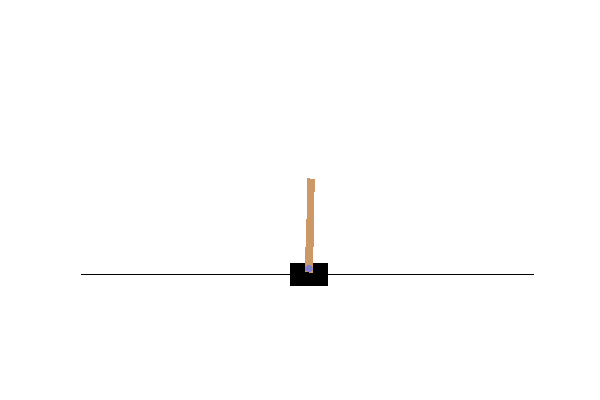
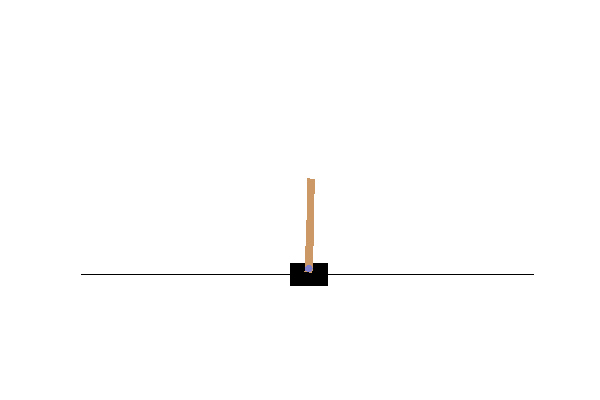
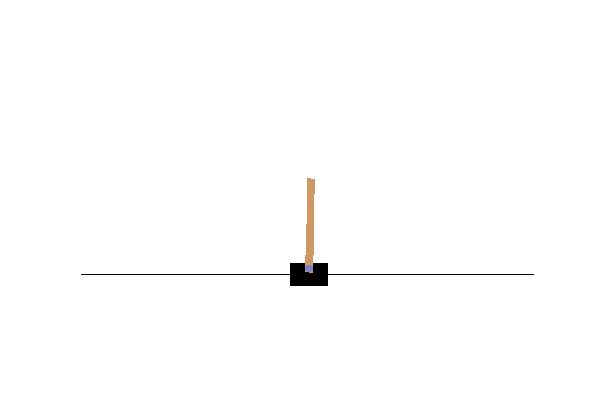
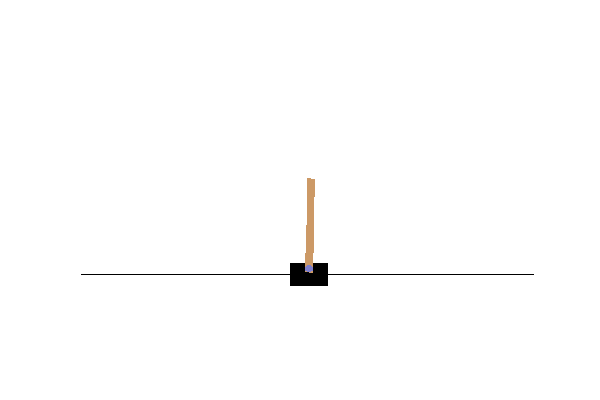
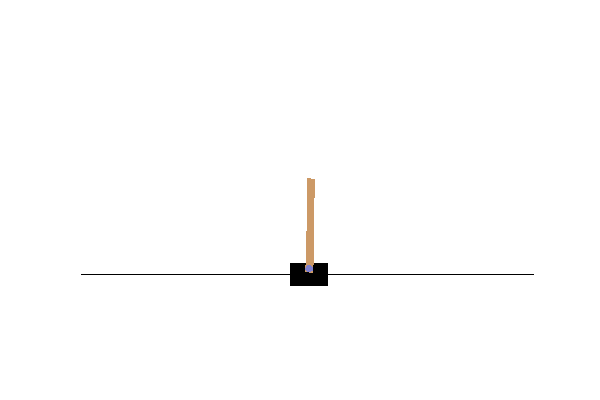
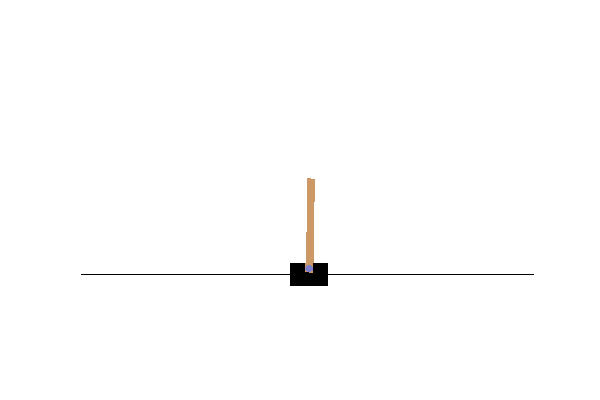
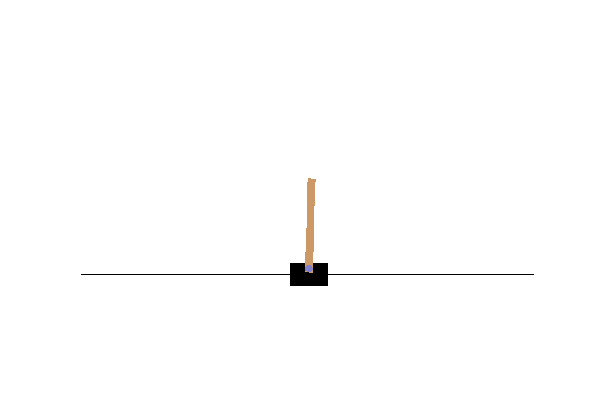
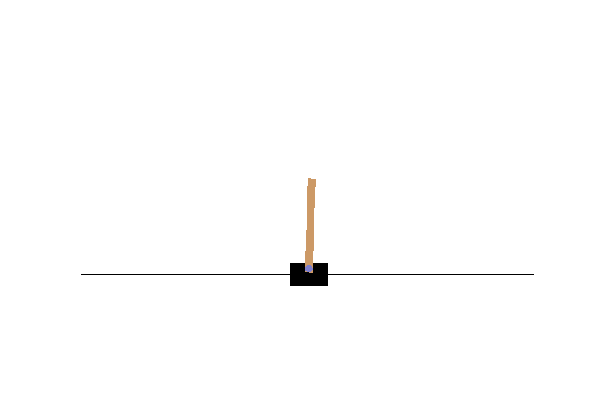
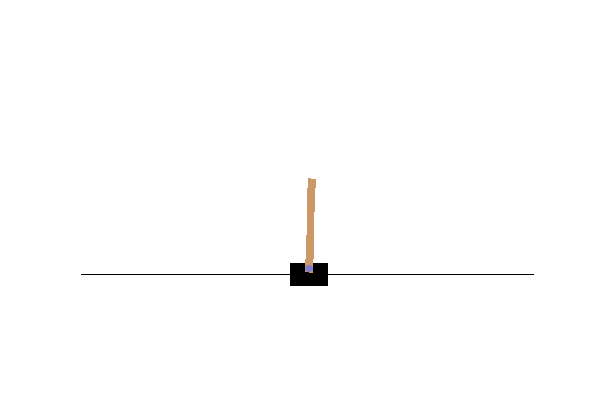
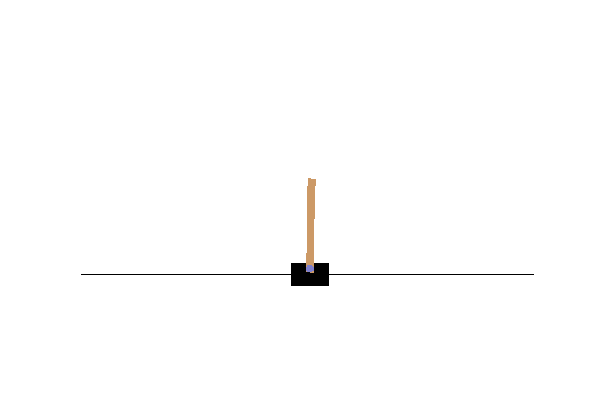
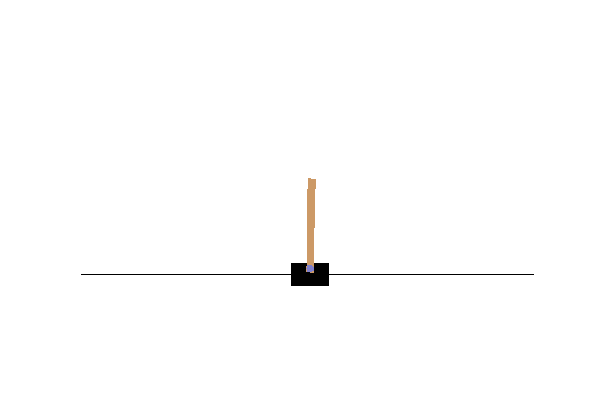
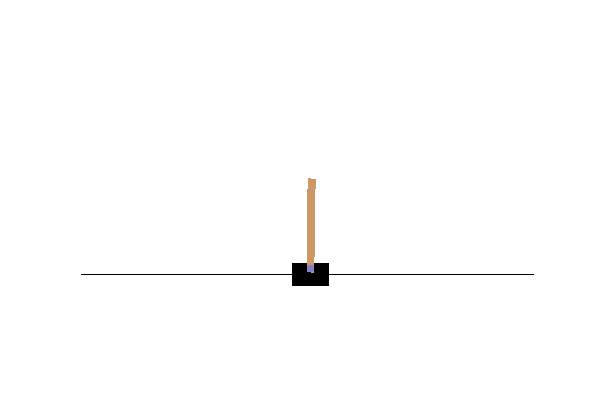
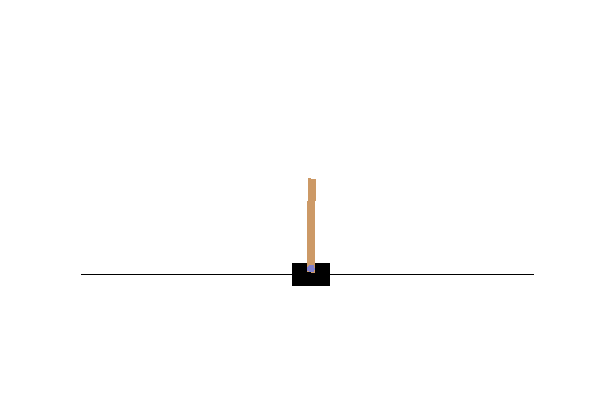
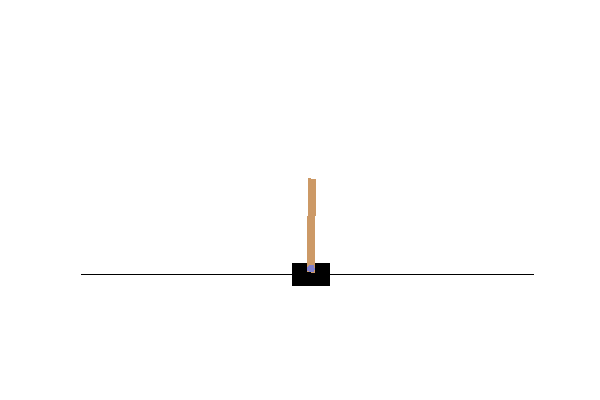
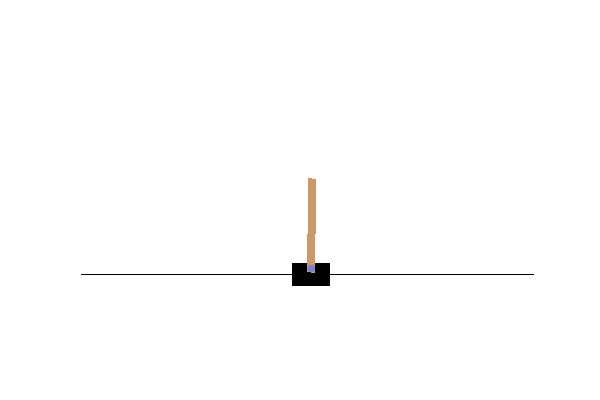
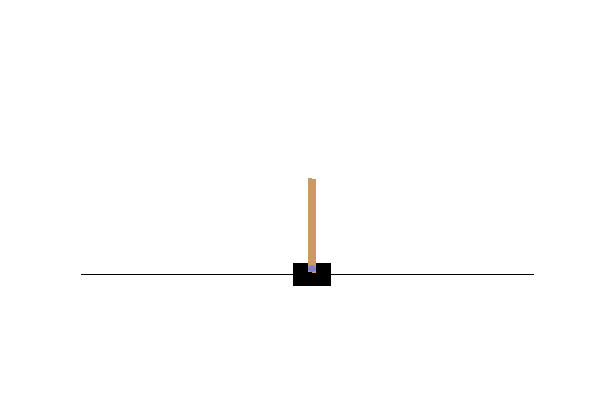
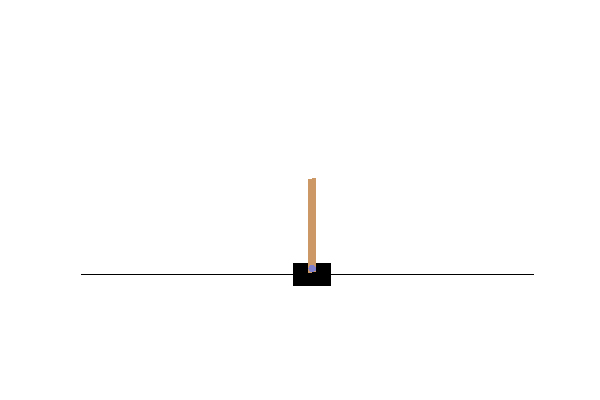
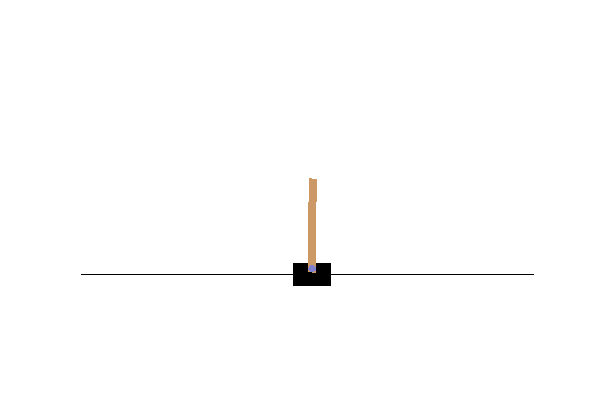
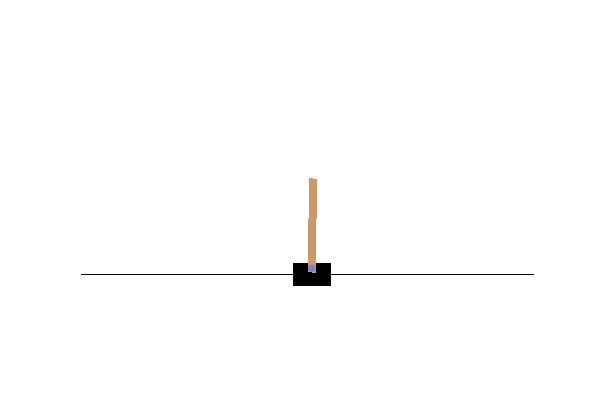
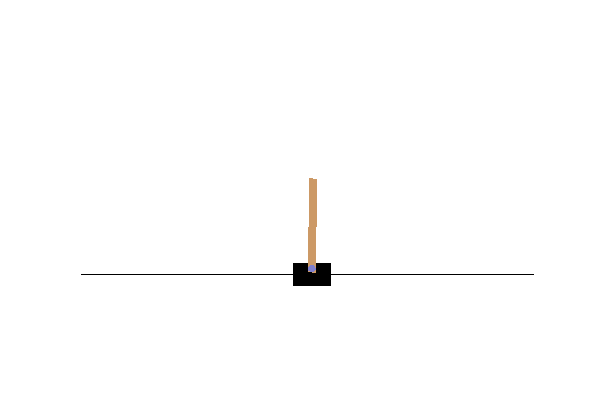
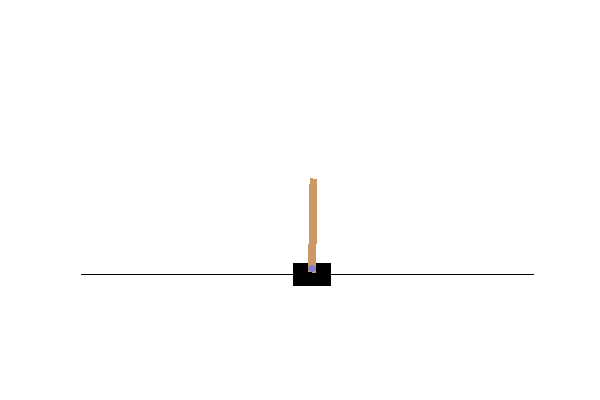
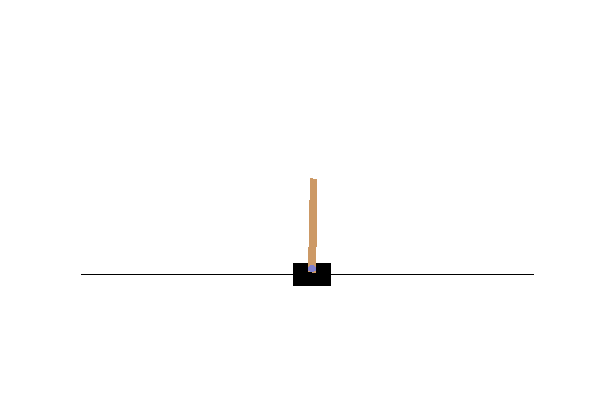
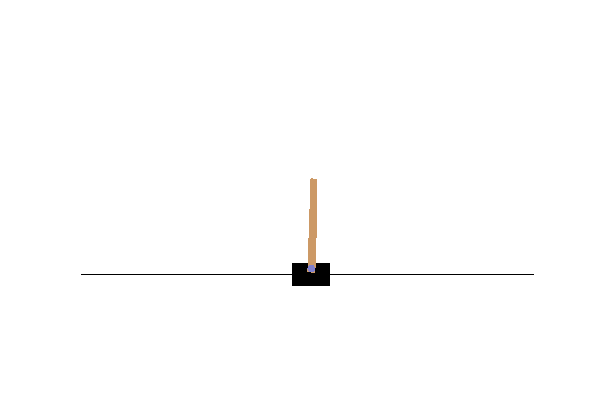
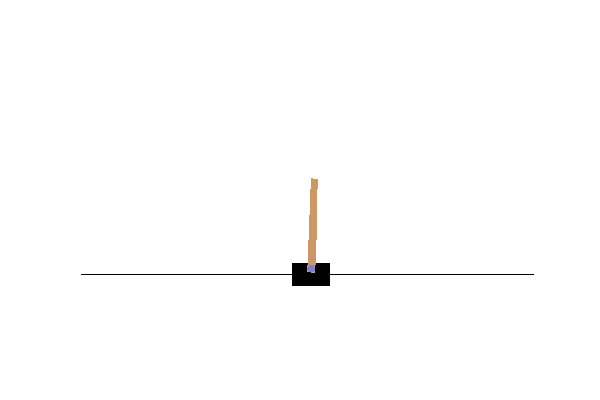
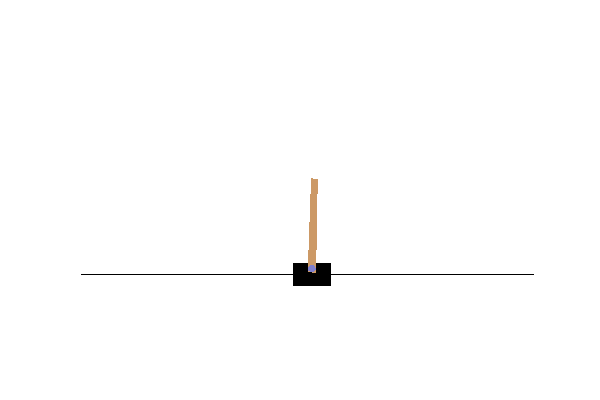
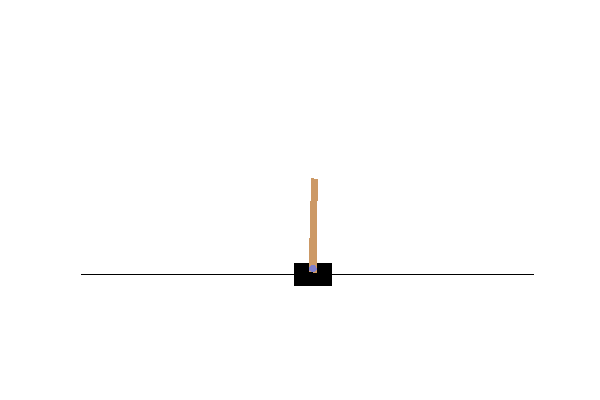
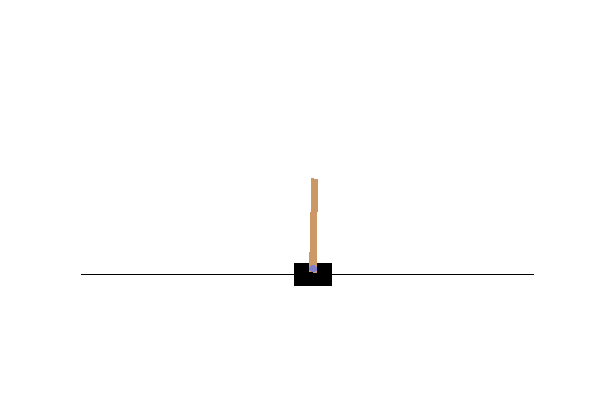
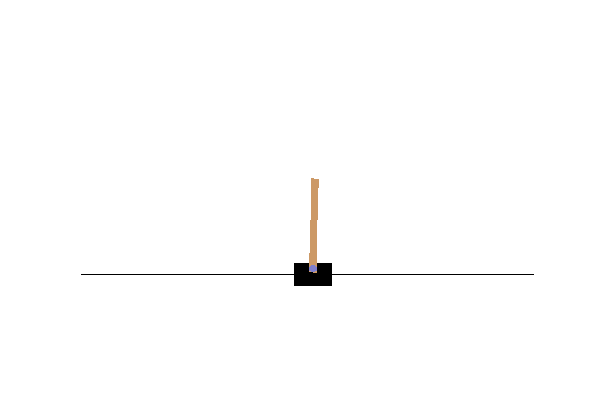
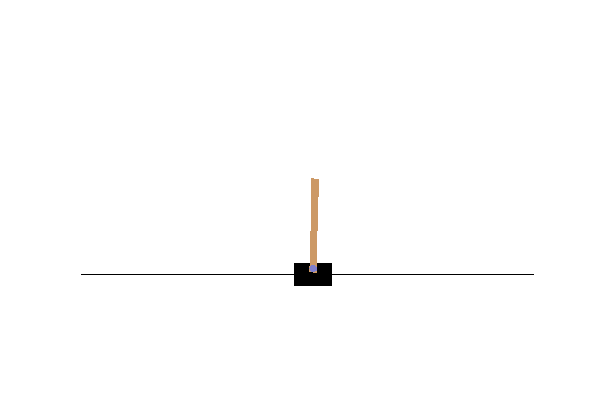
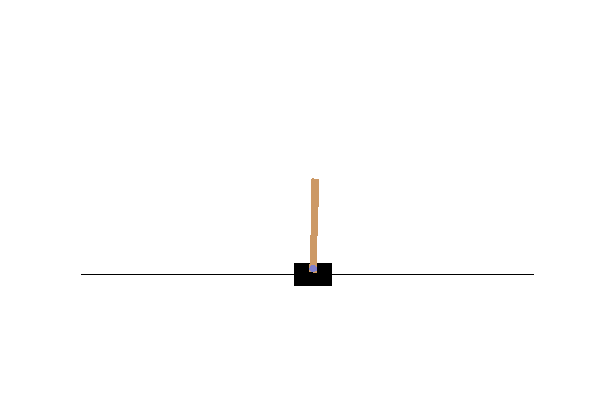
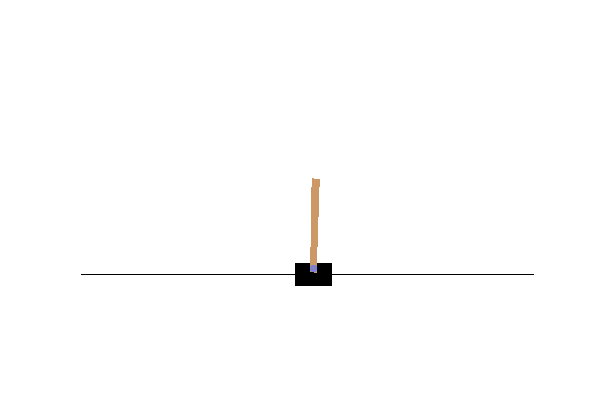
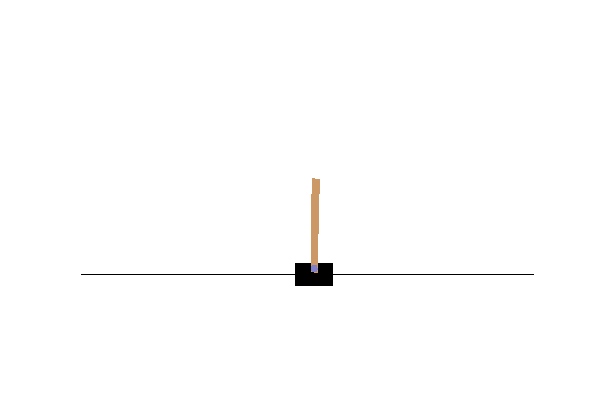
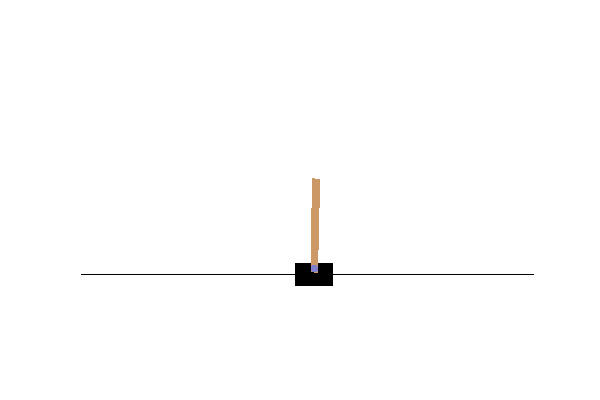
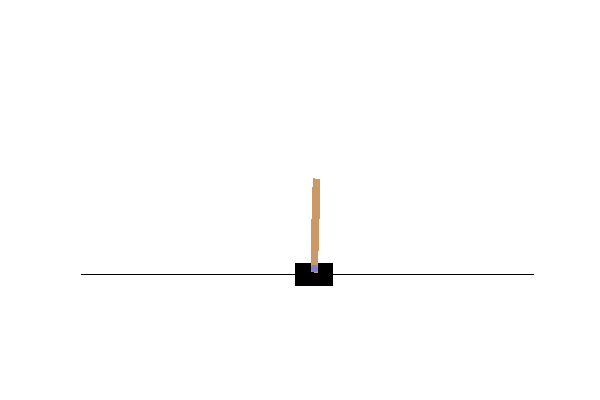
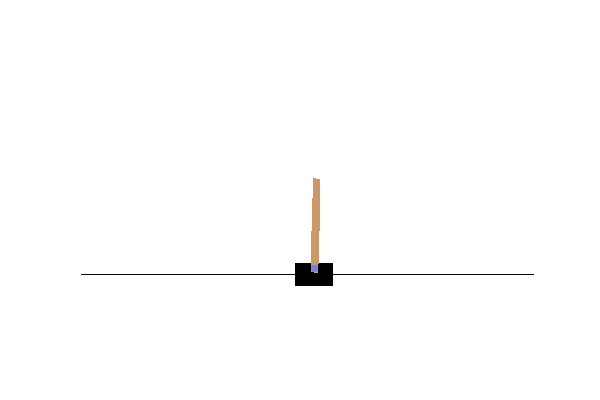
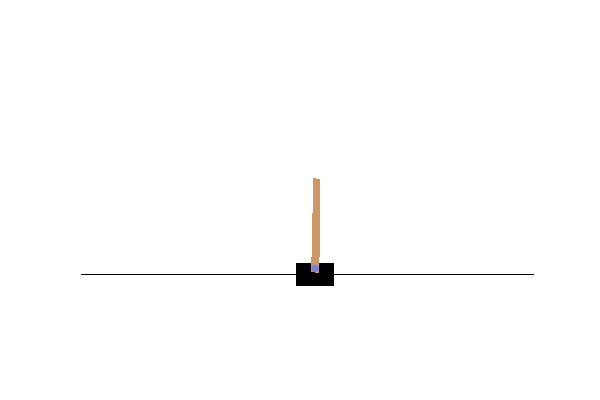
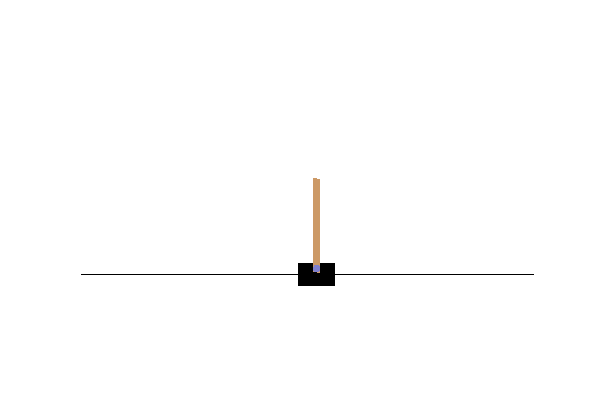
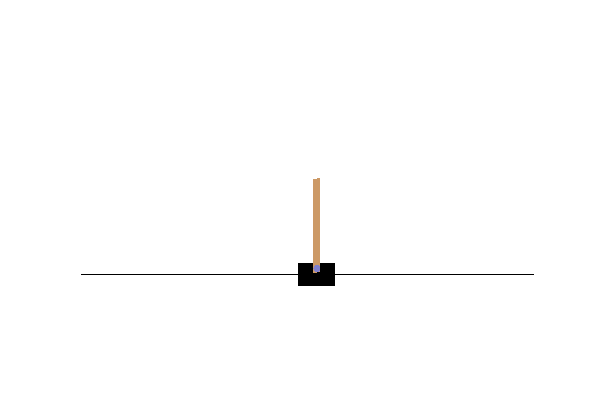
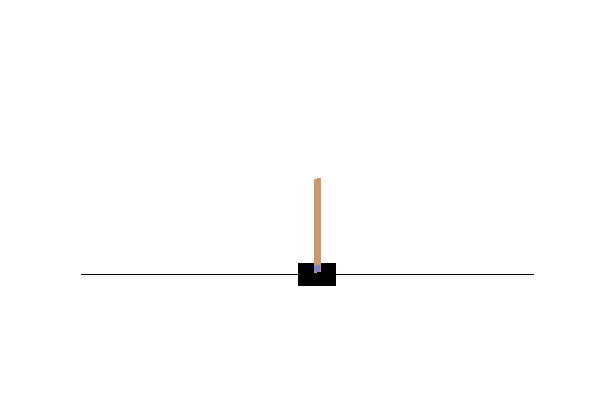
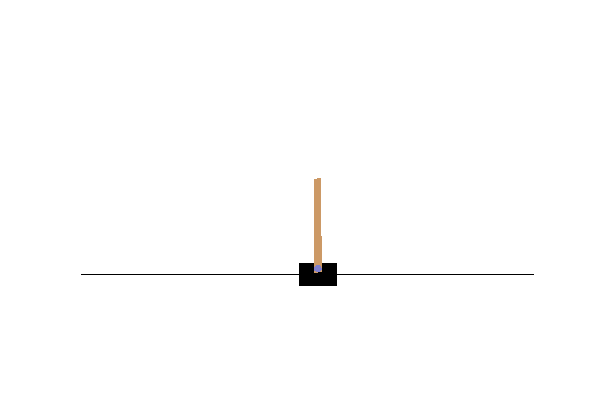
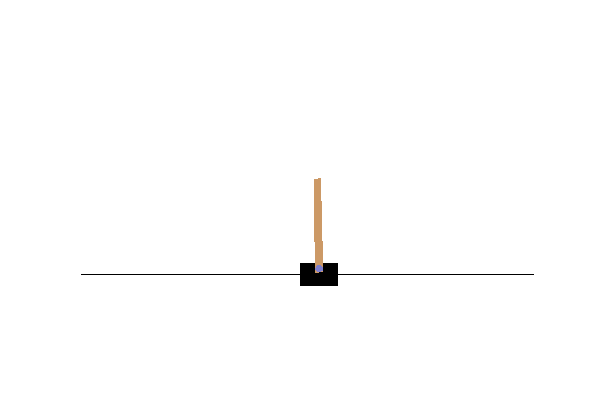
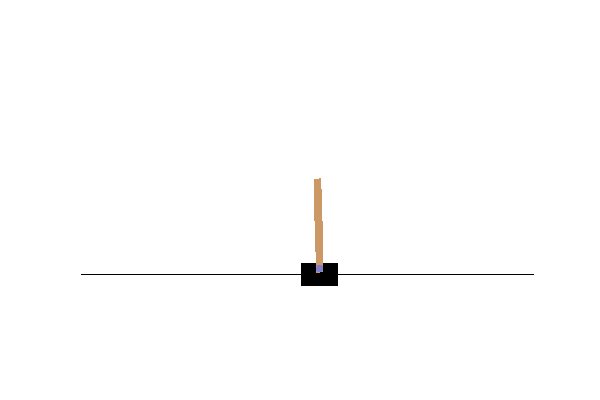
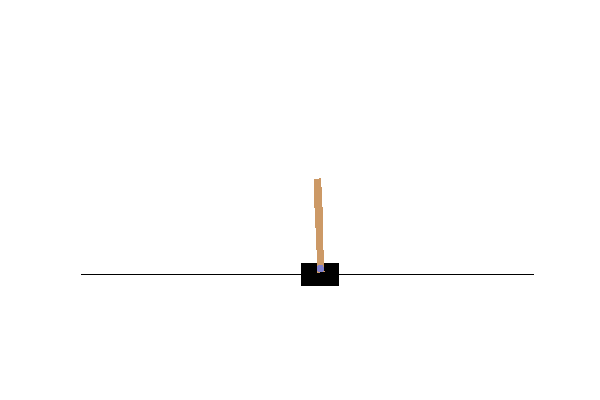
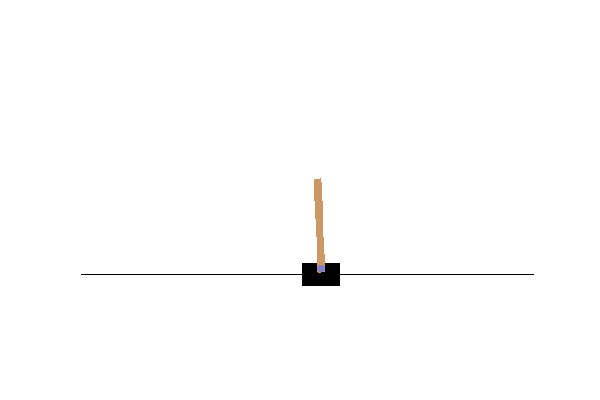
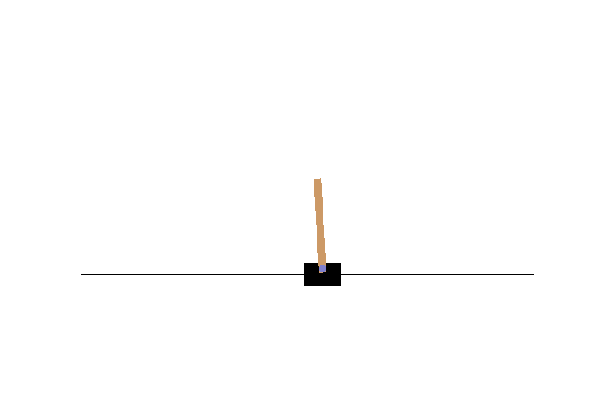
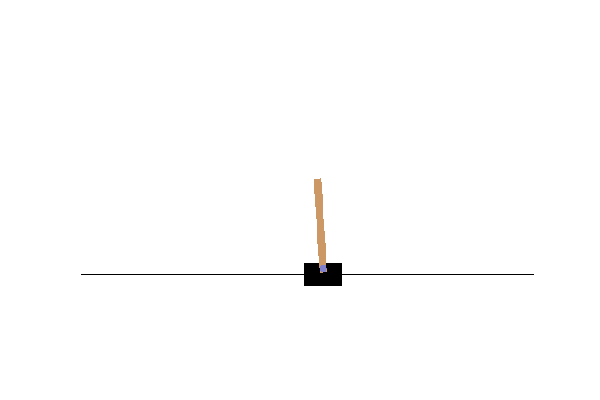
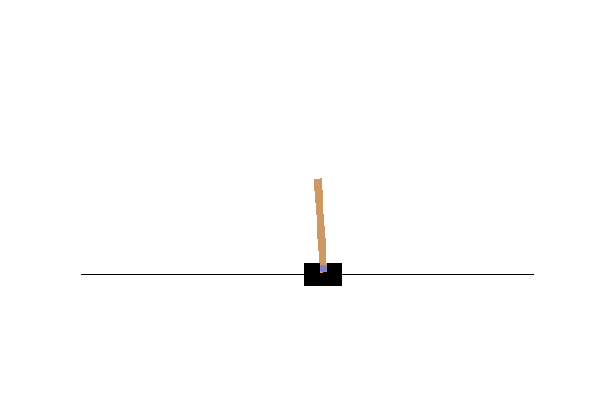
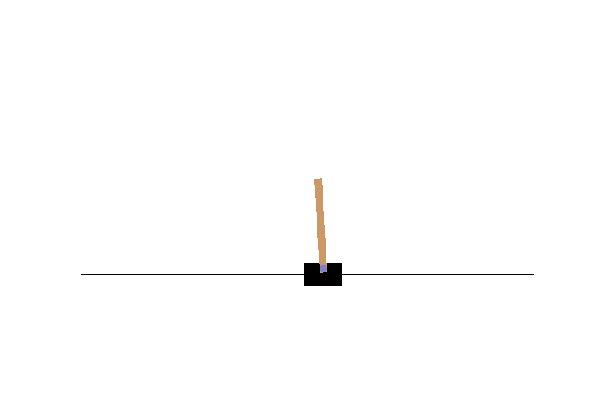
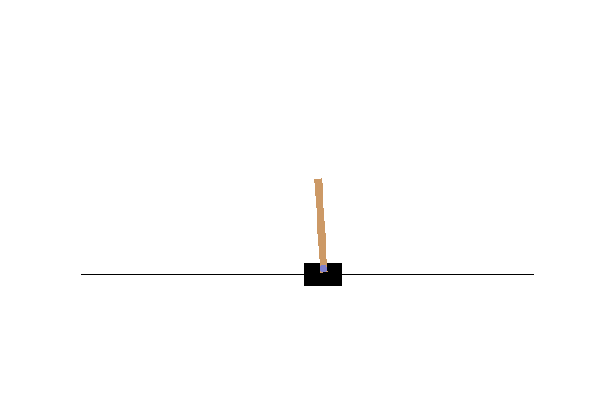
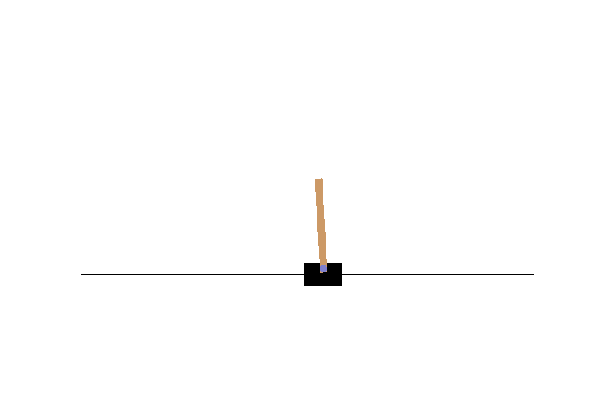
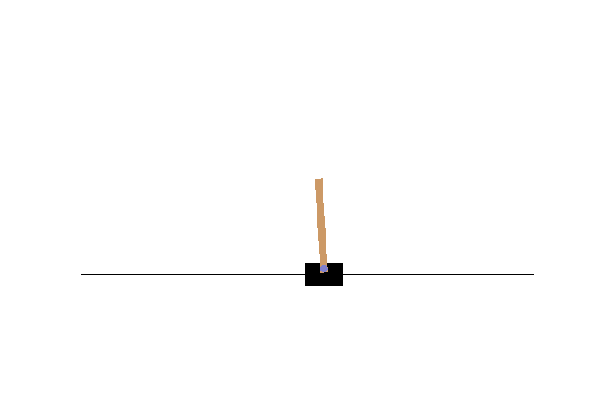
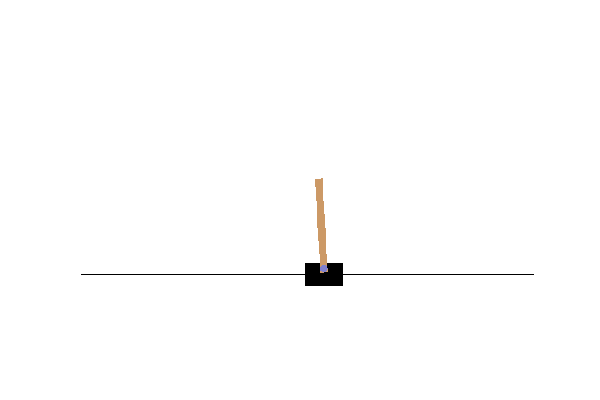
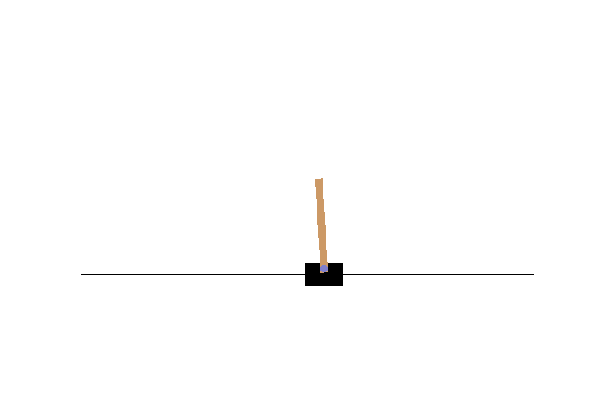
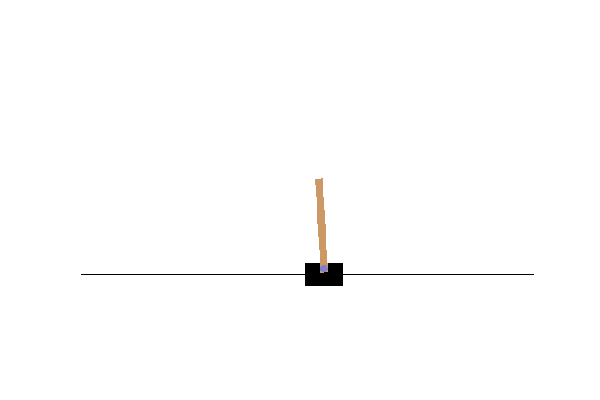
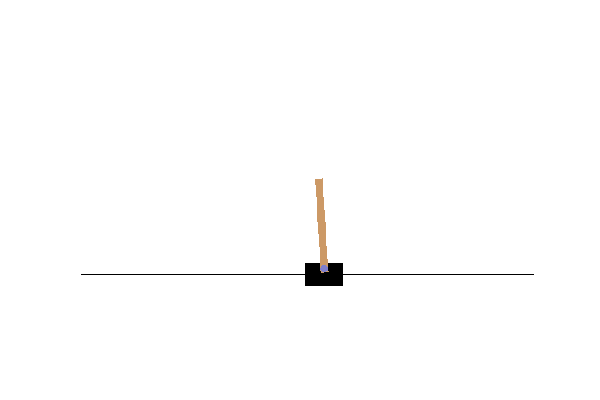
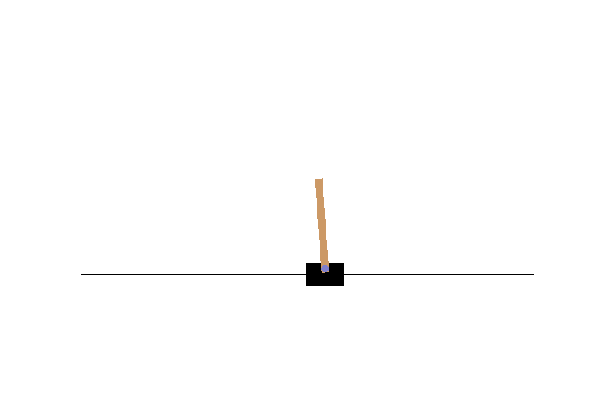
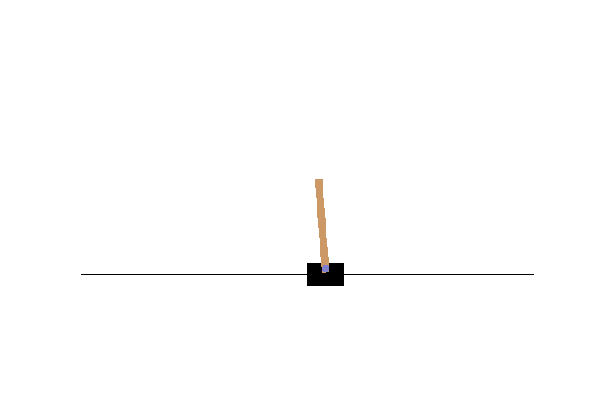
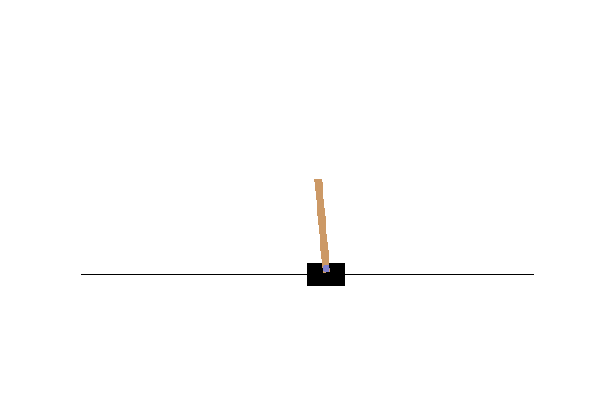
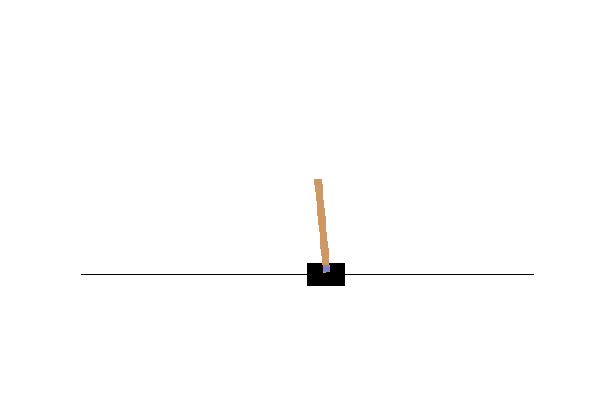
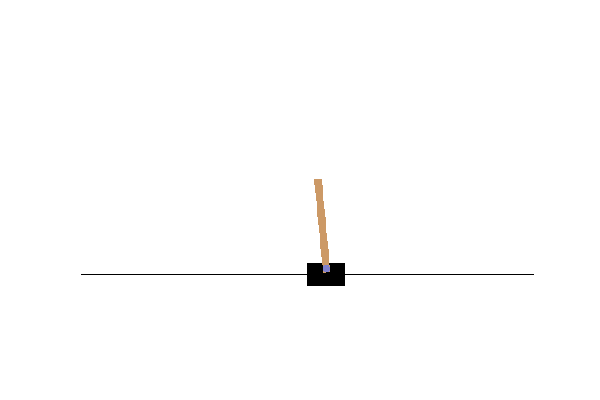
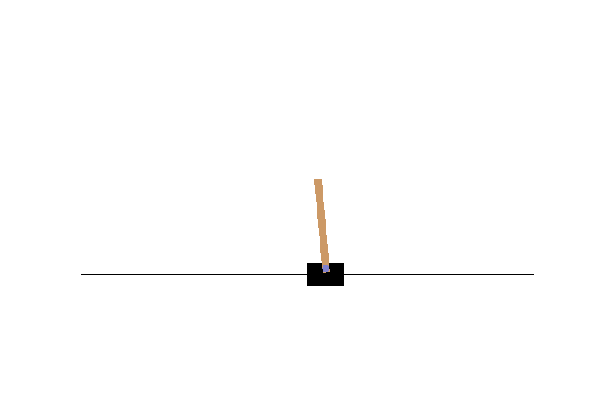
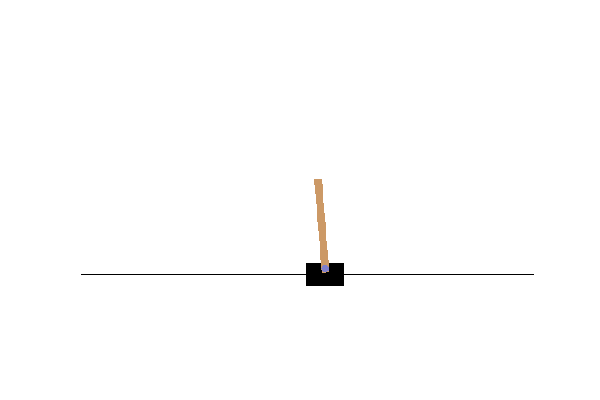
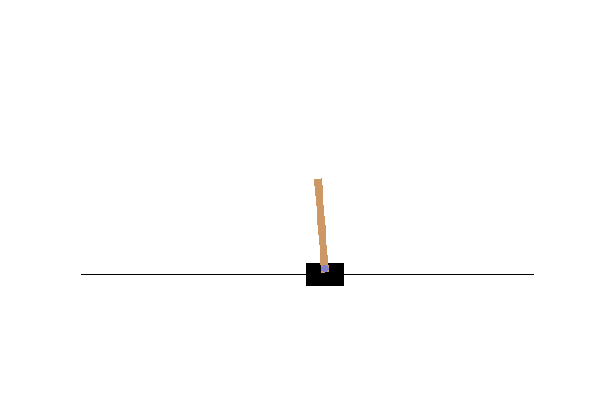
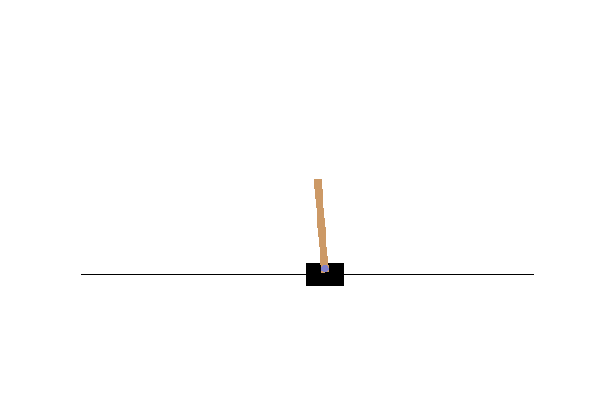
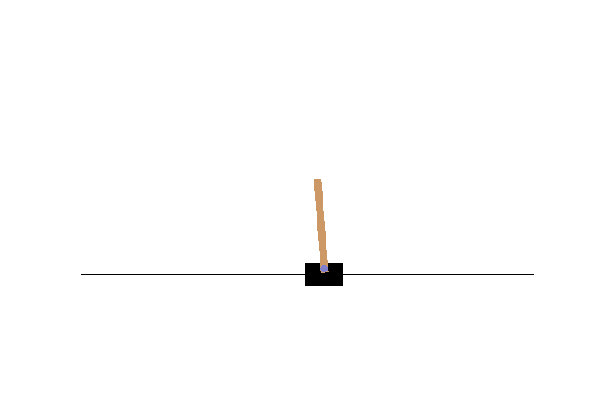
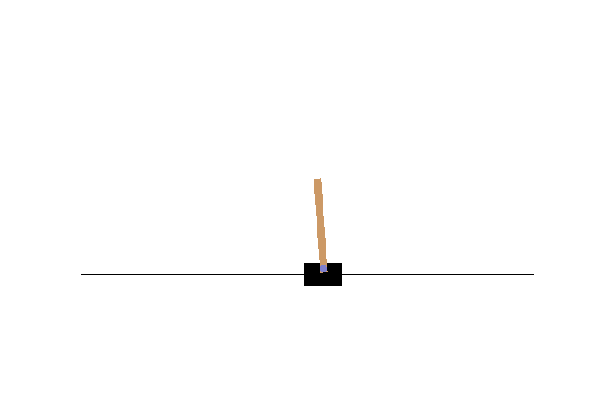
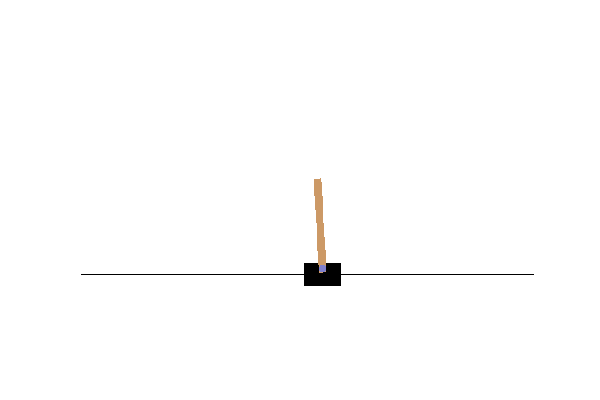
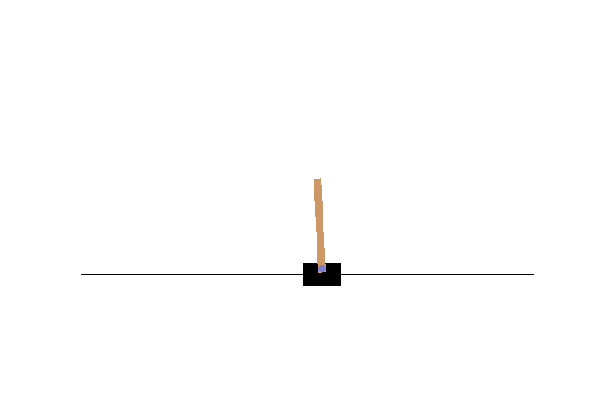
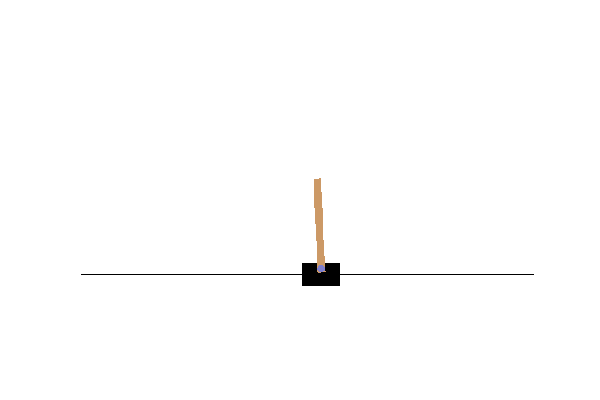
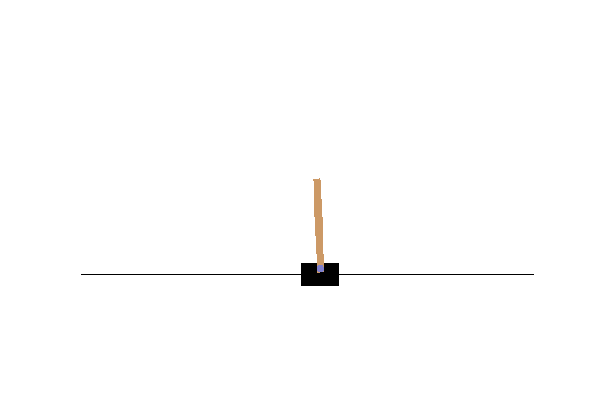
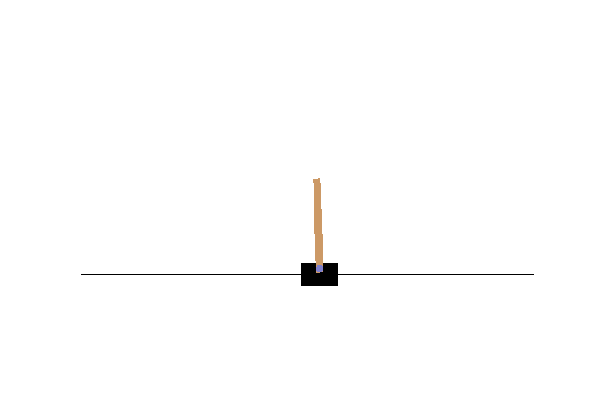
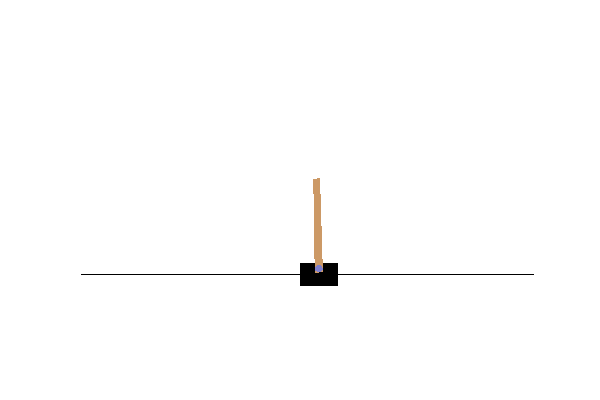
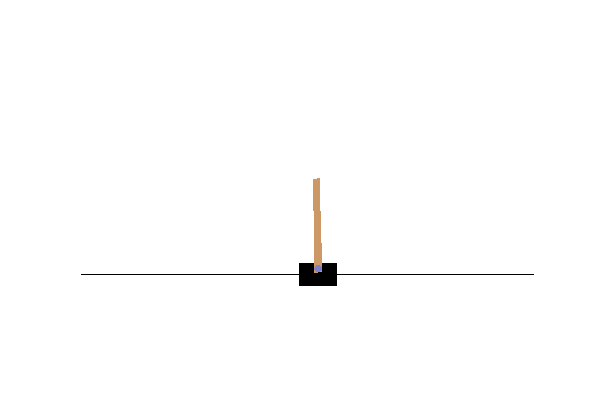
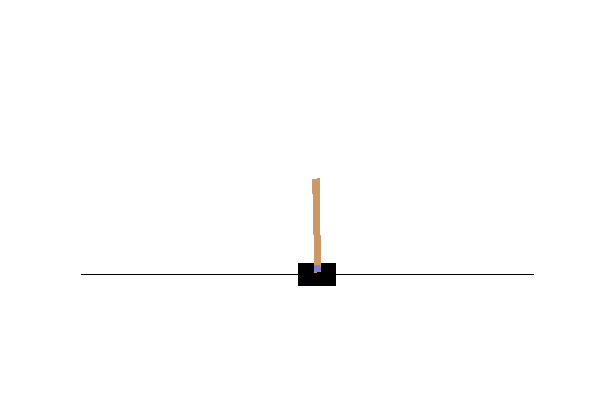
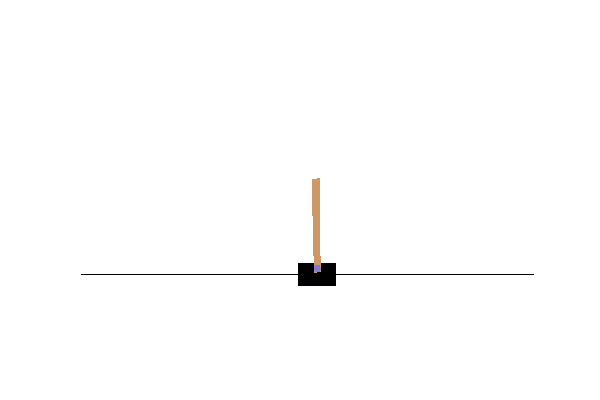
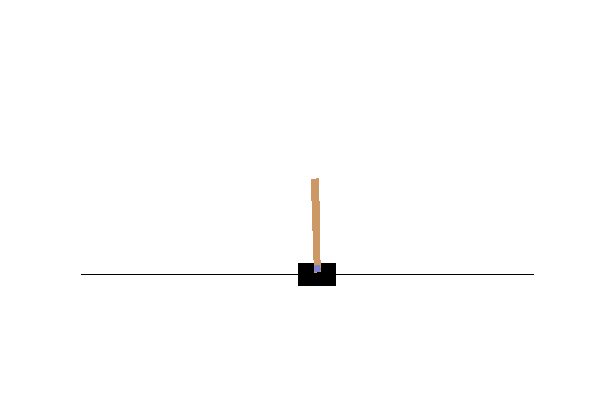
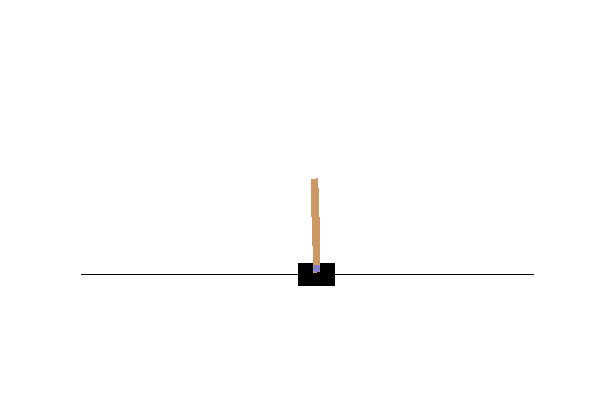
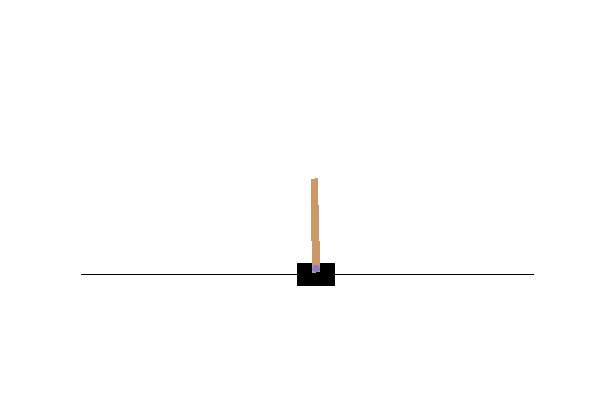
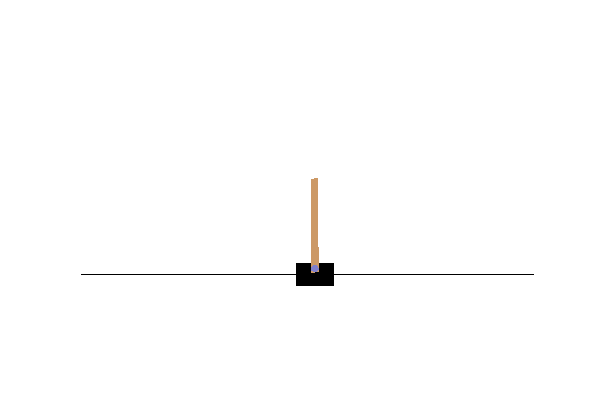
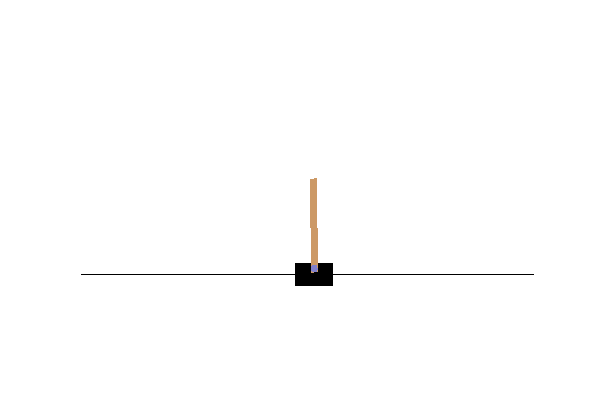
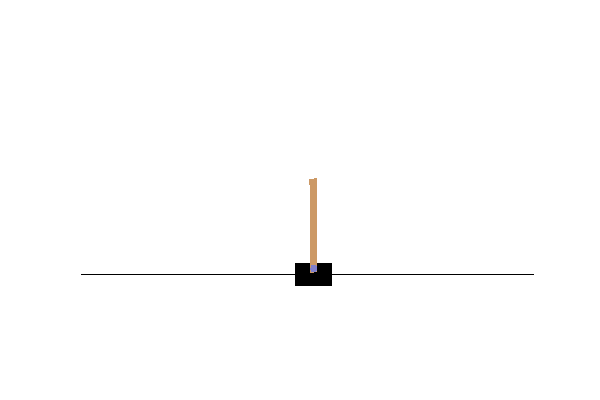
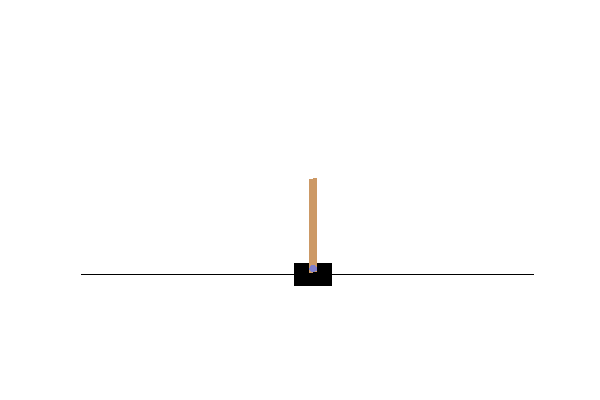
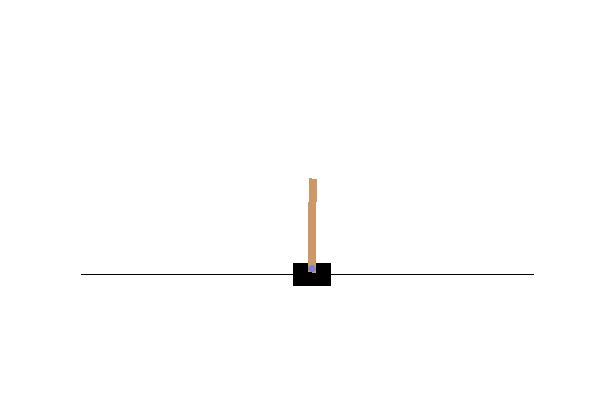
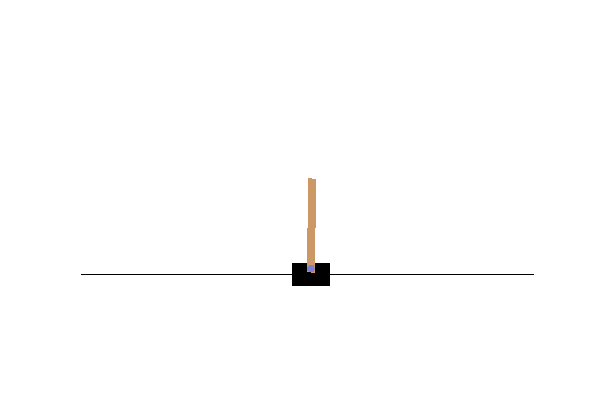
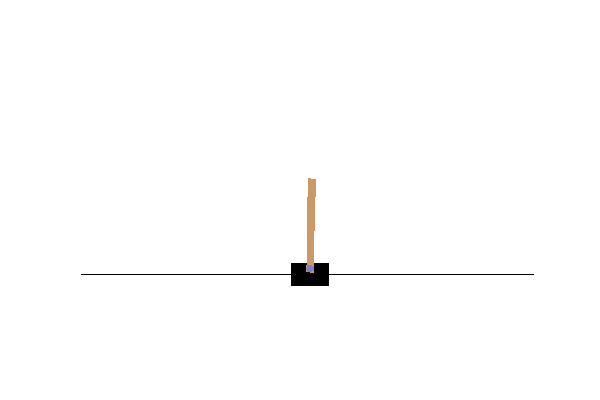
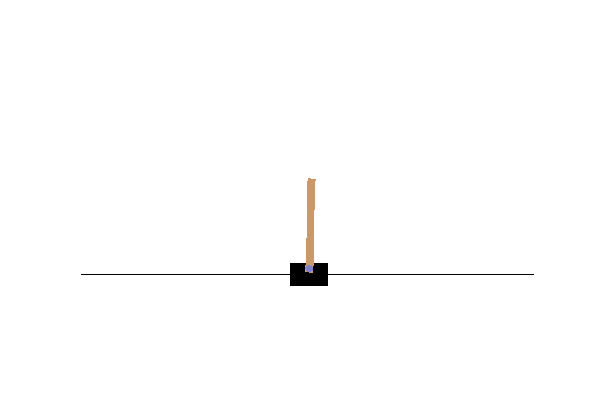
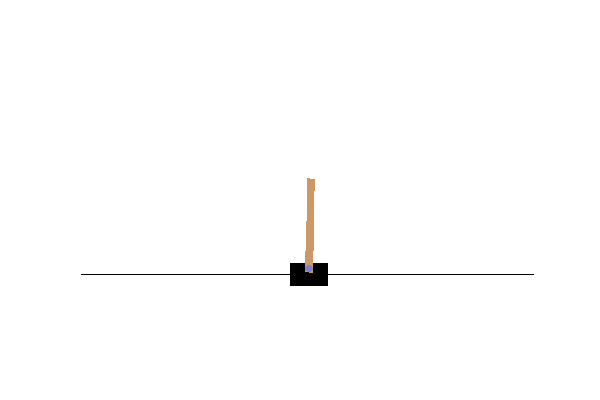
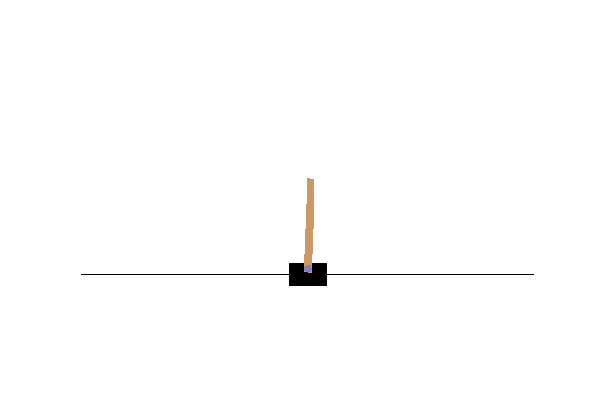
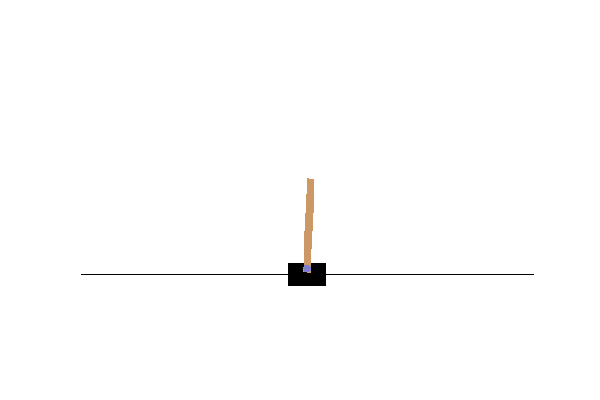
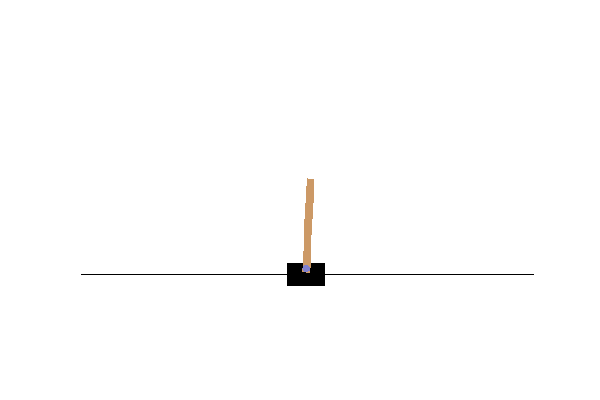
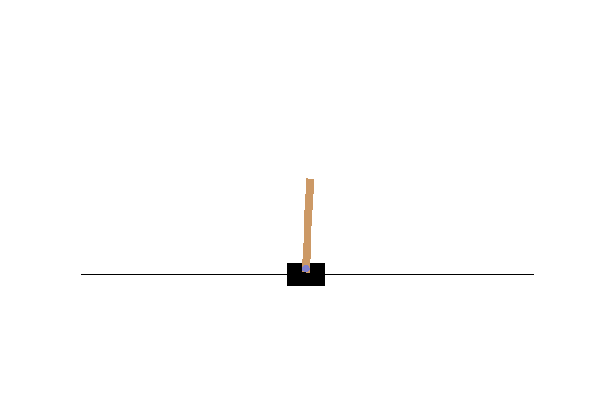
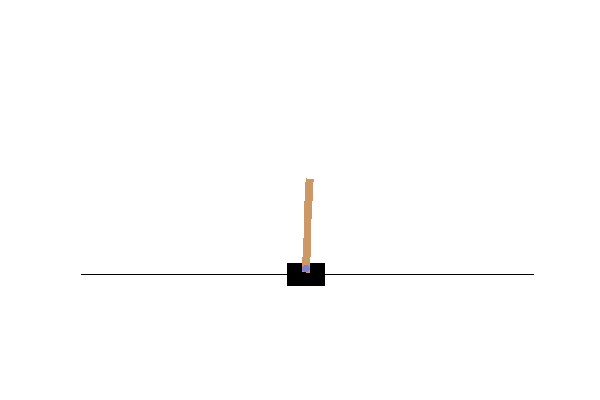
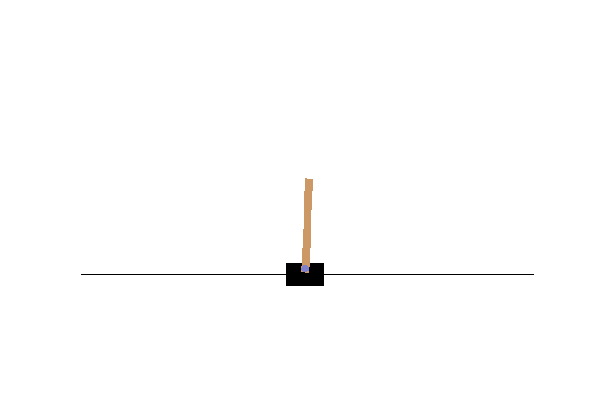
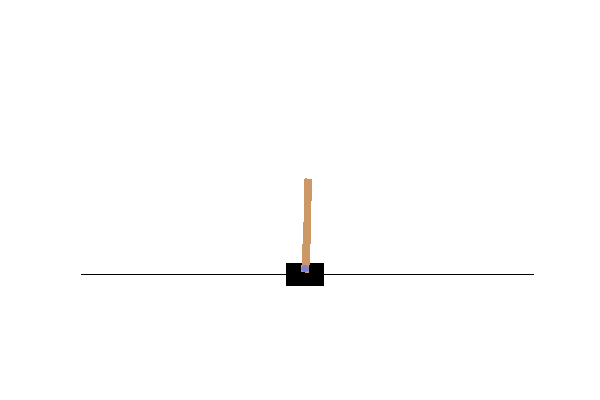
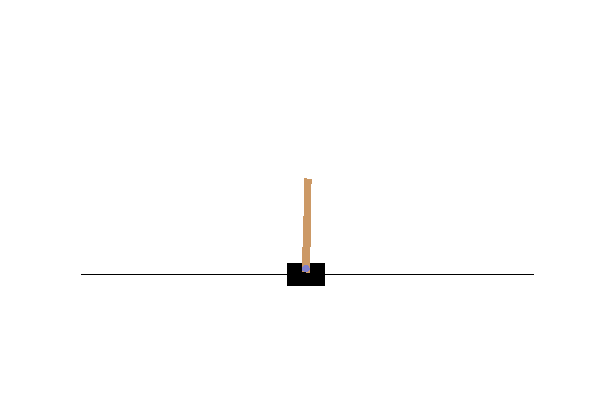
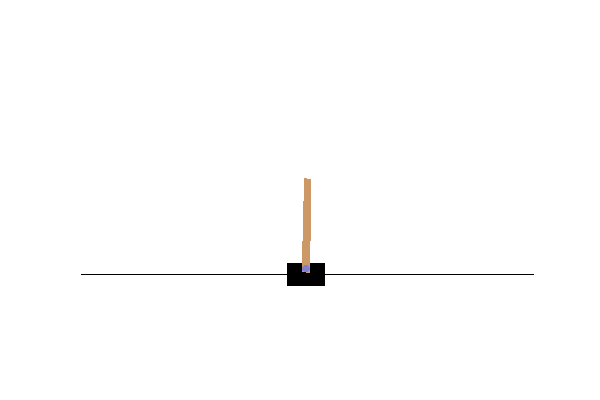
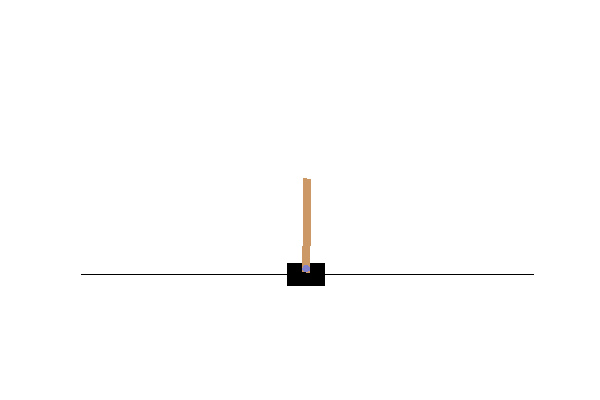
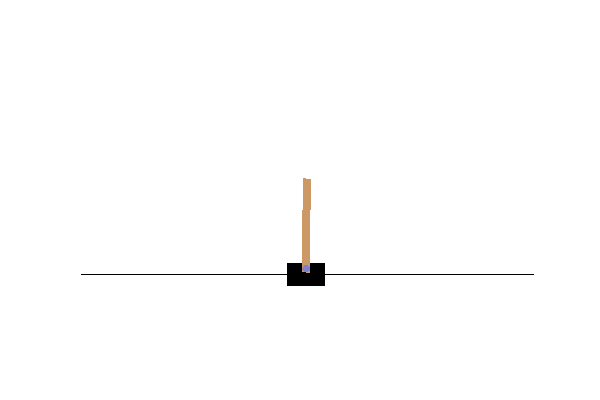
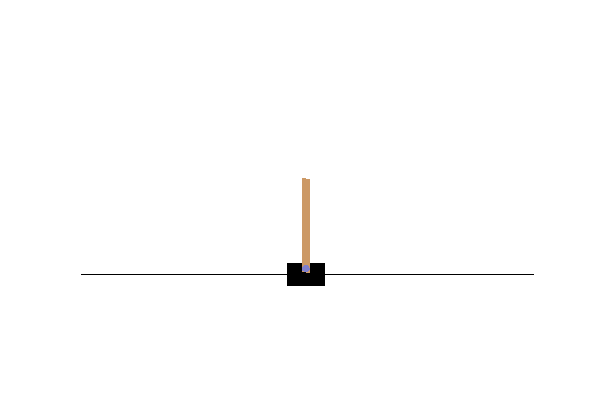
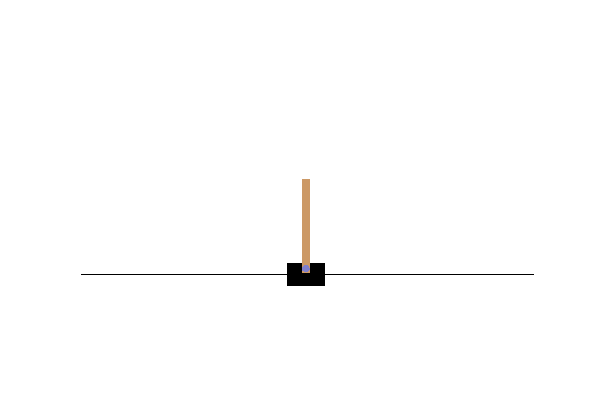
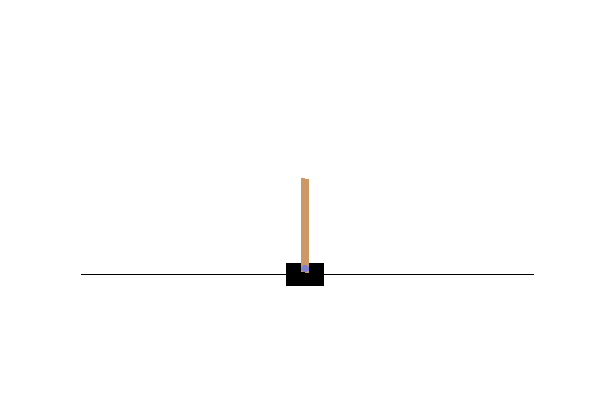
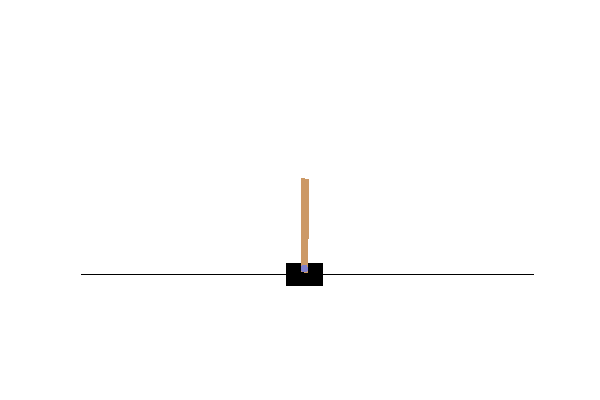
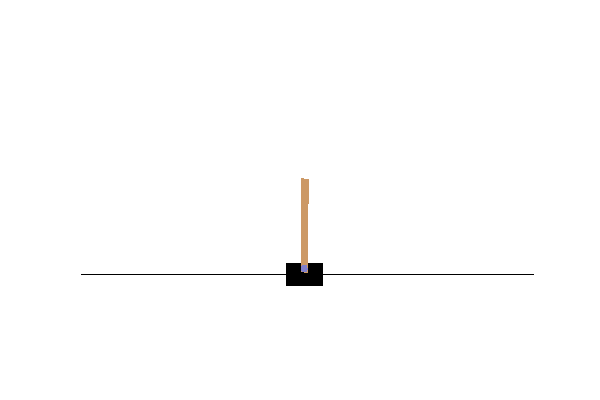
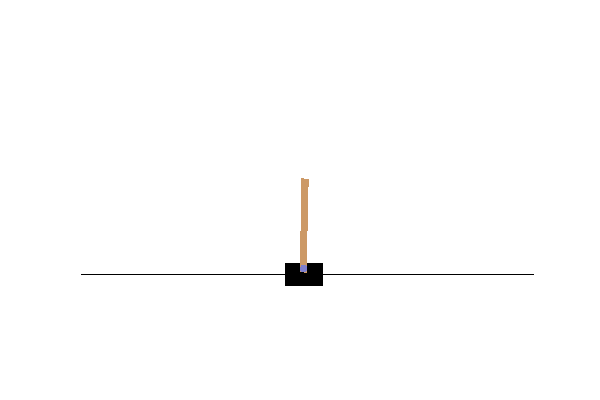
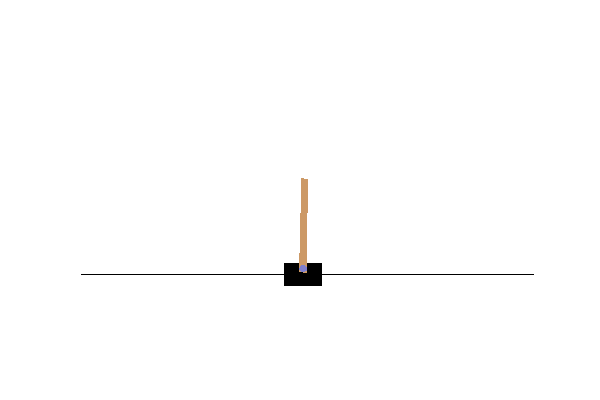
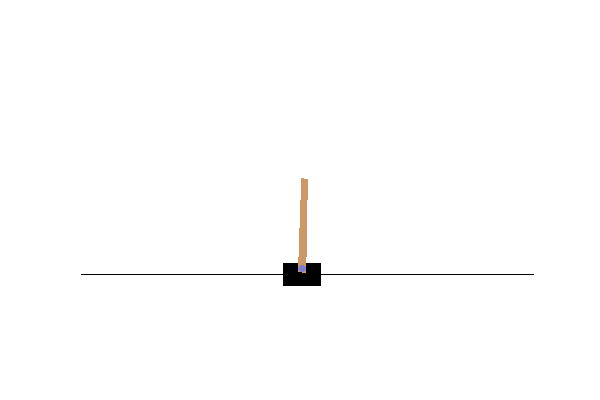
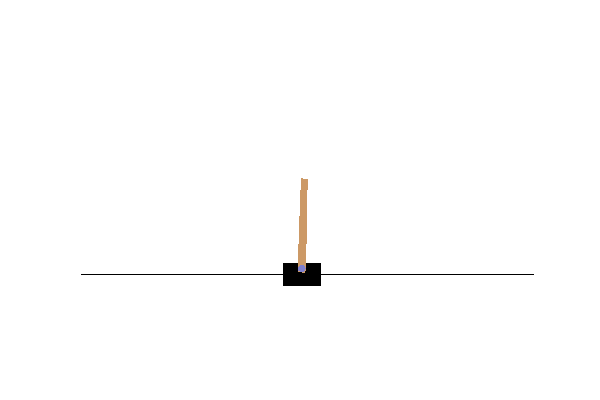
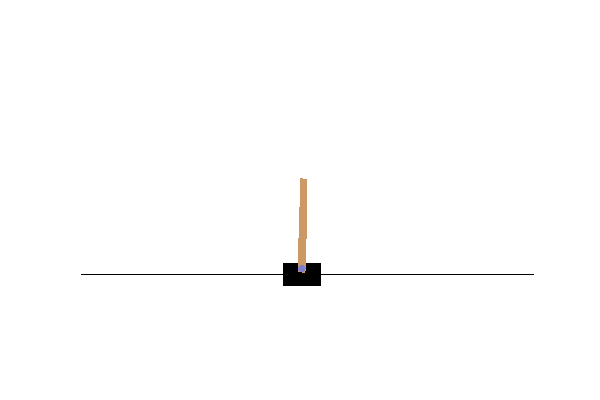
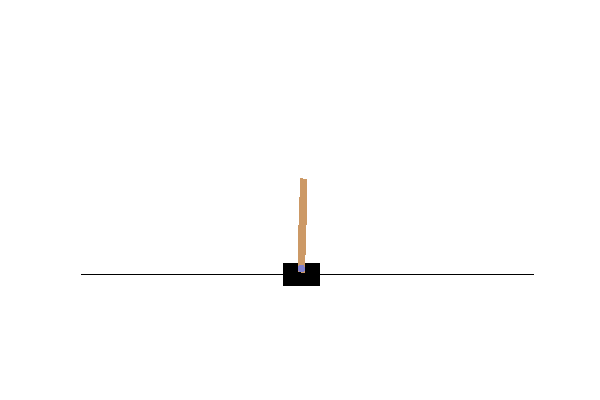
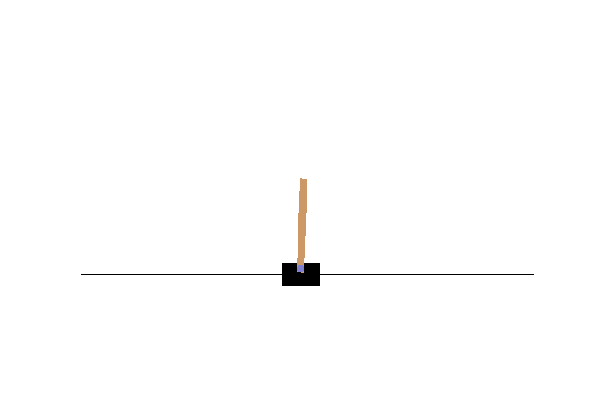
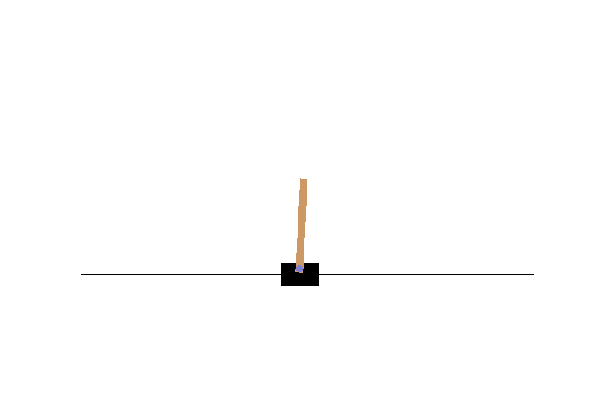
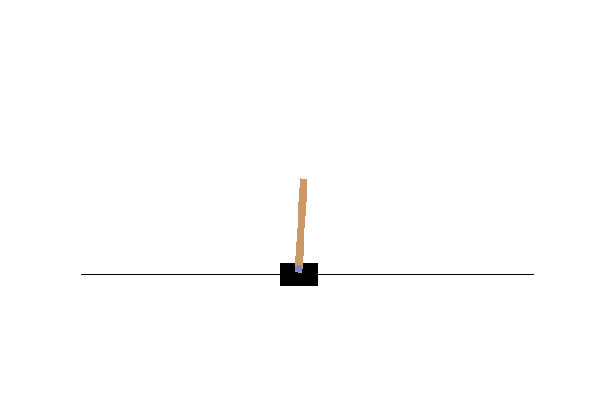
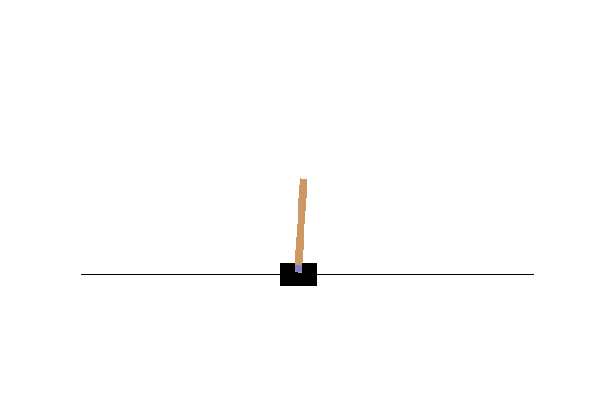
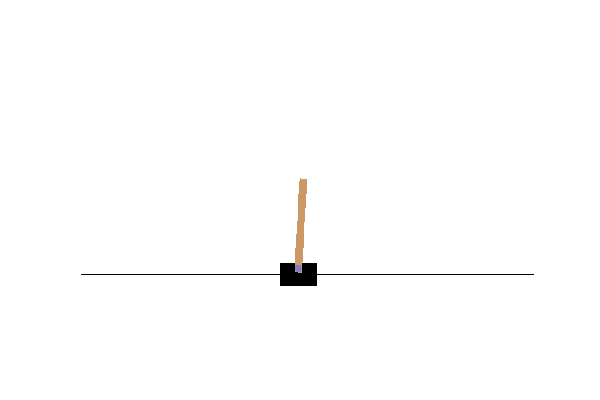
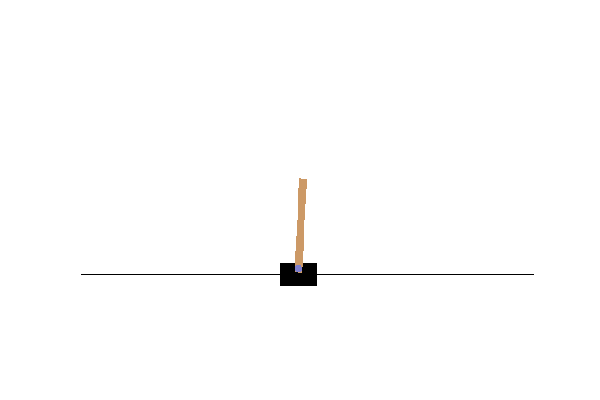
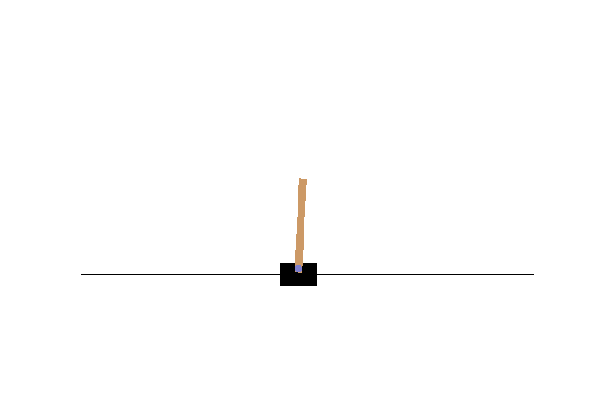
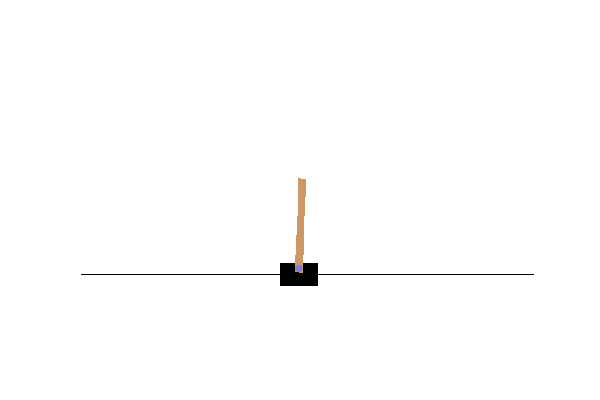
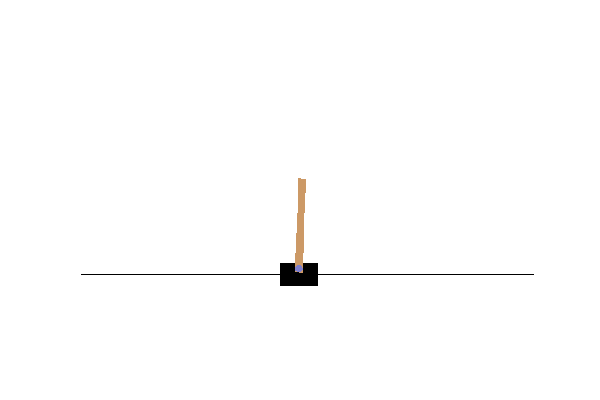
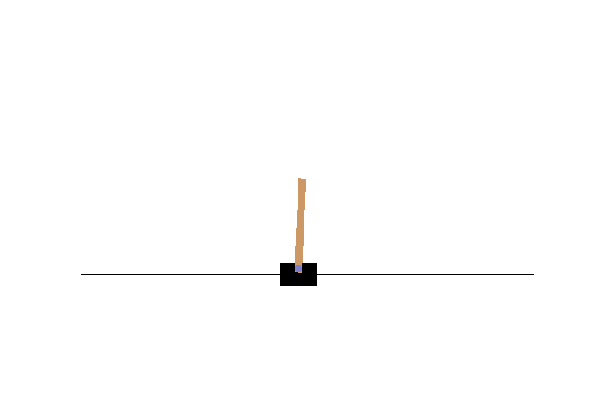
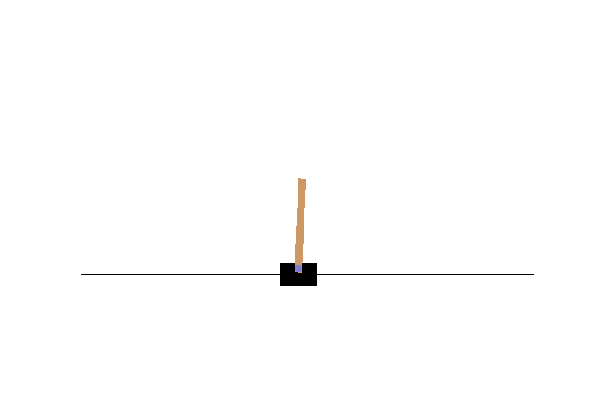
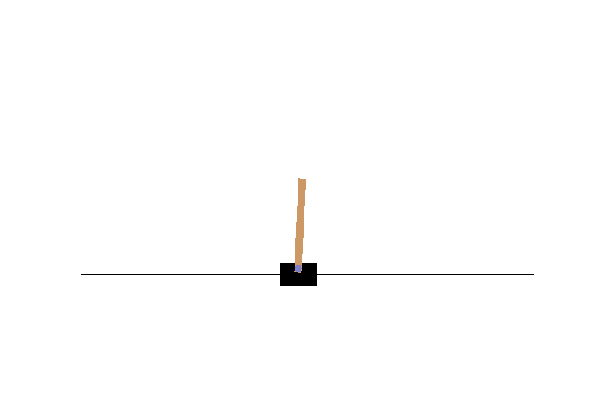
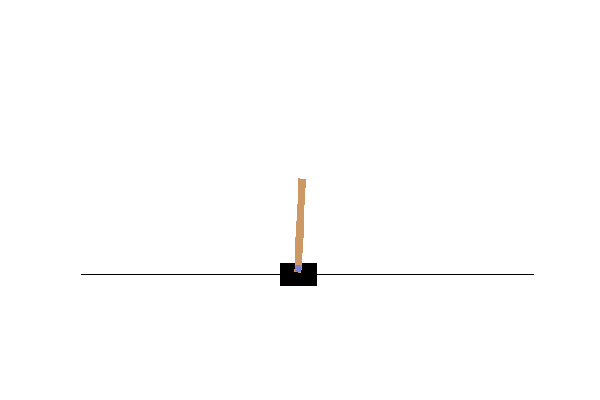
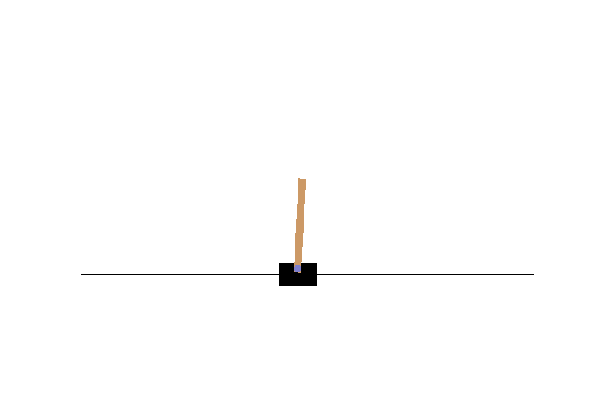
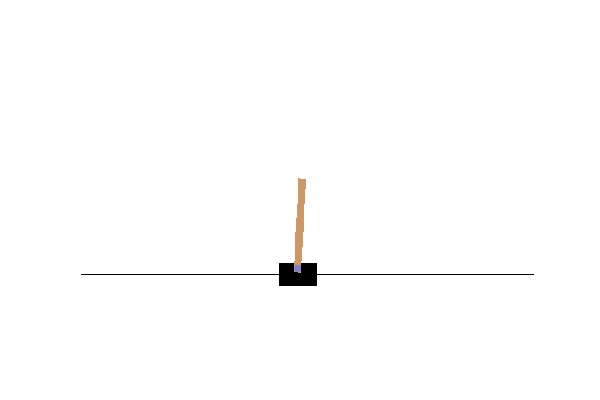
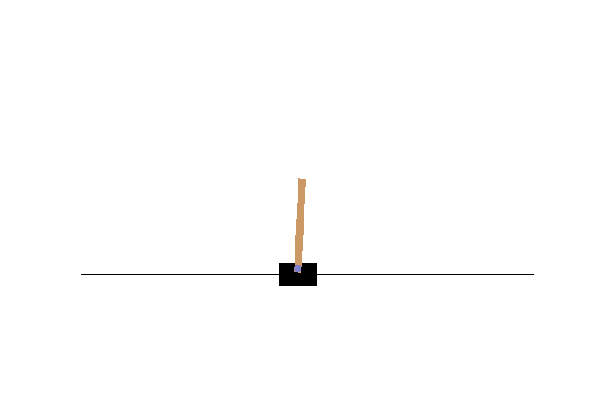
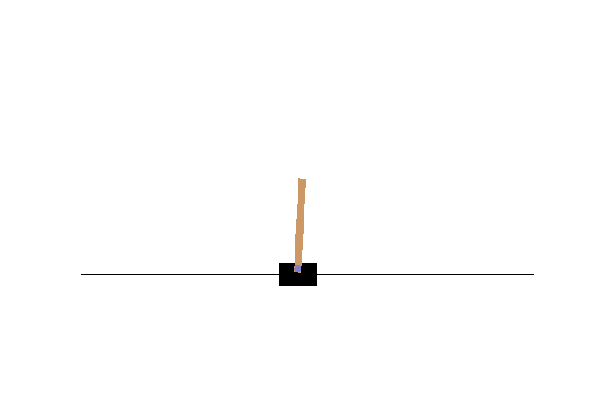
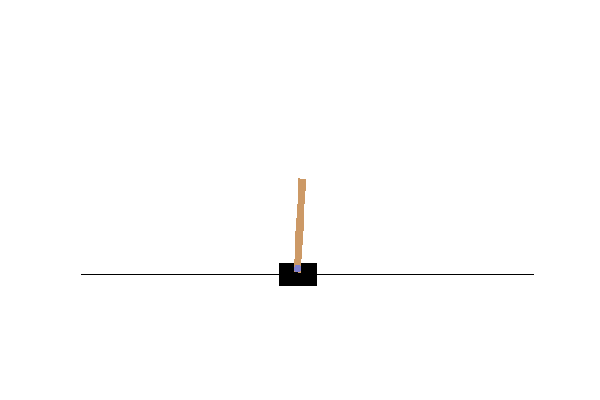
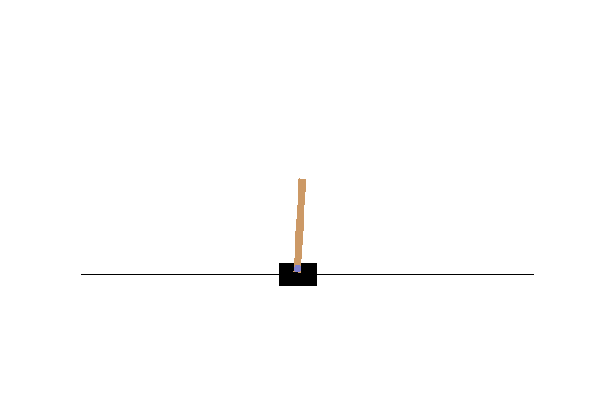
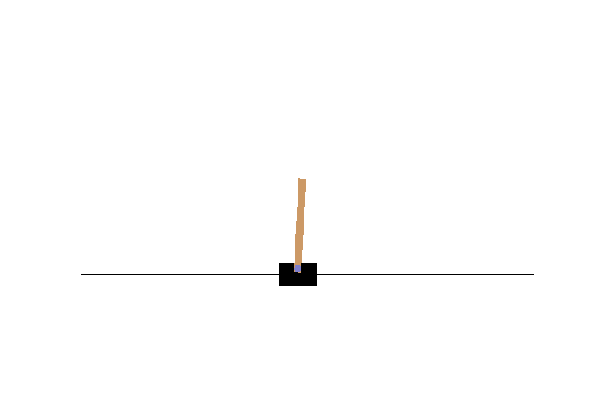
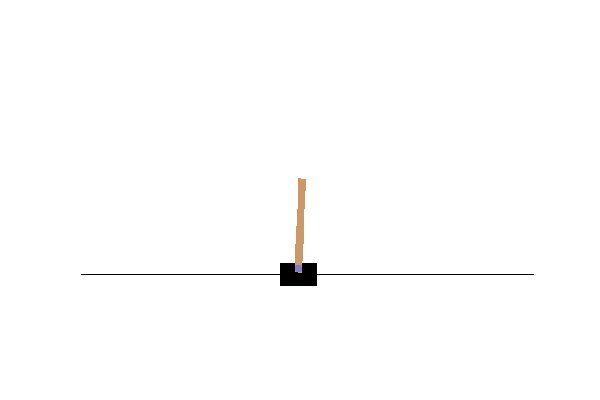
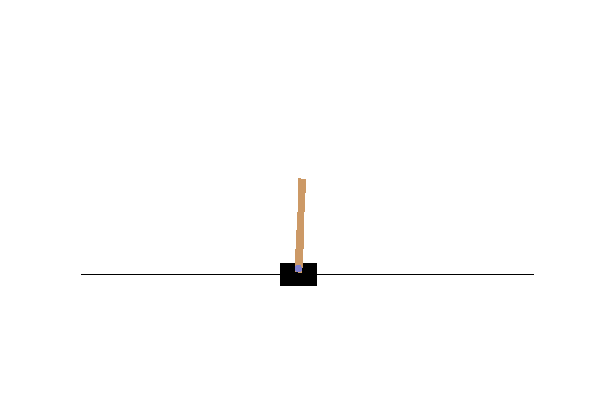
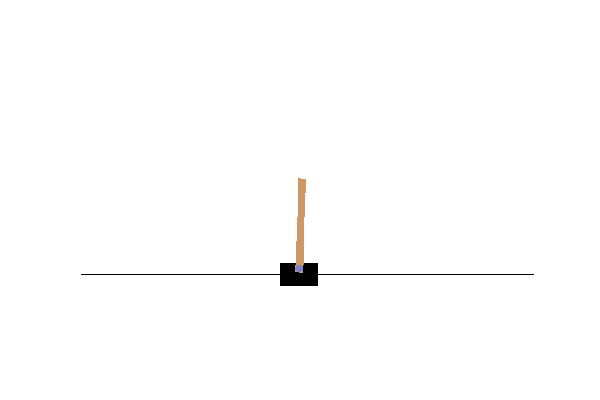
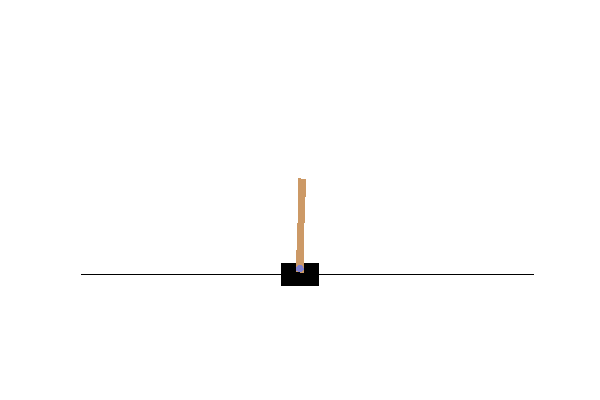
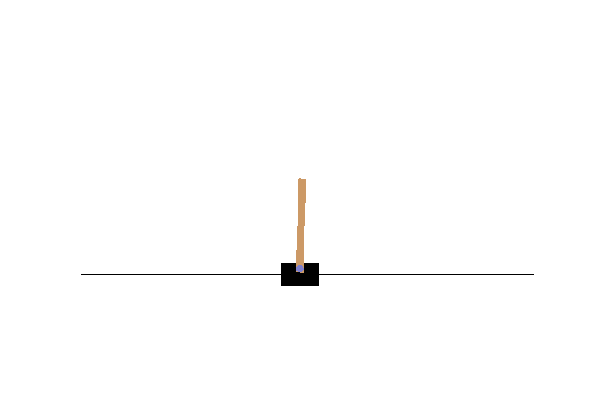
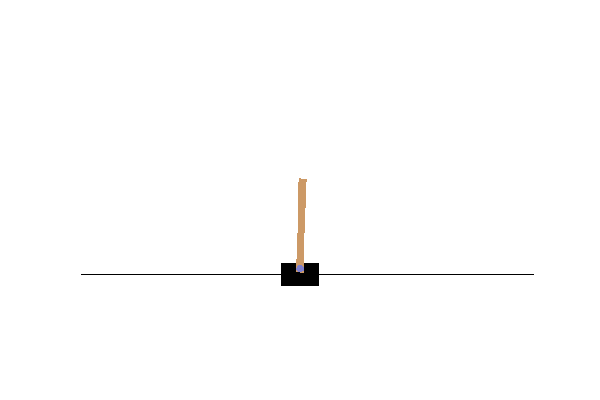
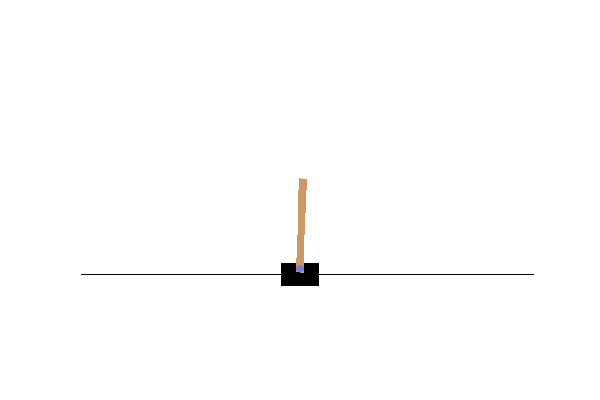
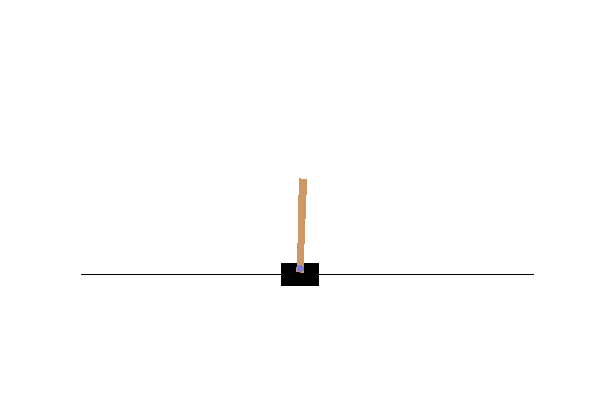
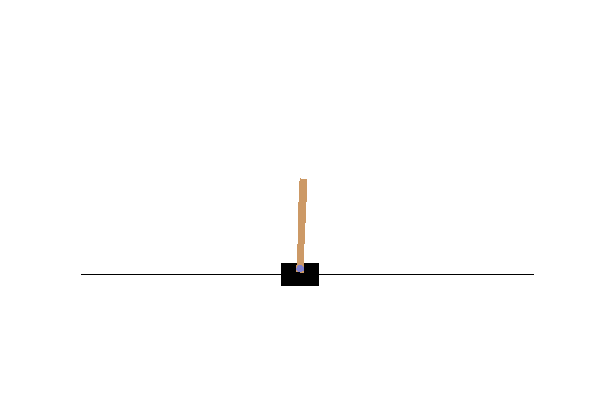
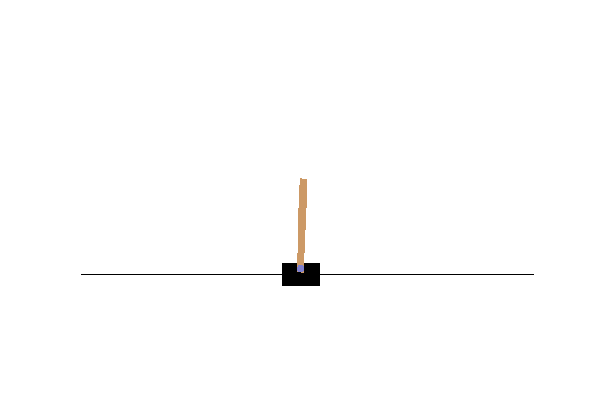
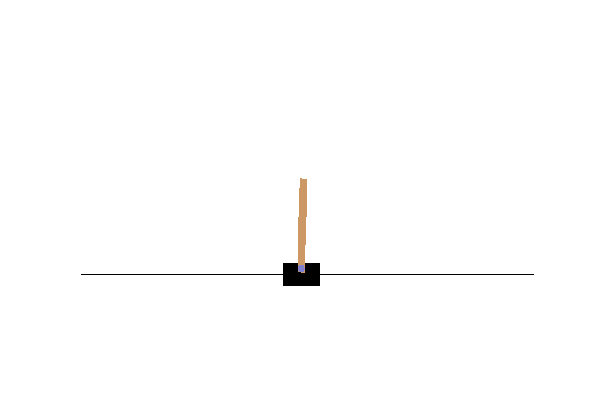
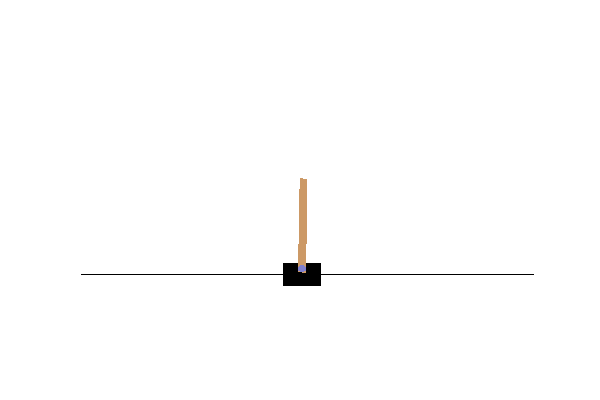
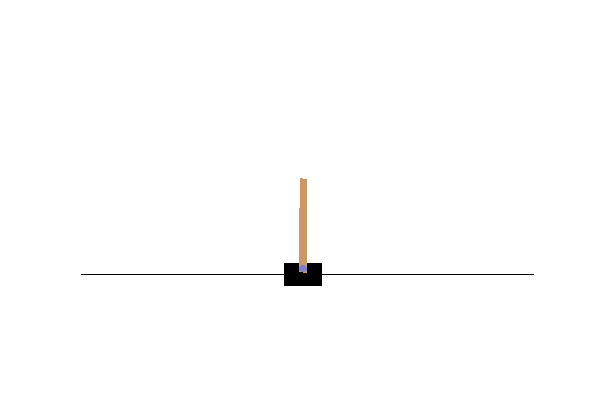
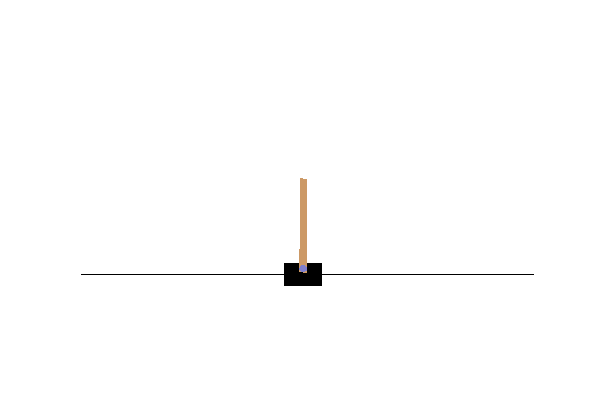
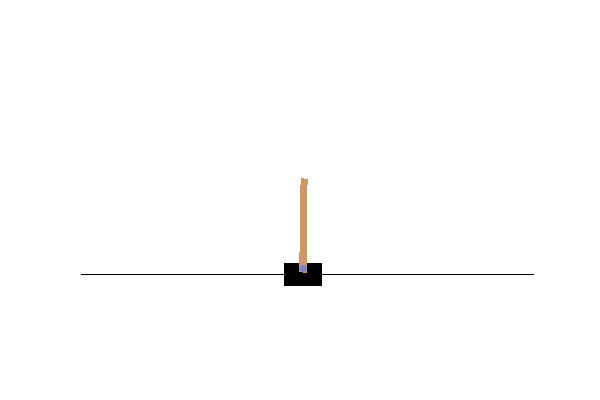
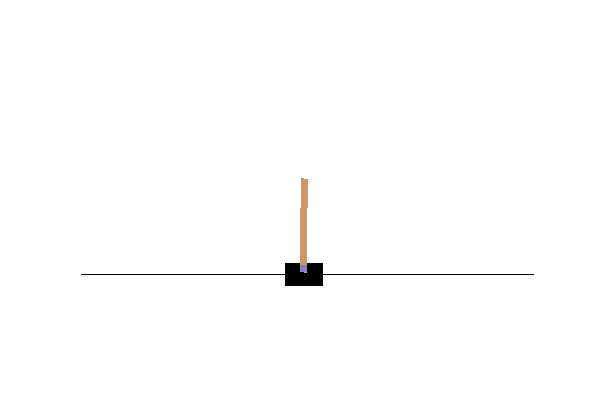
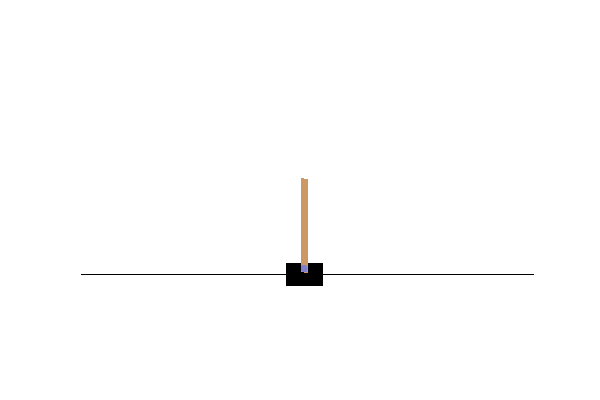
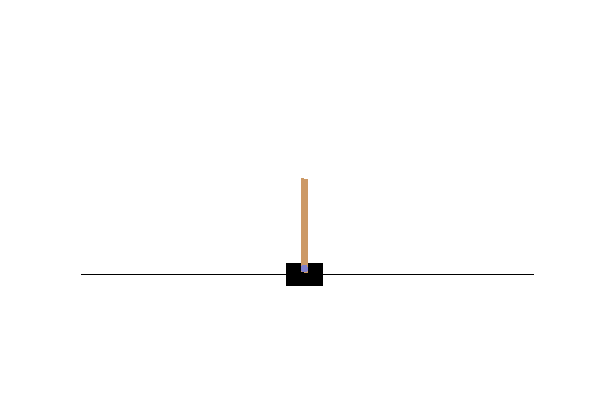
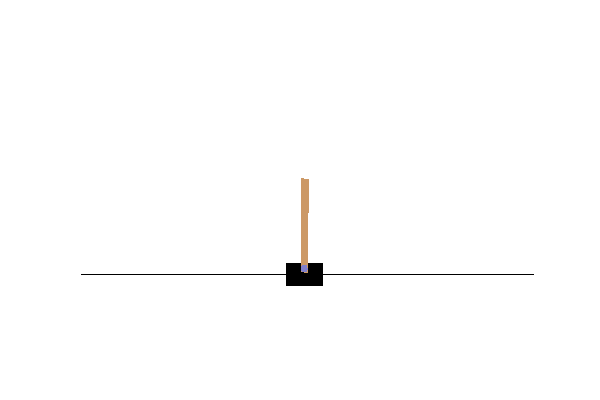
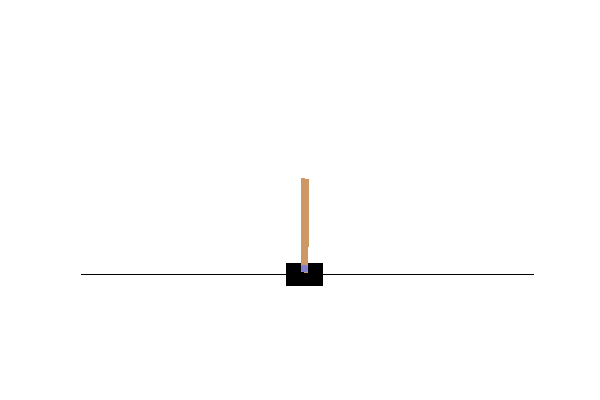
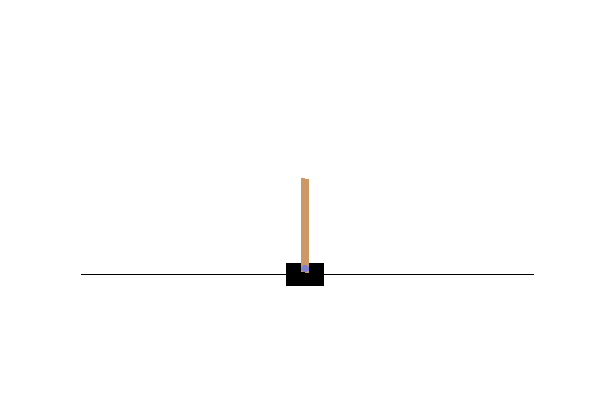
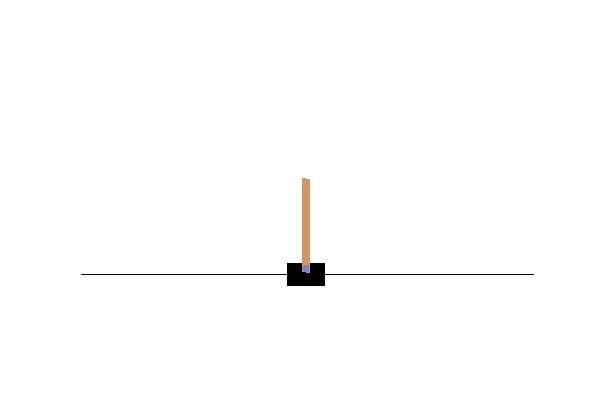
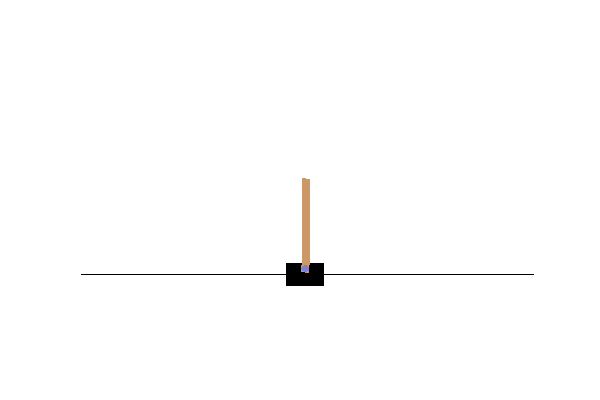
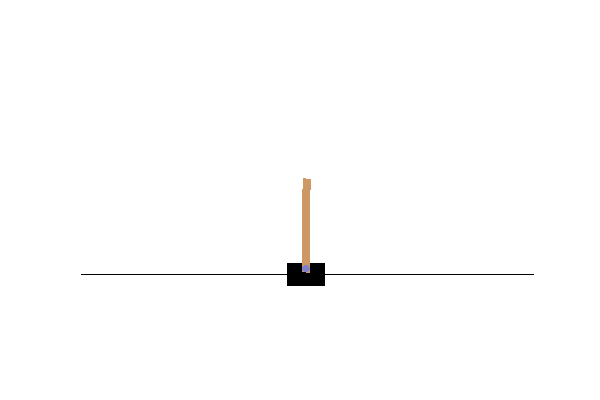
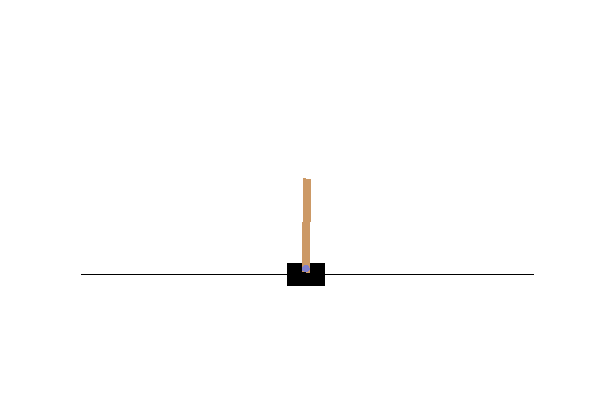
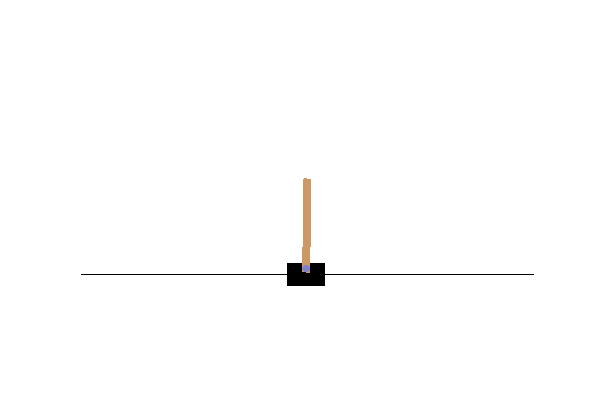
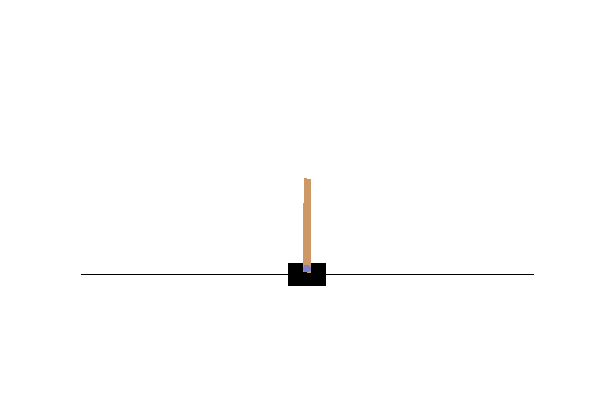
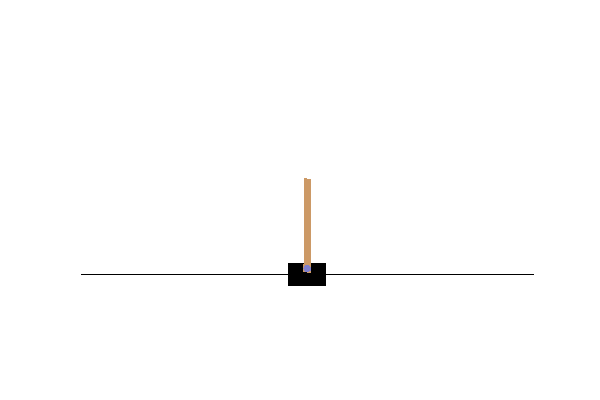
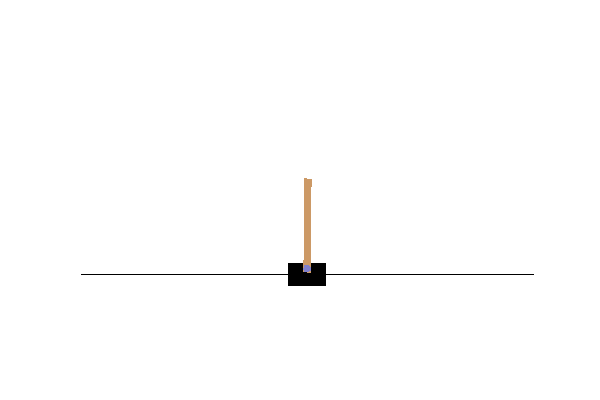
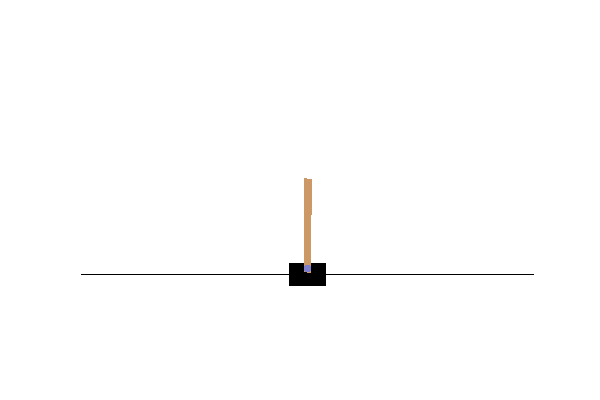
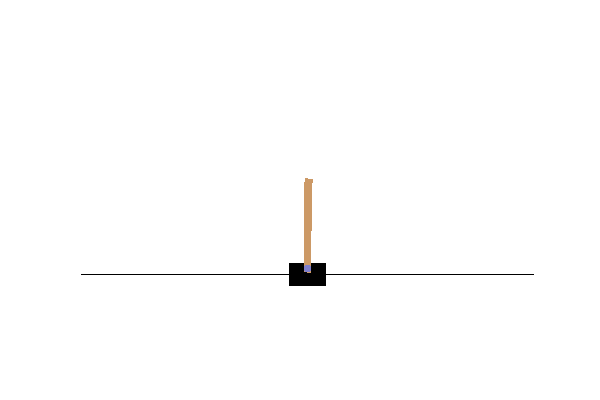
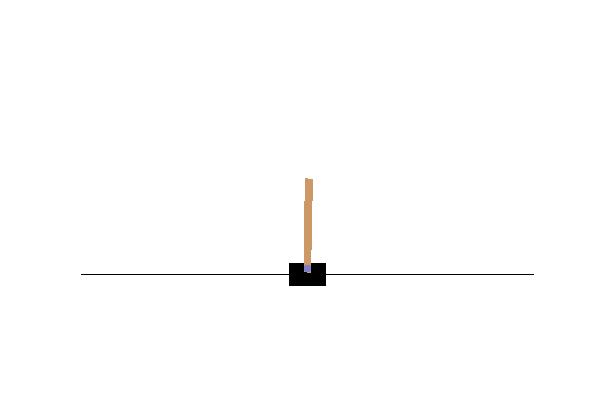
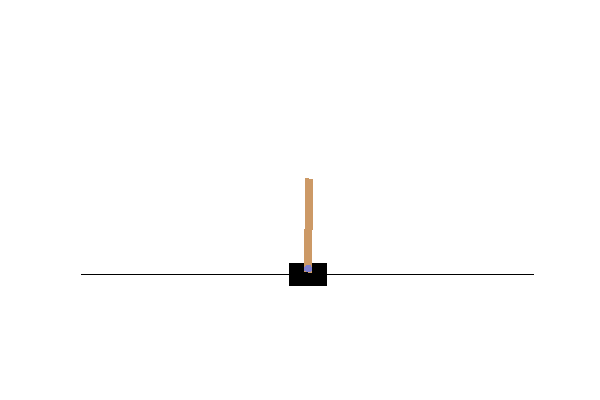
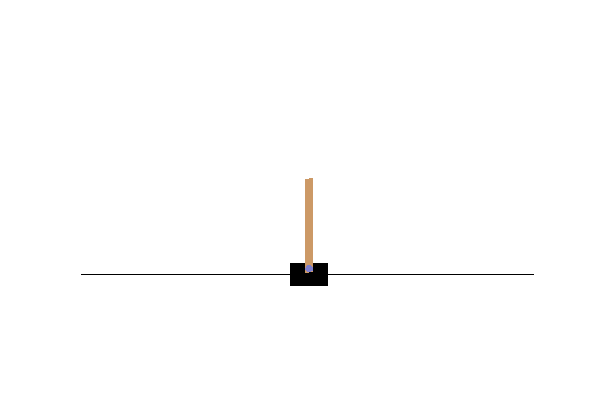
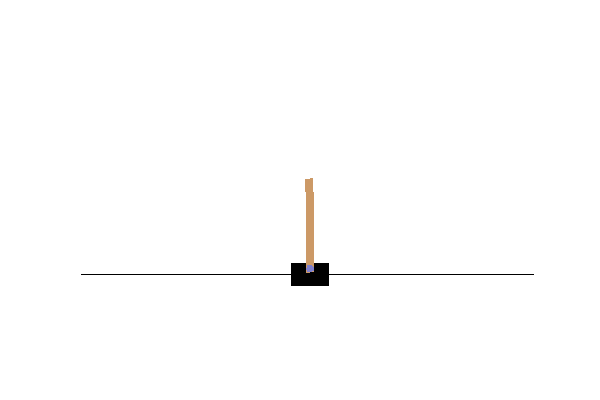
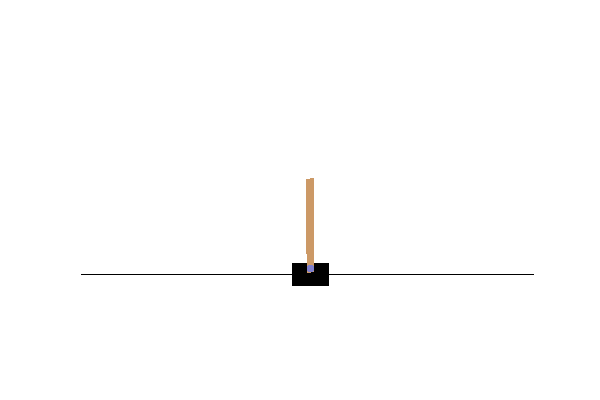
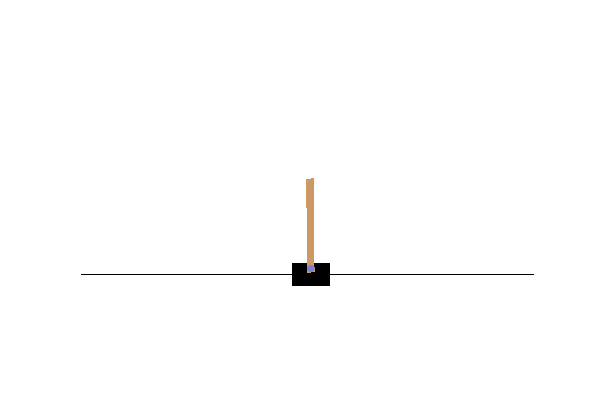
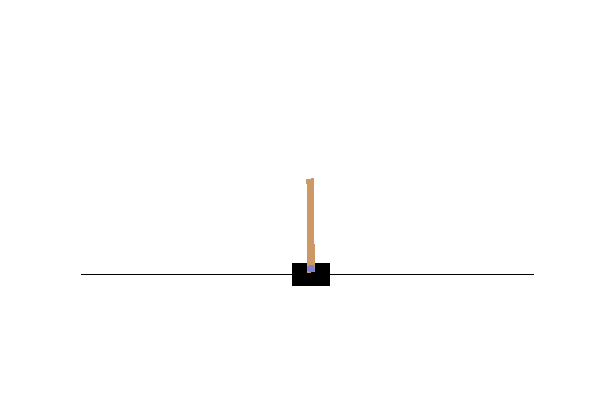
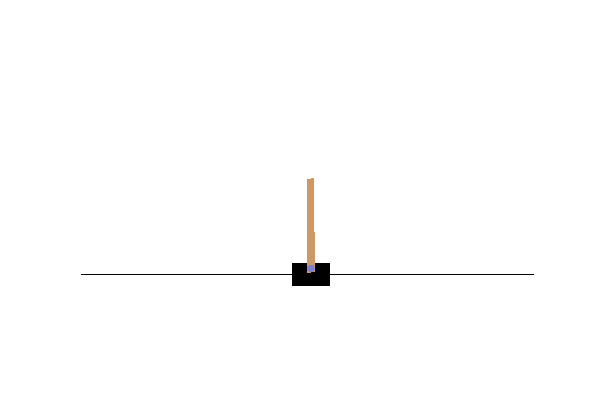
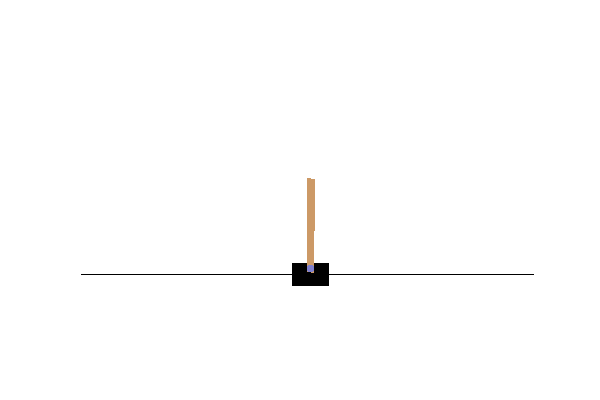
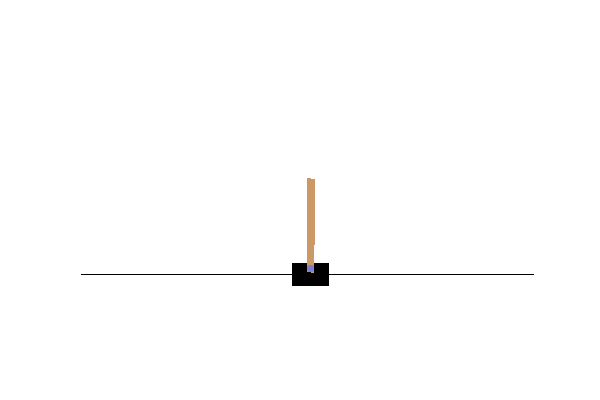
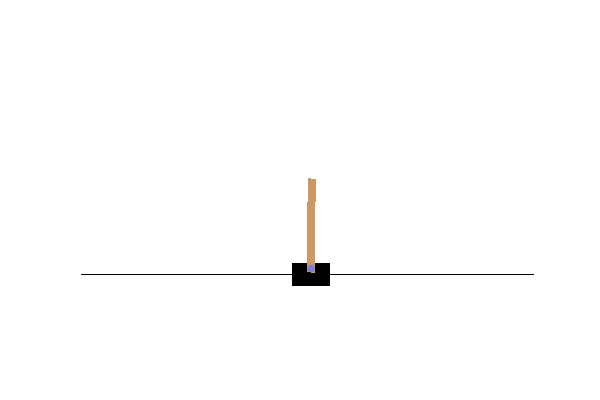
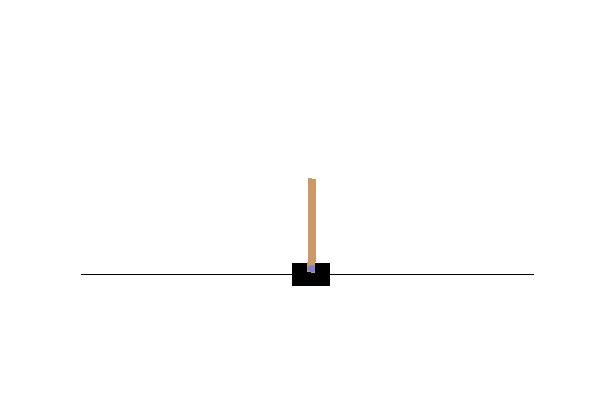
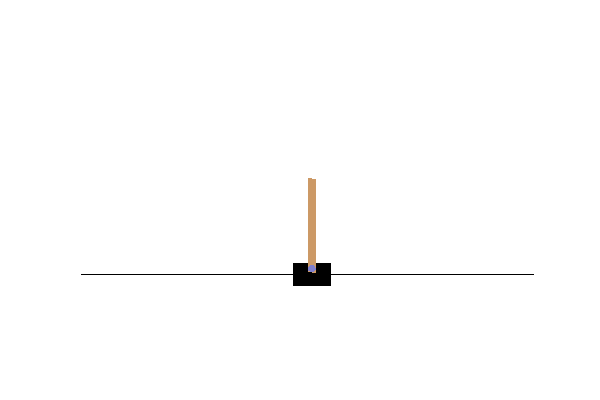
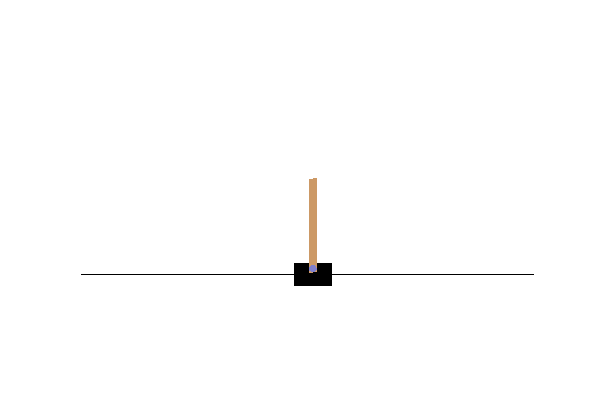
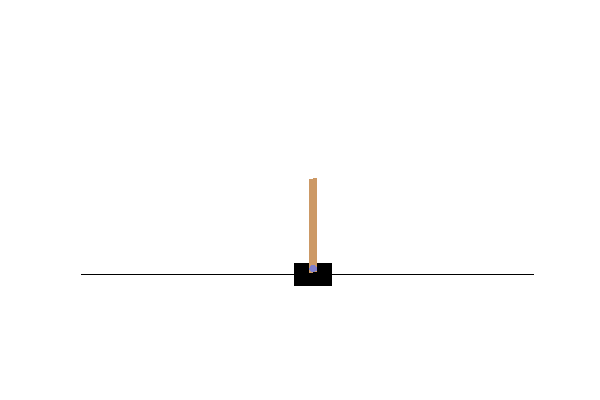
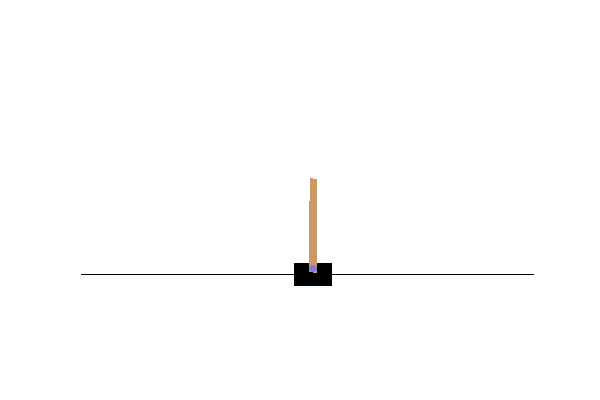
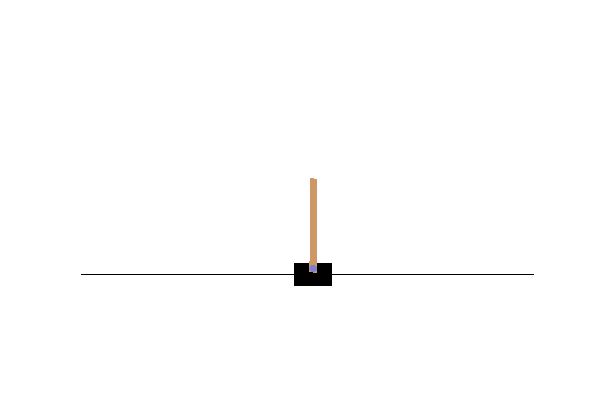
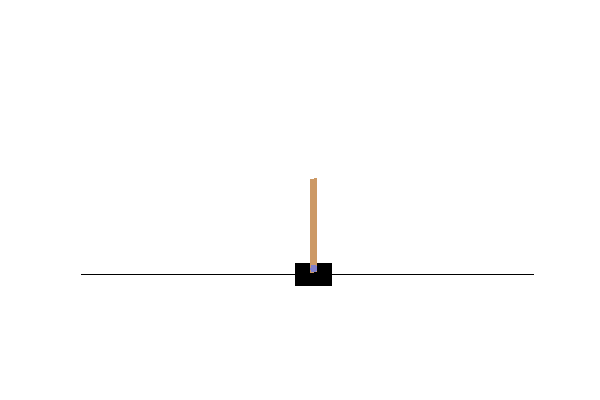
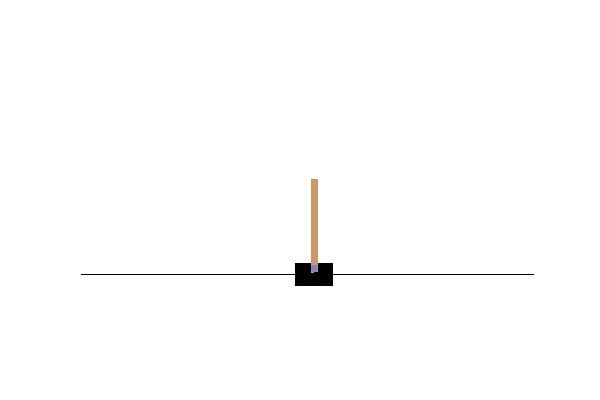
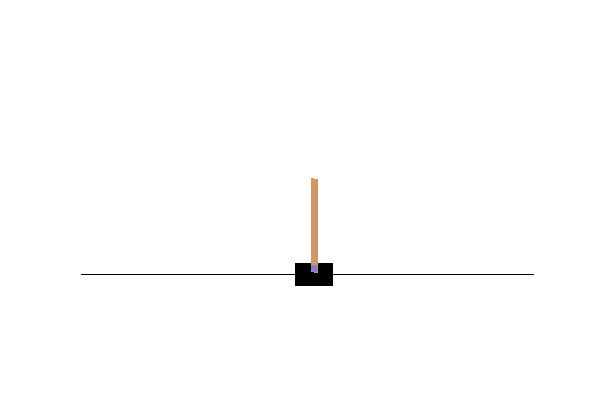
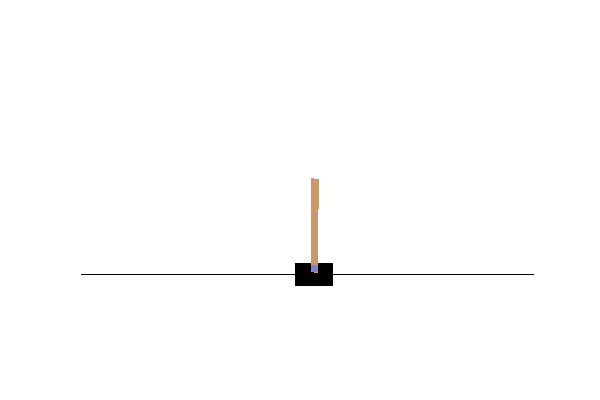
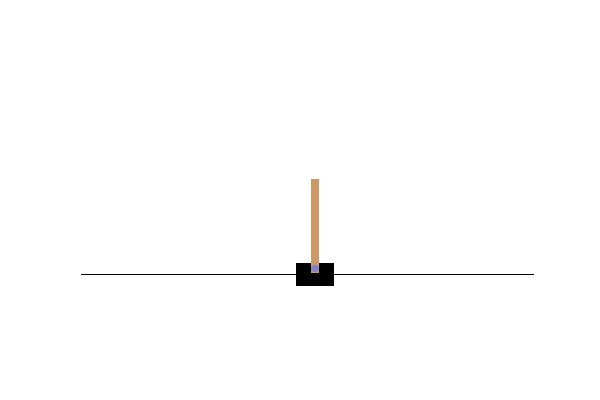
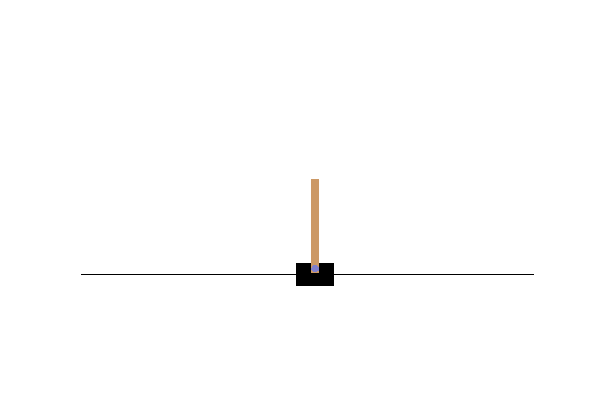
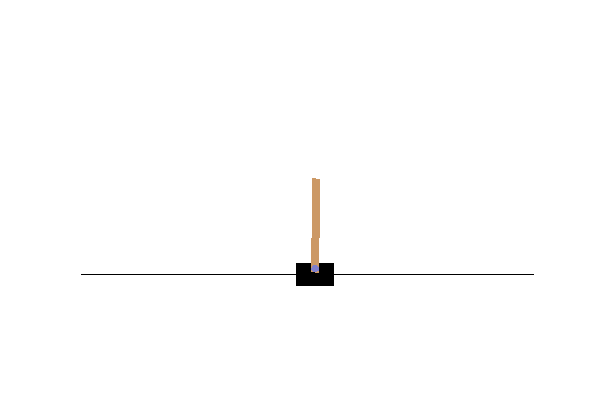
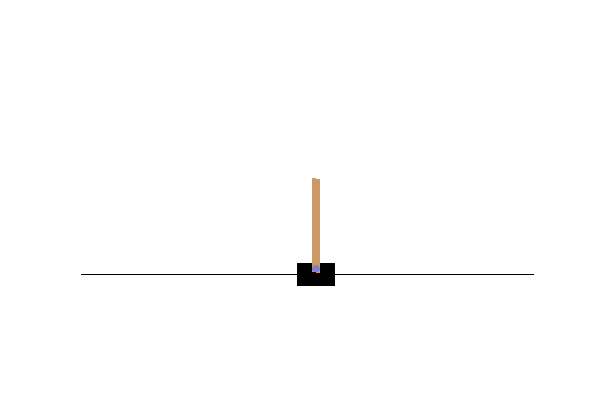
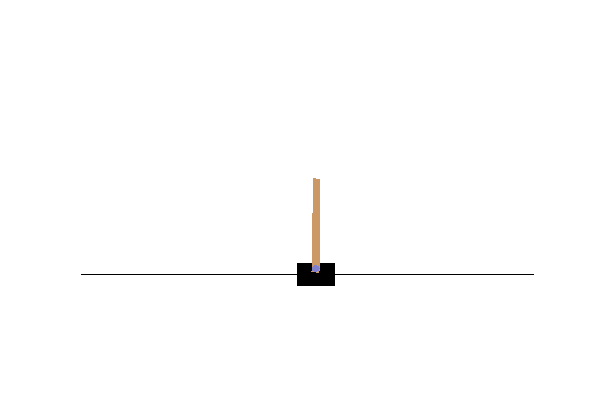
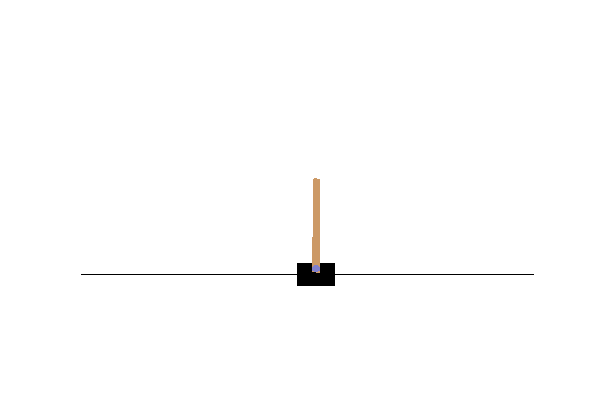
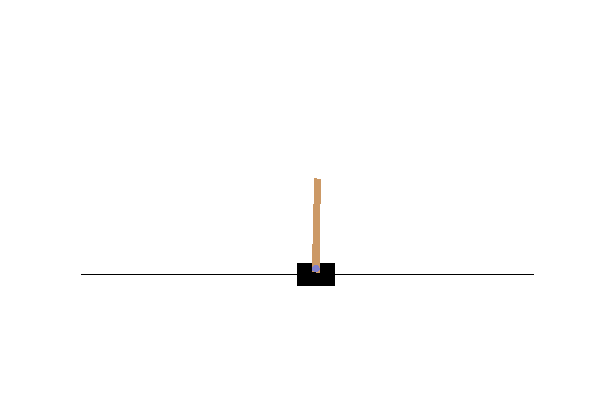
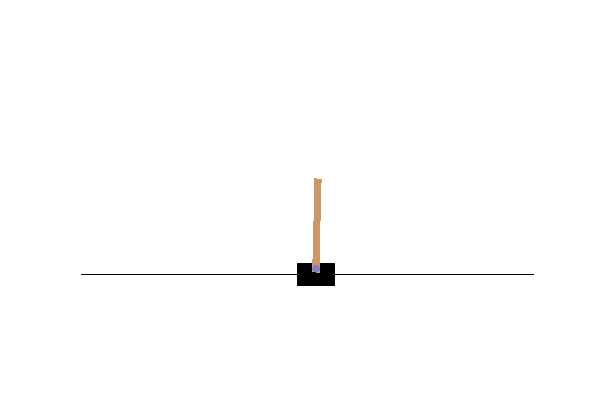
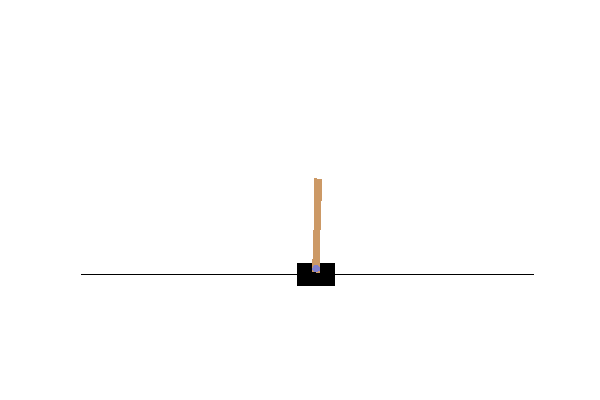
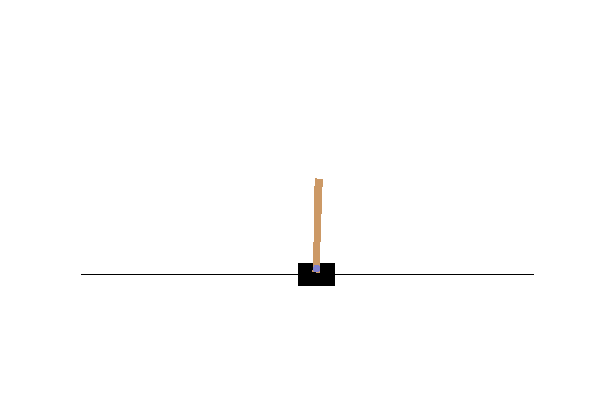
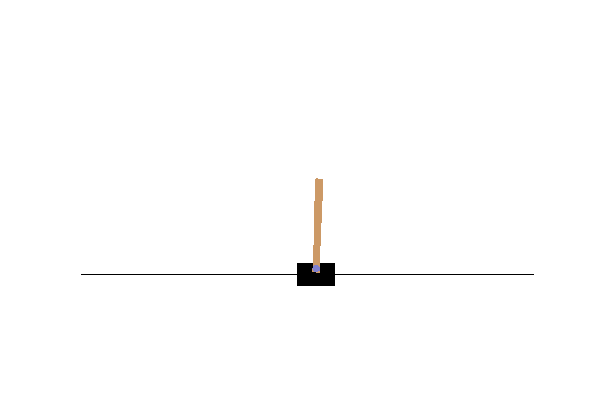

In [28]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

def show_game(env, policy, embedding=None):
    state = env.reset()
    done = False
    frames = []
    
    while not done:
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        
        input_state = _prepare_numpy(state, device='cpu')
        if embedding:
            input_state = embedding(input_state)
        
        action_dist, action = policy(input_state, get_action=True)
        action = action.item()
        state, reward, done, _ = env.step(action)
        
    
    env.close()
    display_frames_as_gif(frames)
    
show_game(env, policy)

## Space Invaders RAM

In [31]:
env_spaceinvaders = gym.make('SpaceInvaders-ram-v0')
n_state_size = 128
n_embedding_size = 16
n_action_size = 6
max_episode_length = 500

n_epochs = 100
n_episodes = 100
device = 'cpu'
embedding_spaceinvaders = EmbeddingNetwork(n_state_size, n_embedding_size).to(device)
policy_spaceinvaders = PolicyNetwork(n_embedding_size, n_action_size).to(device)
value_spaceinvaders = ValueNetwork(n_embedding_size).to(device)
reward_queue_spaceinvaders = Queue()
main(env_spaceinvaders, embedding, policy_spaceinvaders, value_spaceinvaders, device, 
     reward_queue_spaceinvaders, n_epochs, n_episodes, max_episode_length)
print("done")

avg reward: 48.750, value loss: 168.181, policy loss: 0.013:   1%|          | 1/100 [00:38<1:02:45, 38.03s/it]

avg reward: 52.950, value loss: 81.386, policy loss: 0.008:   2%|▏         | 2/100 [01:16<1:02:12, 38.08s/it] 

avg reward: 60.550, value loss: 157.179, policy loss: 0.054:   3%|▎         | 3/100 [01:54<1:01:50, 38.25s/it]

avg reward: 54.650, value loss: 107.608, policy loss: -0.174:   4%|▍         | 4/100 [02:33<1:01:27, 38.41s/it]

avg reward: 53.300, value loss: 70.125, policy loss: 0.037:   5%|▌         | 5/100 [03:12<1:01:09, 38.63s/it]  

avg reward: 57.400, value loss: 109.112, policy loss: 0.003:   6%|▌         | 6/100 [03:50<1:00:11, 38.42s/it]

avg reward: 62.000, value loss: 58.051, policy loss: -0.045:   7%|▋         | 7/100 [04:28<59:09, 38.16s/it]  

avg reward: 70.100, value loss: 72.998, policy loss: 0.000:   8%|▊         | 8/100 [05:05<58:02, 37.85s/it] 

avg reward: 73.900, value loss: 94.834, policy loss: -0.035:   9%|▉         | 9/100 [05:42<57:04, 37.63s/it]

avg reward: 64.900, value loss: 41.026, policy loss: 0.042:  10%|█         | 10/100 [06:19<56:14, 37.50s/it]

avg reward: 75.500, value loss: 38.855, policy loss: -0.011:  11%|█         | 11/100 [06:57<55:39, 37.52s/it]

avg reward: 79.750, value loss: 70.853, policy loss: 0.029:  12%|█▏        | 12/100 [07:34<54:59, 37.49s/it] 

avg reward: 77.500, value loss: 110.412, policy loss: 0.005:  13%|█▎        | 13/100 [08:12<54:24, 37.52s/it]

avg reward: 84.950, value loss: 67.046, policy loss: 0.047:  14%|█▍        | 14/100 [08:49<53:50, 37.57s/it] 

avg reward: 84.550, value loss: 86.474, policy loss: 0.033:  15%|█▌        | 15/100 [09:27<53:22, 37.67s/it]

avg reward: 89.100, value loss: 75.512, policy loss: 0.104:  16%|█▌        | 16/100 [10:05<52:40, 37.63s/it]

avg reward: 90.450, value loss: 44.730, policy loss: 0.038:  17%|█▋        | 17/100 [10:43<52:02, 37.62s/it]

avg reward: 81.000, value loss: 31.044, policy loss: -0.061:  18%|█▊        | 18/100 [11:20<51:24, 37.62s/it]

avg reward: 85.650, value loss: 55.230, policy loss: 0.000:  19%|█▉        | 19/100 [11:58<50:56, 37.73s/it] 

avg reward: 86.350, value loss: 49.609, policy loss: -0.026:  20%|██        | 20/100 [12:35<50:06, 37.58s/it]

avg reward: 90.800, value loss: 69.097, policy loss: -0.084:  21%|██        | 21/100 [13:13<49:30, 37.60s/it]

avg reward: 85.500, value loss: 33.056, policy loss: -0.069:  22%|██▏       | 22/100 [13:51<48:52, 37.60s/it]

avg reward: 93.700, value loss: 81.231, policy loss: -0.170:  23%|██▎       | 23/100 [14:28<48:16, 37.62s/it]

avg reward: 91.850, value loss: 89.167, policy loss: -0.183:  24%|██▍       | 24/100 [15:06<47:33, 37.54s/it]

avg reward: 88.650, value loss: 42.404, policy loss: -0.050:  25%|██▌       | 25/100 [15:43<46:57, 37.57s/it]

avg reward: 90.550, value loss: 30.686, policy loss: -0.089:  26%|██▌       | 26/100 [16:21<46:16, 37.52s/it]

avg reward: 89.950, value loss: 41.193, policy loss: -0.003:  27%|██▋       | 27/100 [16:58<45:40, 37.54s/it]

avg reward: 93.600, value loss: 46.757, policy loss: -0.107:  28%|██▊       | 28/100 [17:36<45:05, 37.58s/it]

avg reward: 88.300, value loss: 27.461, policy loss: -0.017:  29%|██▉       | 29/100 [18:14<44:42, 37.79s/it]

avg reward: 90.400, value loss: 28.772, policy loss: -0.024:  30%|███       | 30/100 [18:52<43:59, 37.71s/it]

avg reward: 90.600, value loss: 23.149, policy loss: 0.013:  31%|███       | 31/100 [19:29<43:21, 37.70s/it] 

avg reward: 87.900, value loss: 25.178, policy loss: 0.011:  32%|███▏      | 32/100 [20:07<42:39, 37.64s/it]

avg reward: 94.050, value loss: 26.505, policy loss: -0.058:  33%|███▎      | 33/100 [20:45<42:03, 37.67s/it]

avg reward: 94.300, value loss: 46.354, policy loss: 0.007:  34%|███▍      | 34/100 [21:22<41:21, 37.60s/it] 

avg reward: 91.050, value loss: 29.271, policy loss: -0.041:  35%|███▌      | 35/100 [21:59<40:40, 37.55s/it]

avg reward: 90.750, value loss: 28.305, policy loss: -0.027:  36%|███▌      | 36/100 [22:37<39:56, 37.45s/it]

avg reward: 87.200, value loss: 25.653, policy loss: -0.033:  37%|███▋      | 37/100 [23:14<39:18, 37.44s/it]

avg reward: 91.550, value loss: 24.372, policy loss: 0.030:  38%|███▊      | 38/100 [23:51<38:39, 37.41s/it] 

avg reward: 94.800, value loss: 44.948, policy loss: -0.150:  39%|███▉      | 39/100 [24:29<37:58, 37.36s/it]

avg reward: 85.700, value loss: 43.725, policy loss: -0.170:  40%|████      | 40/100 [25:06<37:15, 37.27s/it]

avg reward: 88.150, value loss: 30.368, policy loss: -0.049:  41%|████      | 41/100 [25:43<36:41, 37.31s/it]

avg reward: 90.100, value loss: 27.742, policy loss: 0.006:  42%|████▏     | 42/100 [26:21<36:05, 37.33s/it] 

avg reward: 91.750, value loss: 27.751, policy loss: -0.033:  43%|████▎     | 43/100 [26:58<35:27, 37.33s/it]

avg reward: 90.250, value loss: 28.253, policy loss: -0.003:  44%|████▍     | 44/100 [27:35<34:51, 37.35s/it]

avg reward: 93.700, value loss: 24.858, policy loss: -0.007:  45%|████▌     | 45/100 [28:13<34:21, 37.49s/it]

avg reward: 96.350, value loss: 20.750, policy loss: 0.008:  46%|████▌     | 46/100 [28:50<33:40, 37.42s/it] 

avg reward: 95.200, value loss: 23.659, policy loss: -0.001:  47%|████▋     | 47/100 [29:28<33:10, 37.55s/it]

avg reward: 94.000, value loss: 20.695, policy loss: 0.022:  48%|████▊     | 48/100 [30:06<32:35, 37.61s/it] 

avg reward: 93.250, value loss: 25.958, policy loss: 0.021:  49%|████▉     | 49/100 [30:44<32:02, 37.70s/it]

avg reward: 95.250, value loss: 26.224, policy loss: -0.011:  50%|█████     | 50/100 [31:21<31:18, 37.56s/it]

avg reward: 96.250, value loss: 20.582, policy loss: 0.006:  51%|█████     | 51/100 [31:59<30:38, 37.53s/it] 

avg reward: 97.000, value loss: 21.296, policy loss: 0.011:  52%|█████▏    | 52/100 [32:36<29:56, 37.43s/it]

avg reward: 95.900, value loss: 19.749, policy loss: 0.022:  53%|█████▎    | 53/100 [33:13<29:22, 37.49s/it]

avg reward: 98.900, value loss: 45.352, policy loss: 0.024:  54%|█████▍    | 54/100 [33:51<28:41, 37.43s/it]

avg reward: 97.600, value loss: 16.782, policy loss: 0.010:  55%|█████▌    | 55/100 [34:28<28:05, 37.45s/it]

avg reward: 99.100, value loss: 23.221, policy loss: 0.029:  56%|█████▌    | 56/100 [35:06<27:26, 37.43s/it]

avg reward: 101.800, value loss: 36.077, policy loss: -0.006:  57%|█████▋    | 57/100 [35:43<26:48, 37.42s/it]

avg reward: 99.450, value loss: 20.959, policy loss: 0.007:  58%|█████▊    | 58/100 [36:20<26:08, 37.35s/it]  

avg reward: 100.900, value loss: 21.710, policy loss: 0.023:  59%|█████▉    | 59/100 [36:58<25:34, 37.43s/it]

avg reward: 101.200, value loss: 17.936, policy loss: -0.018:  60%|██████    | 60/100 [37:35<24:53, 37.34s/it]

avg reward: 100.200, value loss: 19.694, policy loss: -0.003:  61%|██████    | 61/100 [38:12<24:18, 37.39s/it]

avg reward: 99.750, value loss: 17.001, policy loss: 0.018:  62%|██████▏   | 62/100 [38:50<23:43, 37.45s/it]  

avg reward: 98.850, value loss: 20.221, policy loss: 0.023:  63%|██████▎   | 63/100 [39:28<23:08, 37.51s/it]

avg reward: 100.150, value loss: 20.064, policy loss: 0.011:  64%|██████▍   | 64/100 [40:05<22:30, 37.52s/it]

avg reward: 99.550, value loss: 21.161, policy loss: -0.010:  65%|██████▌   | 65/100 [40:43<21:55, 37.59s/it]

avg reward: 100.400, value loss: 16.935, policy loss: 0.015:  66%|██████▌   | 66/100 [41:20<21:14, 37.50s/it]

avg reward: 99.800, value loss: 20.723, policy loss: 0.003:  67%|██████▋   | 67/100 [41:58<20:39, 37.57s/it] 

avg reward: 105.050, value loss: 30.882, policy loss: 0.000:  68%|██████▊   | 68/100 [42:35<19:59, 37.50s/it]

avg reward: 98.550, value loss: 18.440, policy loss: 0.001:  69%|██████▉   | 69/100 [43:13<19:22, 37.51s/it] 

avg reward: 100.350, value loss: 23.852, policy loss: 0.002:  70%|███████   | 70/100 [43:50<18:42, 37.41s/it]

avg reward: 100.450, value loss: 20.173, policy loss: -0.001:  71%|███████   | 71/100 [44:28<18:06, 37.45s/it]

ValueError: sum(pvals[:-1]) > 1.0

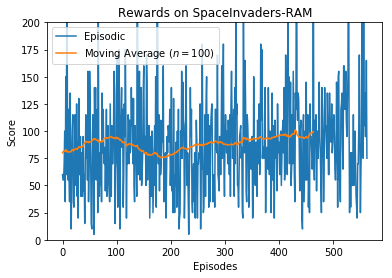

Capped with max_episode_length of 500


In [29]:
rewards = list(reward_queue_spaceinvaders.queue)
t = list(range(len(rewards)))

avg_rewards = moving_average(rewards, n=100)
t_epochs = list(range(len(avg_rewards)))
plt.plot(t, rewards, label="Episodic")
plt.plot(t_epochs, avg_rewards, label="Moving Average ($n=100$)")
plt.legend()
plt.title("Rewards on SpaceInvaders-RAM")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.ylim([0, 200])
plt.show()
print("Capped with max_episode_length of 500")


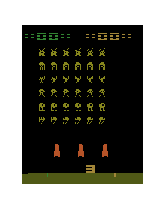
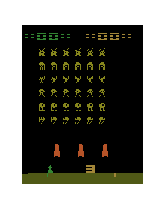
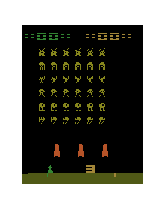
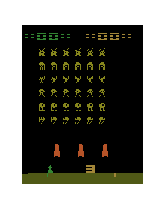
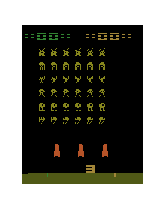
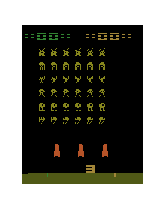
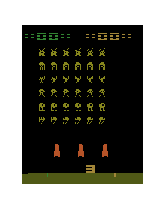
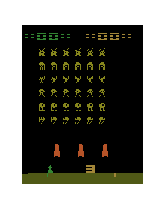
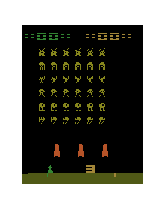
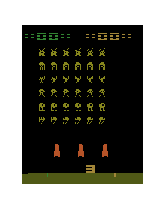
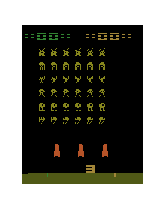
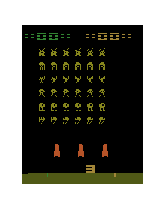
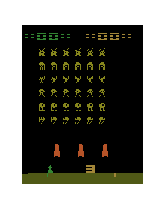
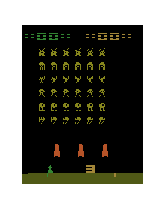
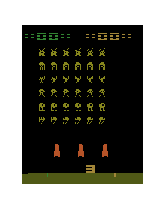
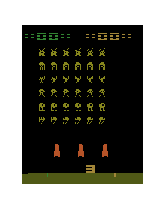
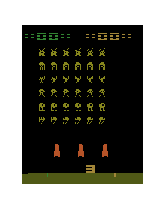
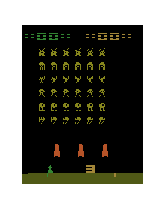
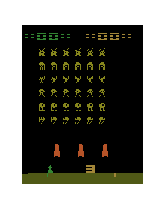
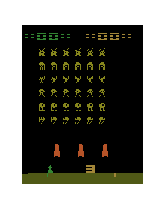
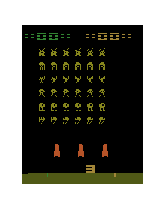
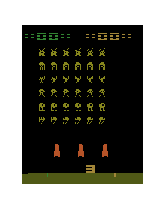
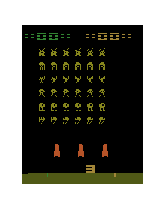
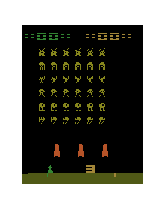
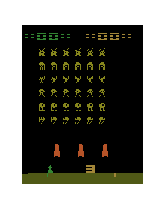
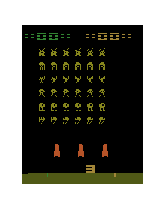
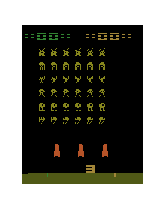
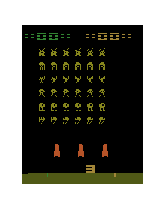
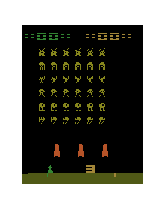
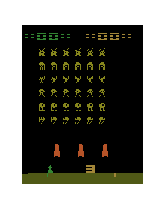
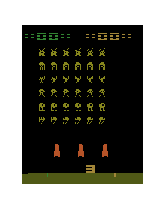
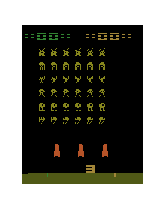
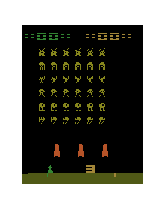
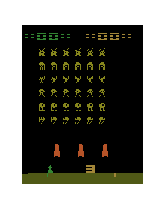
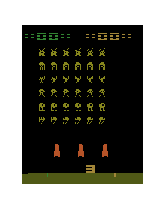
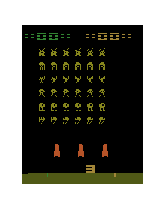
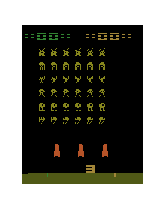
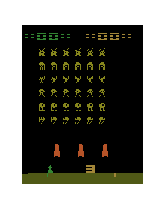
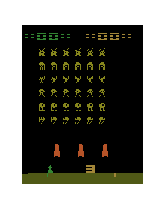
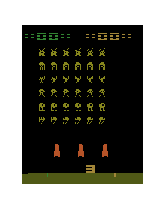
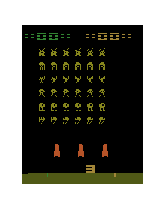
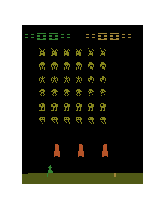
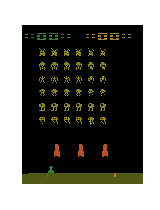
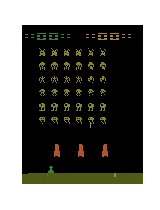
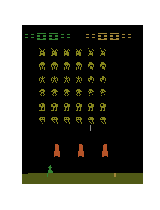
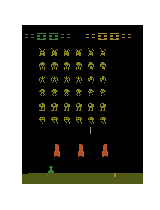
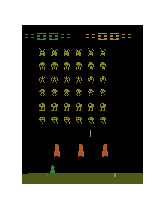
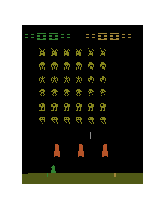
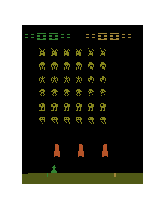
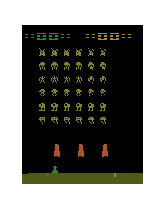
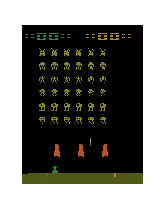
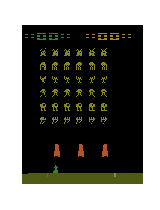
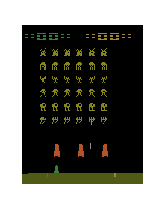
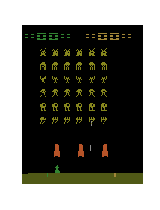
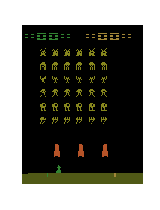
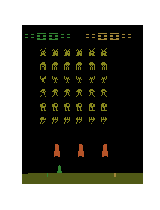
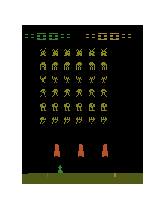
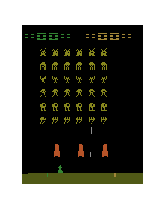
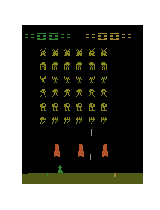
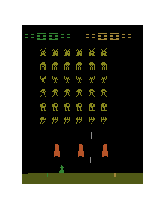
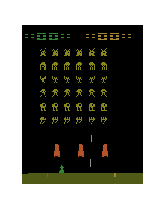
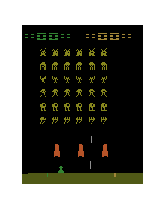
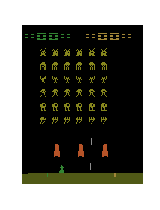
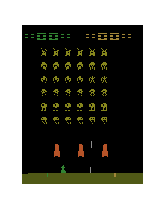
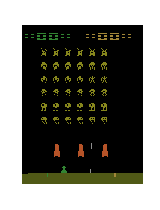
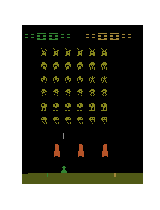
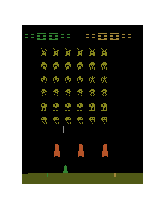
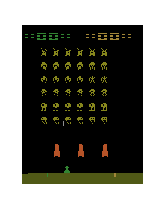
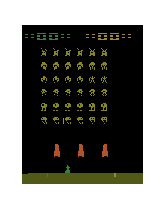
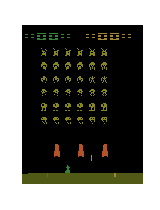
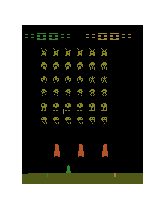
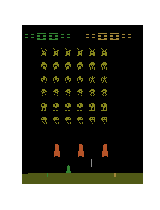
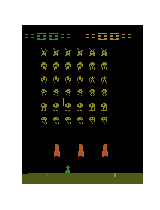
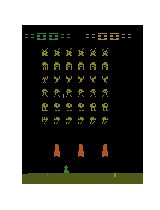
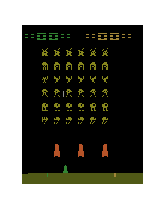
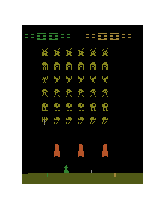
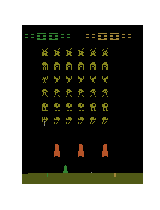
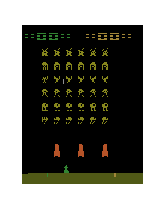
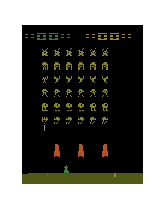
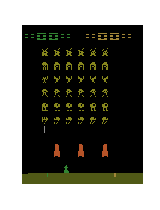
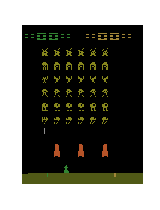
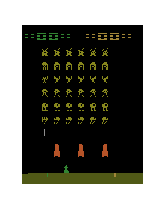
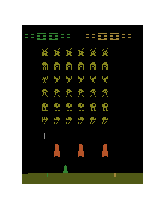
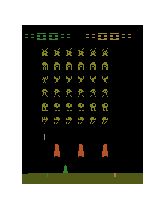
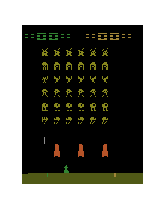
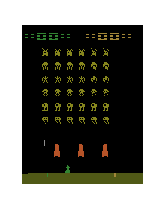
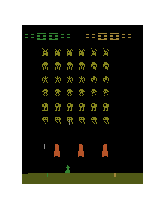
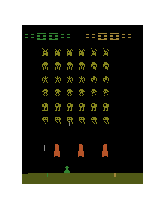
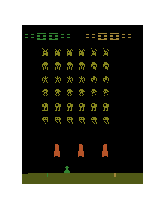
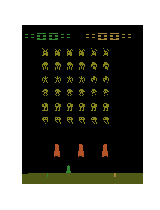
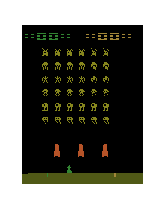
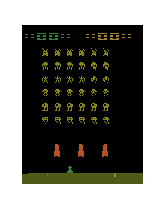
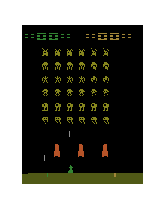
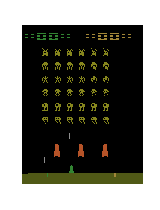
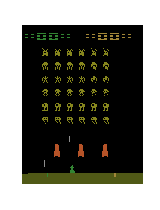
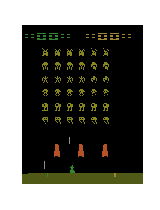
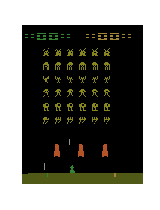
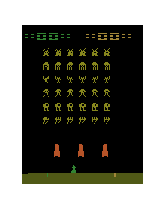
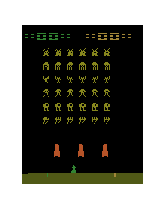
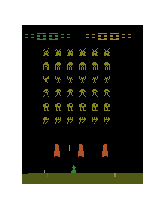
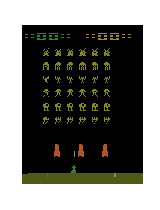
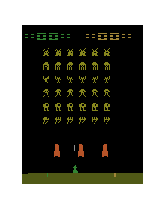
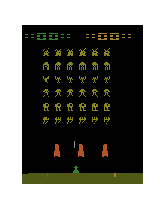
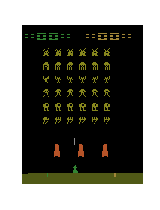
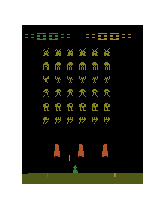
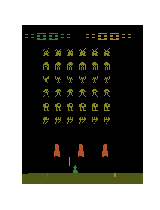
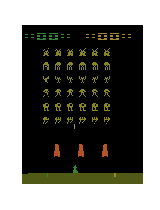
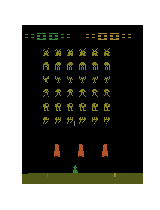
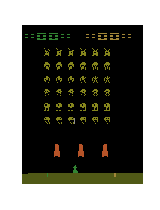
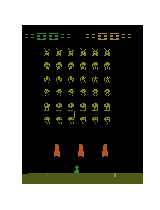
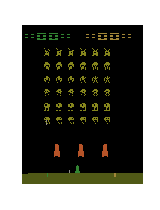
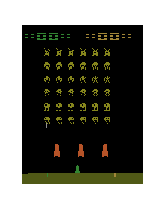
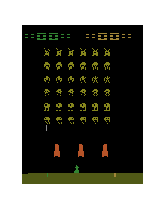
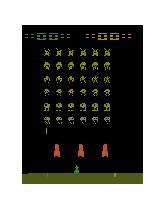
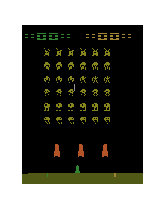
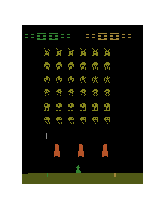
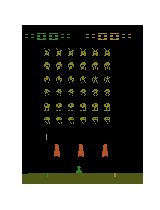
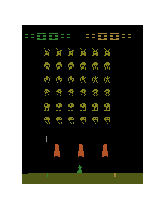
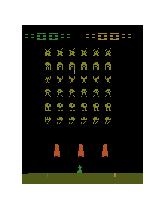
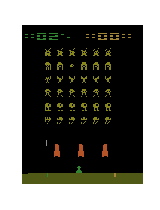
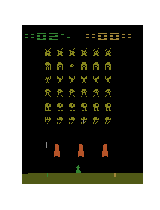
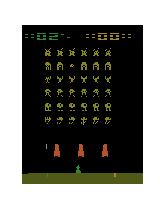
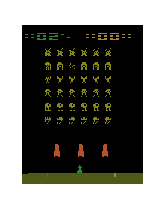
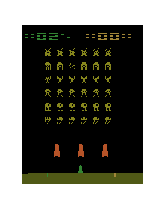
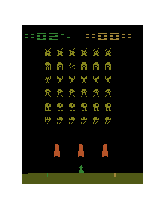
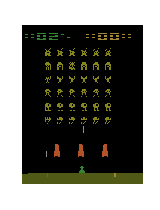
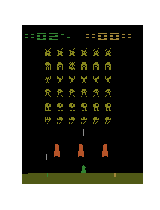
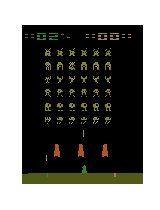
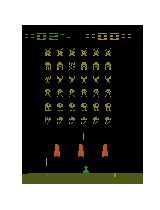
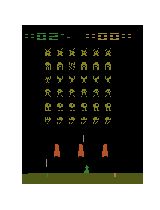
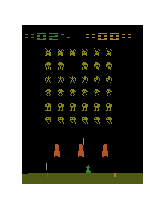
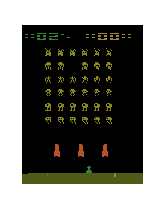
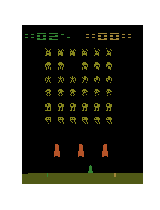
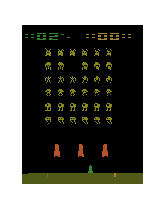
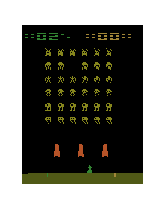
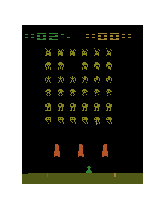
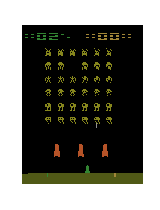
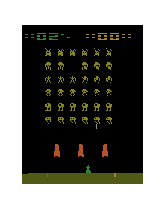
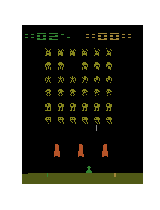
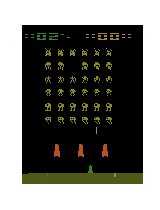
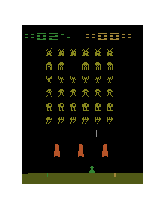
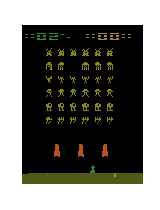
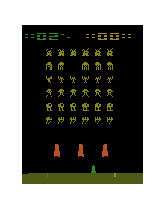
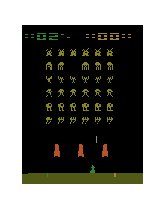
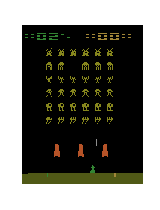
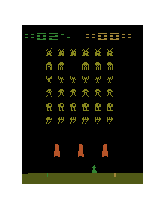
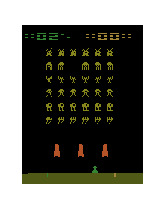
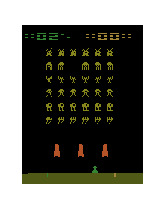
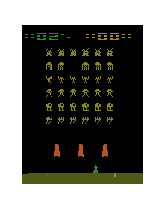
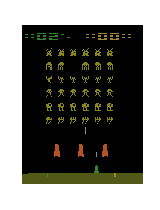
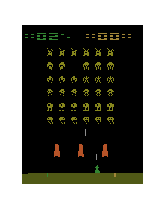
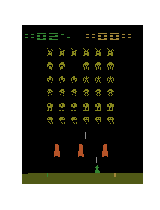
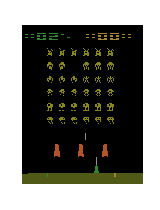
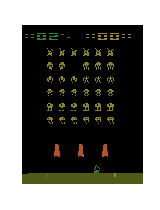
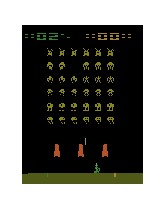
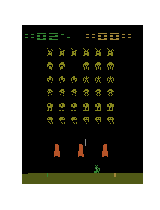
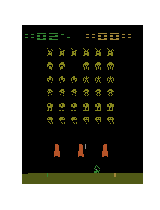
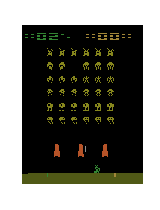
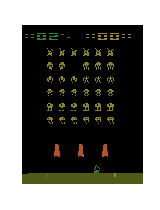
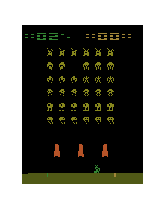
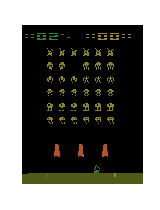
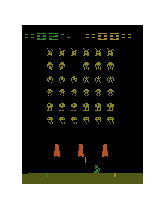
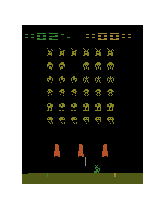
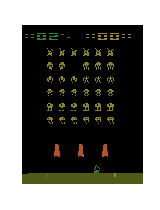
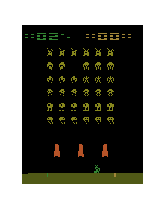
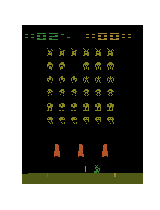
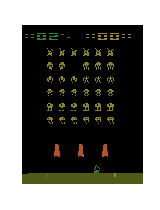
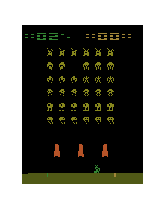
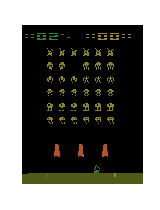
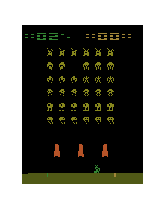
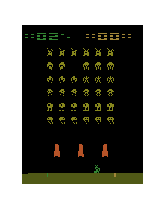
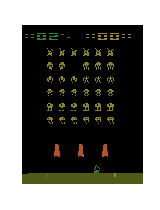
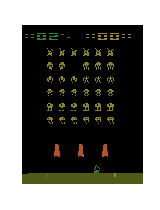
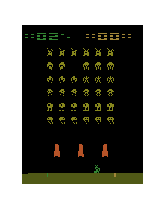
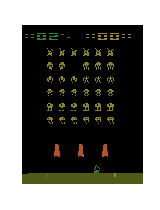
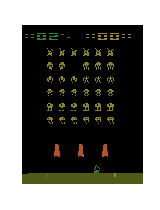
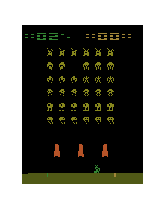
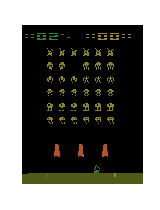
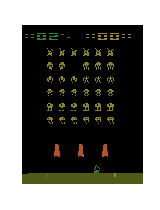
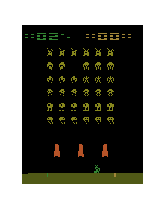
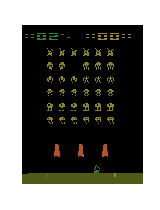
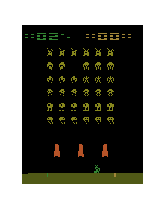
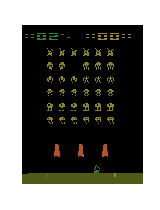
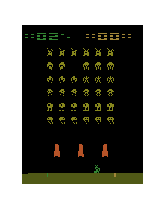
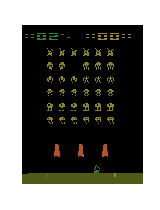
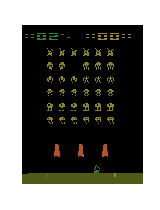
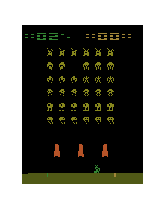
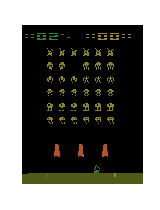
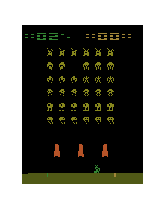
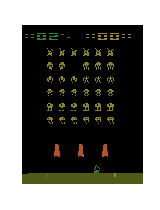
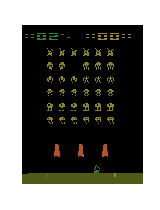
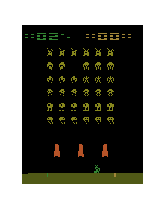
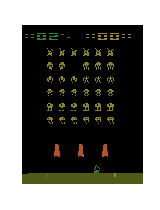
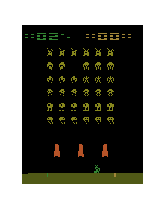
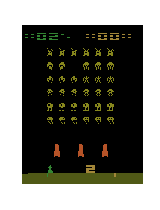
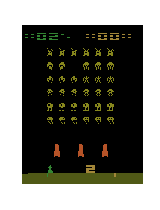
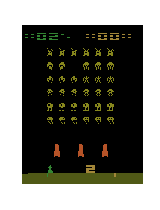
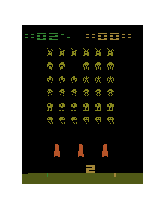
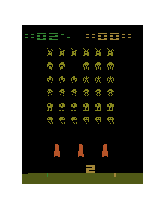
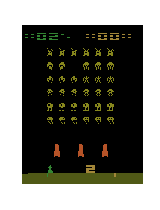
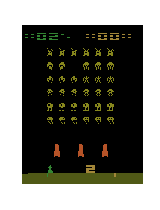
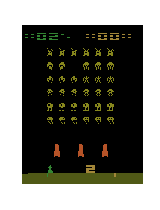
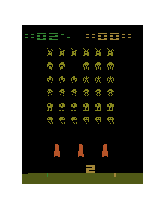
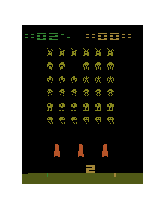
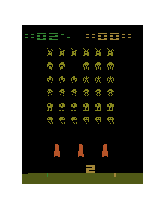
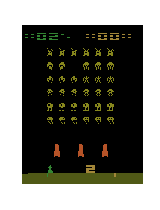
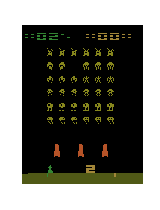
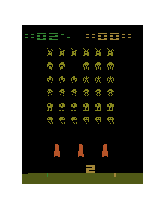
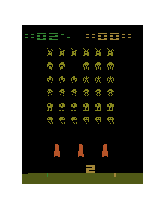
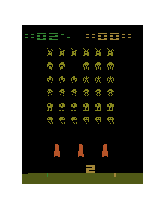
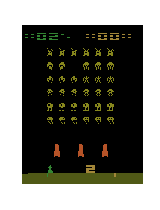
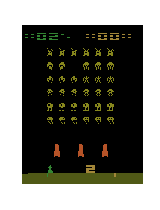
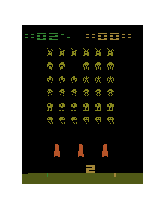
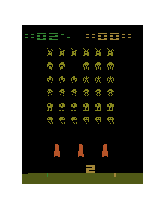
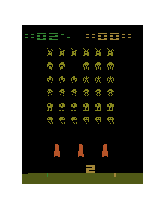
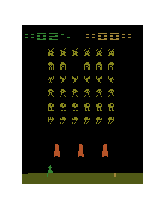
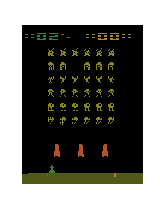
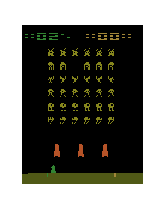
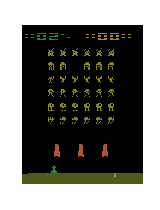
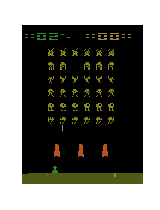
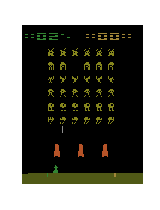
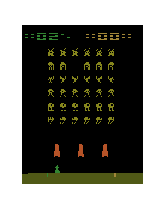
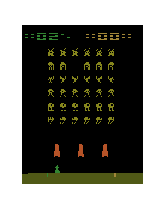
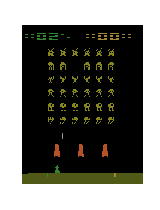
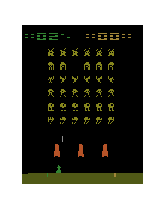
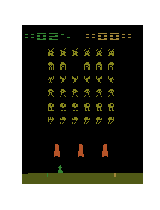
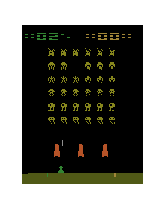
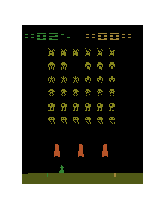
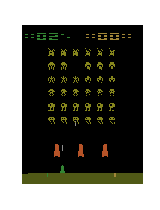
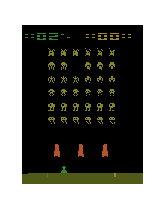
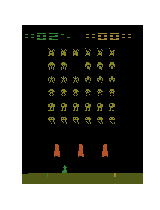
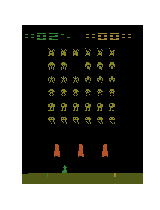
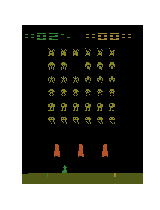
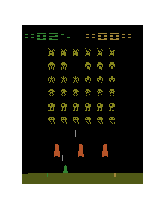
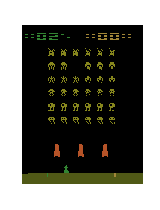
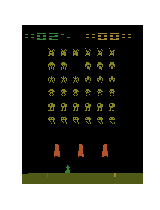
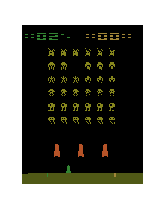
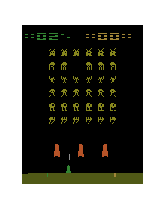
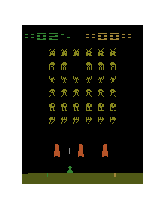
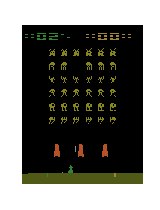
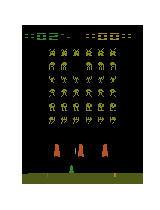
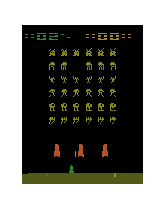
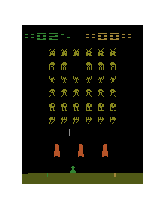
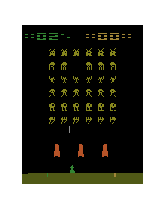
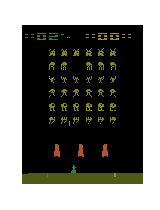
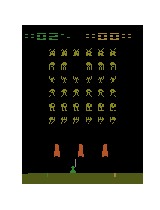
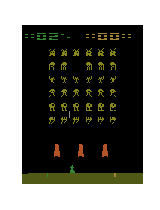
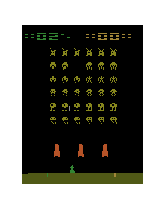
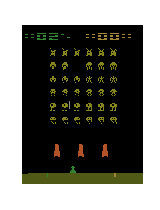
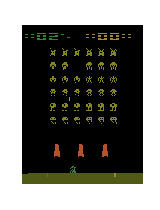
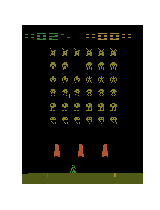
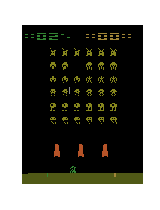
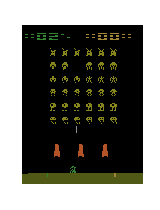
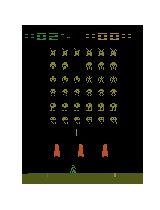
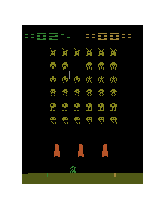
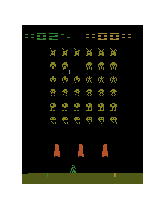
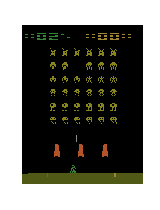
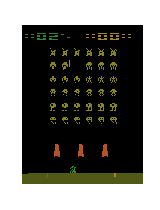
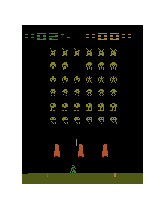
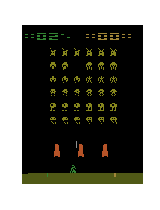
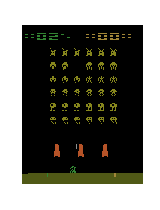
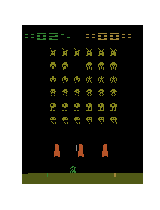
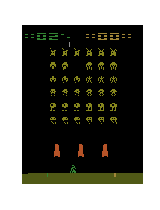
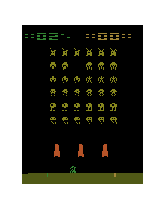
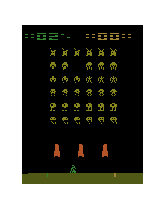
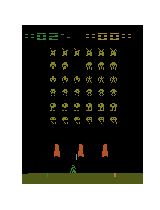
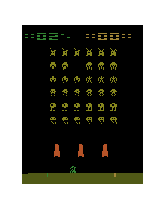
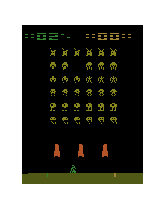
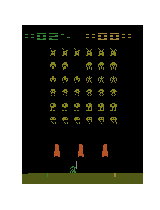
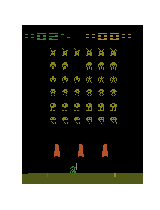
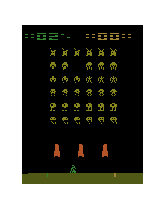
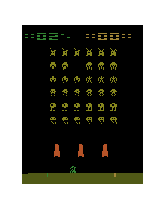
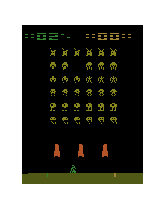
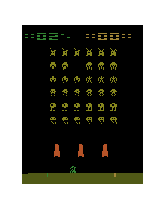
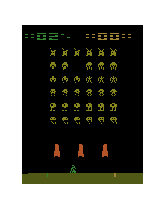
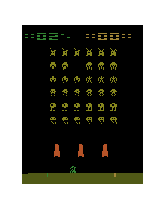
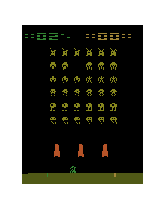
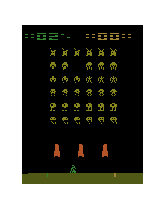
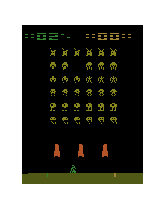
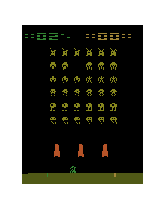
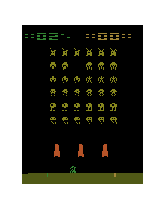
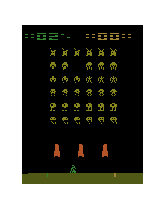
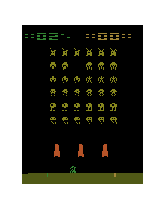
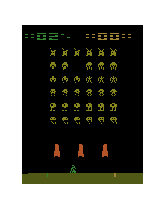
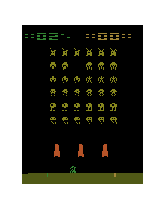
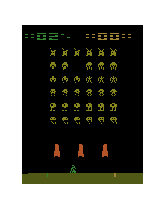
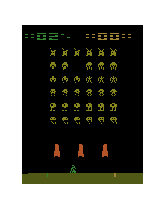
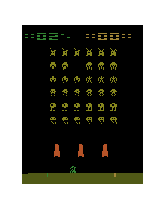
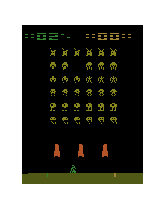
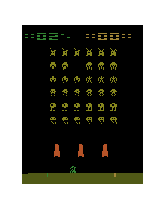
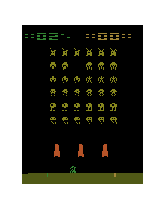
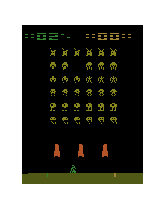
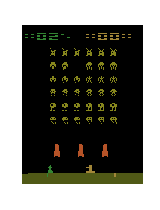
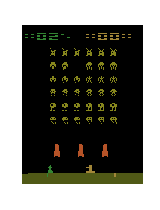
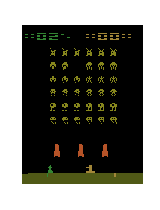
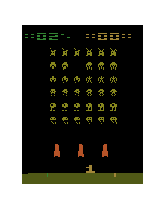
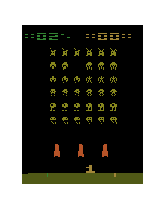
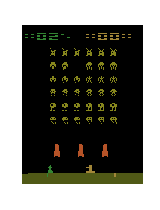
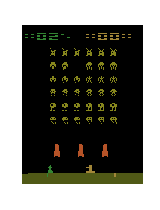
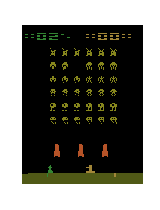
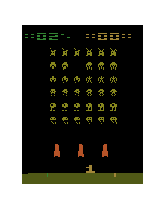
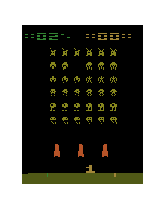
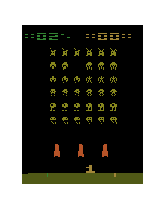
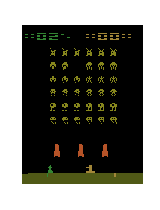
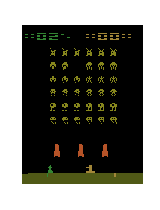
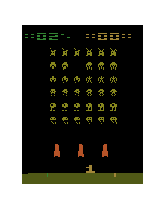
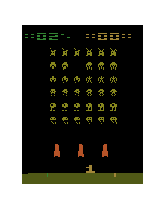
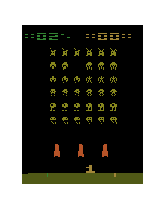
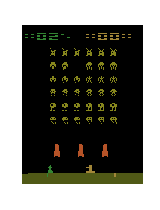
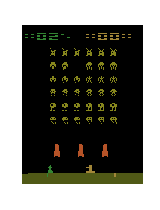
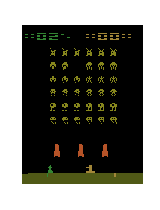
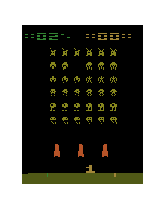
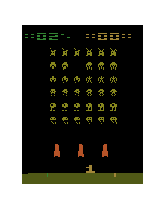
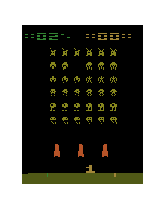
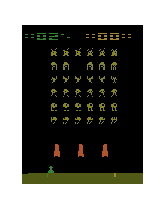
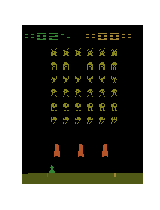
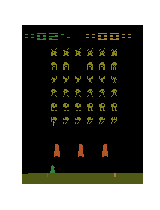
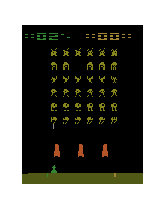
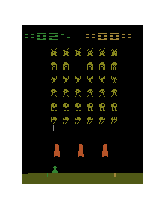
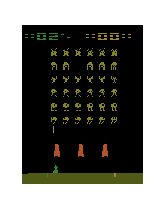
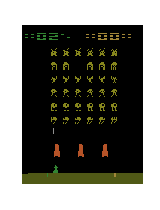
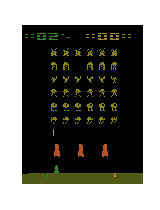
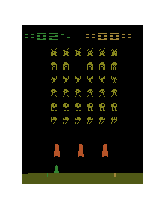
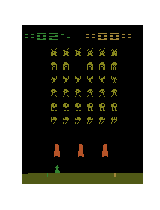
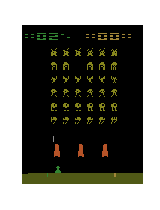
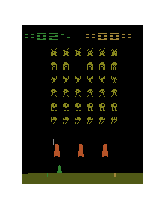
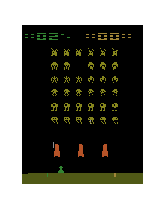
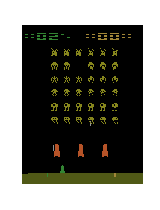
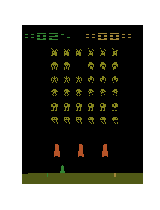
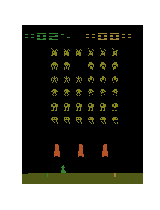
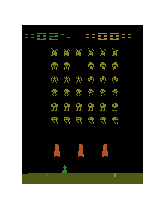
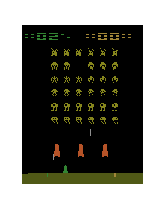
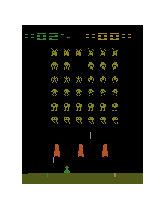
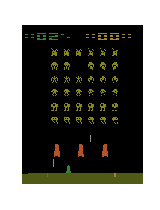
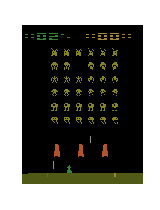
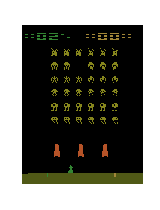
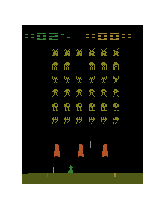
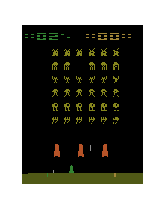
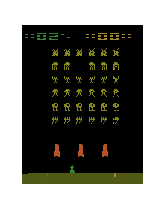
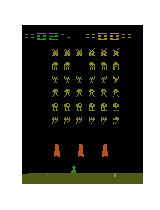
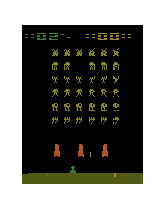
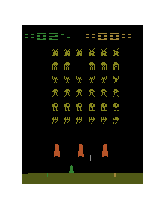
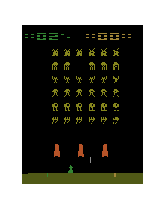
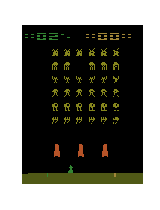
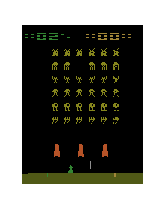
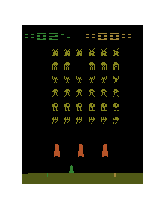
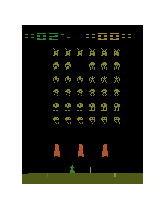
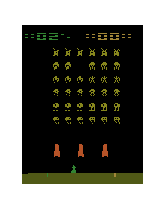
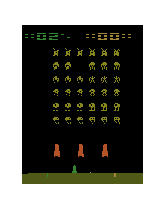
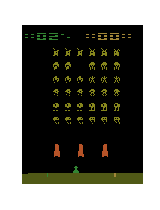
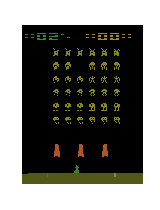
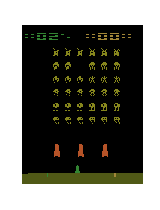
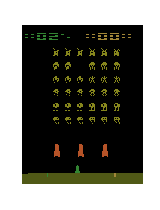
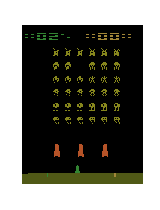
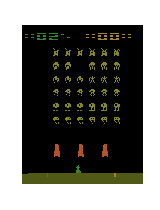
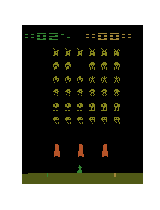
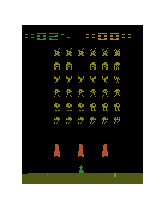
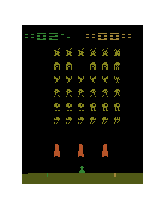
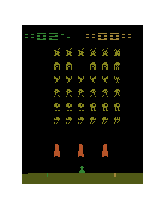
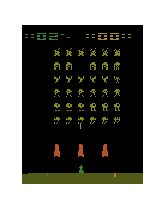
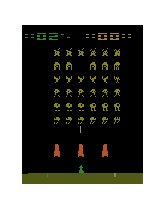
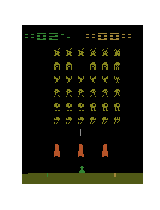
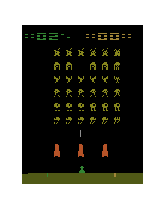
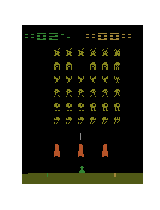
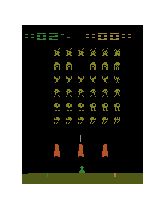
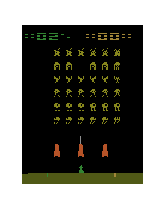
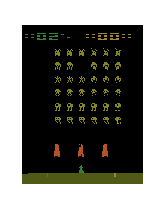
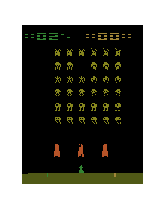
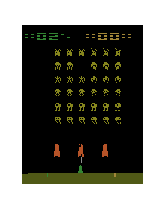
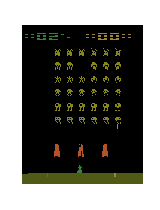
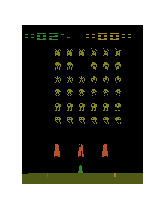
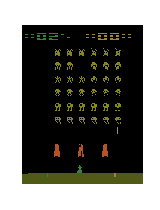
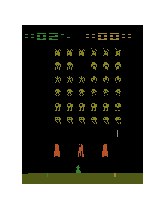
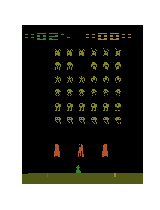
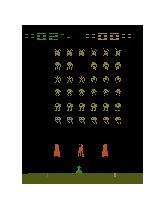
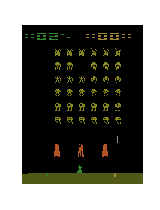
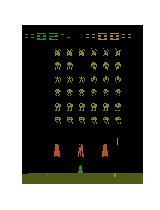
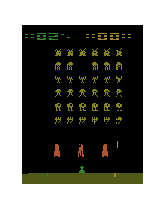
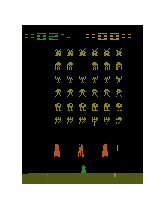
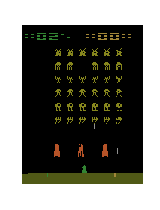
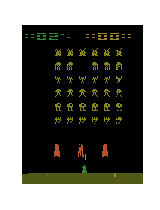
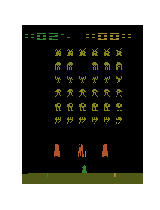
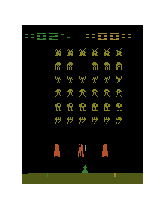
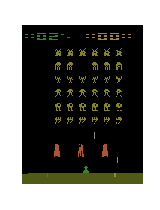
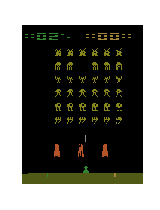
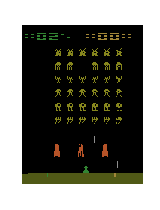
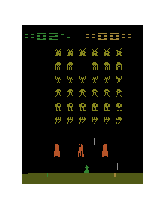
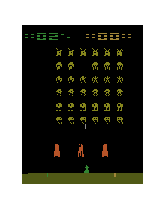
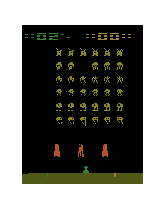
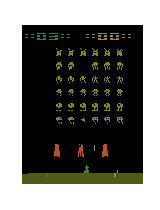
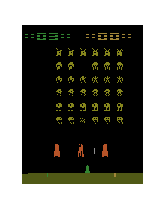
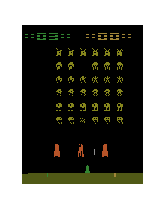
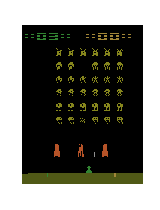
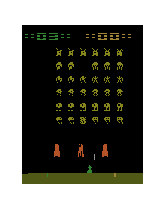
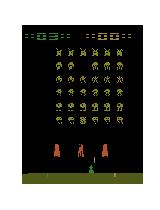
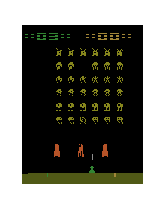
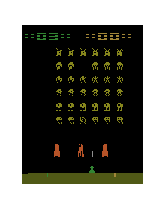
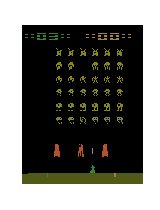
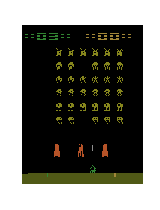
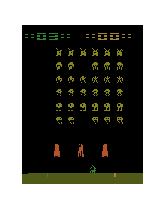
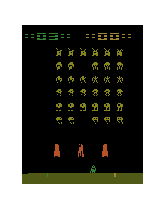
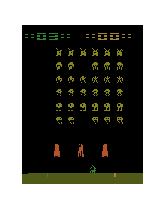
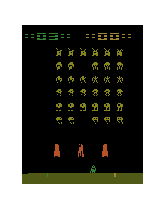
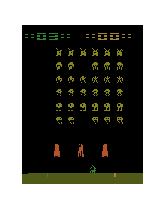
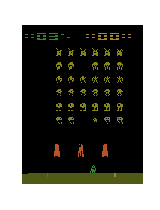
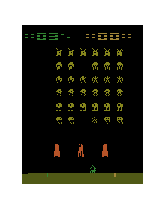
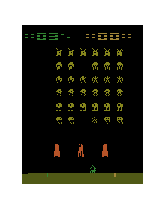
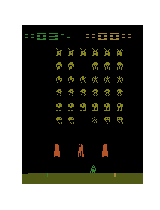
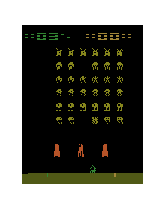
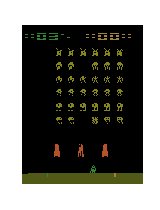
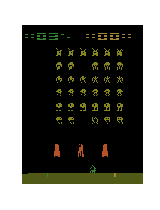
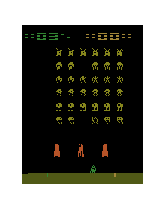
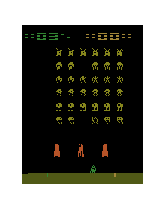
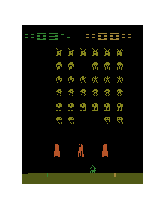
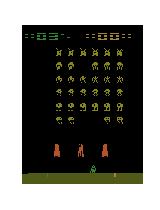
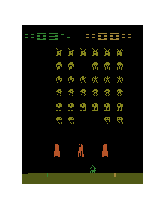
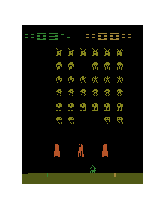
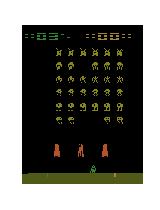
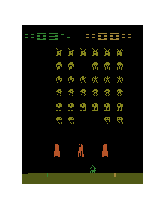
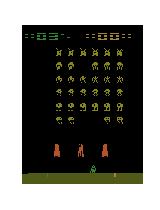
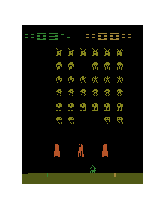
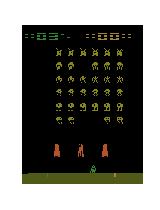
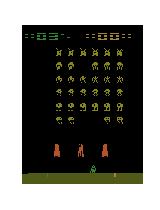
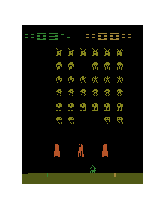
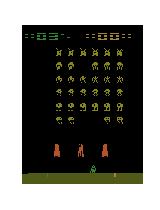
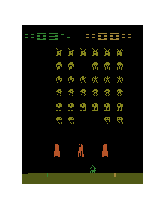
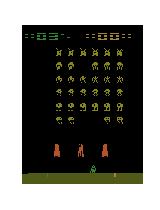
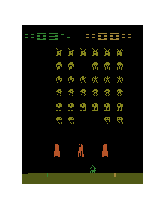
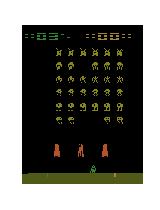
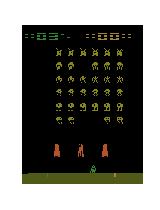
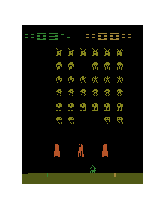
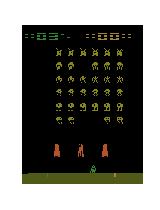
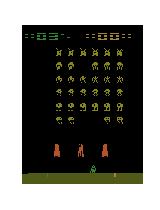
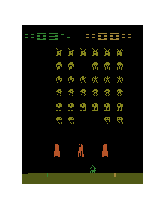
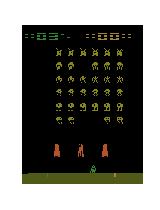
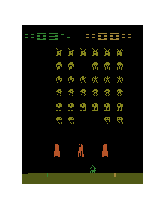
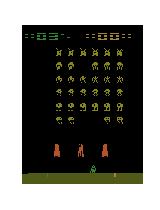

In [30]:
show_game(env_spaceinvaders, policy_spaceinvaders, embedding_spaceinvaders)

## CartPole

In [20]:
env_cartpole = gym.make('CartPole-v0')
n_state_size = 4
n_embedding_size = 4
n_action_size = 2 
max_episode_length = 200

n_epochs = 20
n_episodes = 100
device = 'cpu'
embedding_cartpole = None
policy_cartpole = PolicyNetwork(n_embedding_size, n_action_size).to(device)
value_cartpole = ValueNetwork(n_embedding_size).to(device)
reward_queue_cartpole = Queue()
main(env_cartpole, embedding_cartpole, policy_cartpole, value_cartpole, device, 
     reward_queue_cartpole, n_epochs, n_episodes, max_episode_length)
print("done")

avg reward: 21.010, value loss: 206.896, policy loss: -11.987:   5%|▌         | 1/20 [00:00<00:09,  1.94it/s]

avg reward: 22.350, value loss: 233.097, policy loss: -12.473:  10%|█         | 2/20 [00:01<00:09,  1.86it/s]

avg reward: 22.980, value loss: 279.921, policy loss: -12.980:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

avg reward: 26.080, value loss: 310.064, policy loss: -13.347:  20%|██        | 4/20 [00:02<00:09,  1.69it/s]

avg reward: 29.530, value loss: 320.475, policy loss: -12.712:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

avg reward: 40.650, value loss: 481.774, policy loss: -13.595:  30%|███       | 6/20 [00:04<00:10,  1.34it/s]

avg reward: 64.200, value loss: 400.808, policy loss: -5.252:  35%|███▌      | 7/20 [00:05<00:12,  1.04it/s] 

avg reward: 97.640, value loss: 442.479, policy loss: -0.516:  40%|████      | 8/20 [00:07<00:16,  1.35s/it]

avg reward: 139.450, value loss: 353.911, policy loss: -0.143:  45%|████▌     | 9/20 [00:10<00:20,  1.89s/it]

avg reward: 156.210, value loss: 330.992, policy loss: 0.318:  50%|█████     | 10/20 [00:14<00:24,  2.43s/it]

avg reward: 181.170, value loss: 334.187, policy loss: -0.118:  55%|█████▌    | 11/20 [00:19<00:27,  3.00s/it]

avg reward: 191.990, value loss: 299.893, policy loss: -0.167:  60%|██████    | 12/20 [00:23<00:28,  3.51s/it]

avg reward: 191.560, value loss: 351.437, policy loss: -0.089:  65%|██████▌   | 13/20 [00:28<00:26,  3.79s/it]

avg reward: 193.540, value loss: 261.085, policy loss: -0.014:  70%|███████   | 14/20 [00:32<00:24,  4.06s/it]

avg reward: 197.230, value loss: 340.678, policy loss: -0.195:  75%|███████▌  | 15/20 [00:37<00:21,  4.35s/it]

avg reward: 195.900, value loss: 312.094, policy loss: 0.053:  80%|████████  | 16/20 [00:42<00:18,  4.51s/it] 

avg reward: 198.740, value loss: 308.000, policy loss: 0.127:  85%|████████▌ | 17/20 [00:47<00:13,  4.62s/it]

avg reward: 194.740, value loss: 219.841, policy loss: 0.025:  90%|█████████ | 18/20 [00:52<00:09,  4.69s/it]

avg reward: 197.620, value loss: 297.884, policy loss: 0.143:  95%|█████████▌| 19/20 [00:57<00:04,  4.68s/it]

avg reward: 198.890, value loss: 246.903, policy loss: 0.016: 100%|██████████| 20/20 [01:02<00:00,  4.76s/it]


done


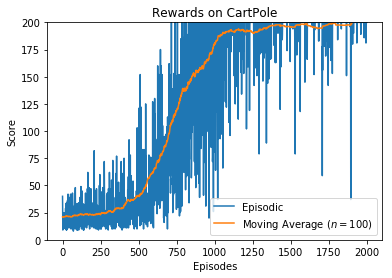


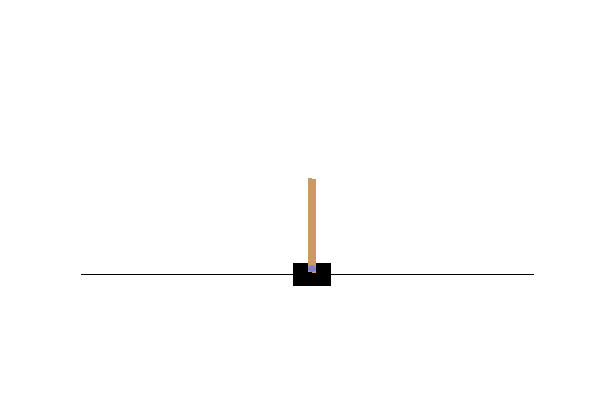
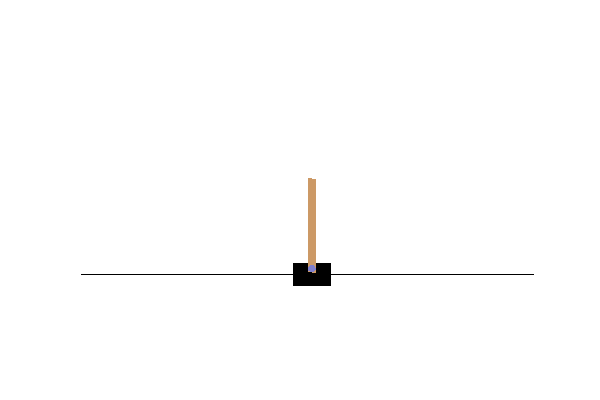
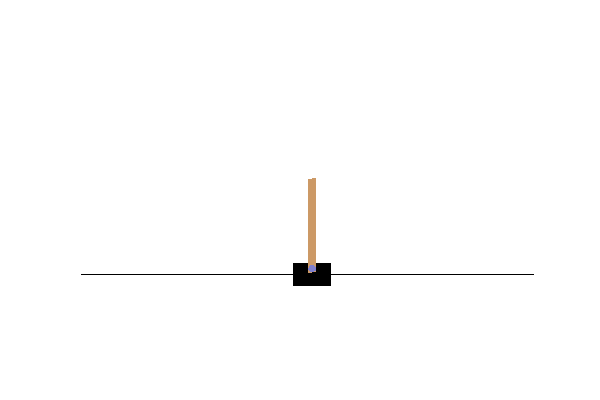
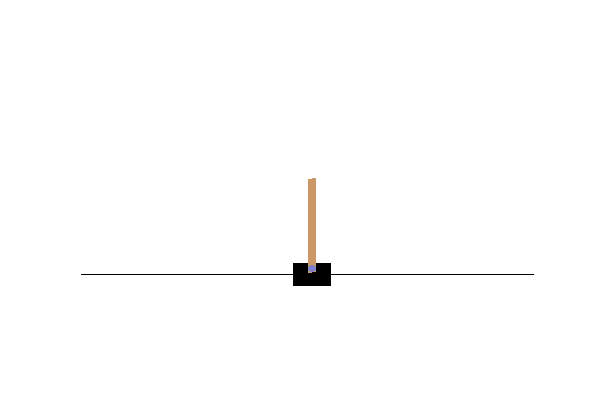
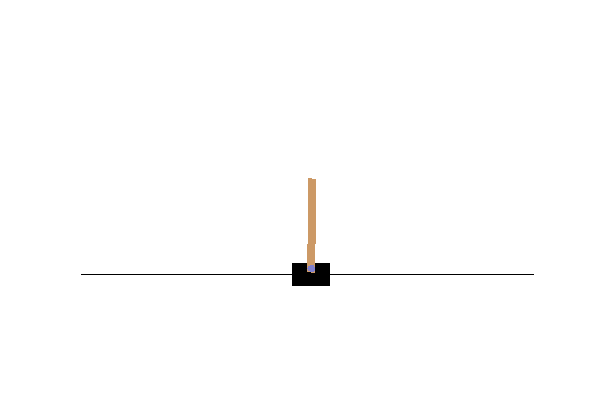
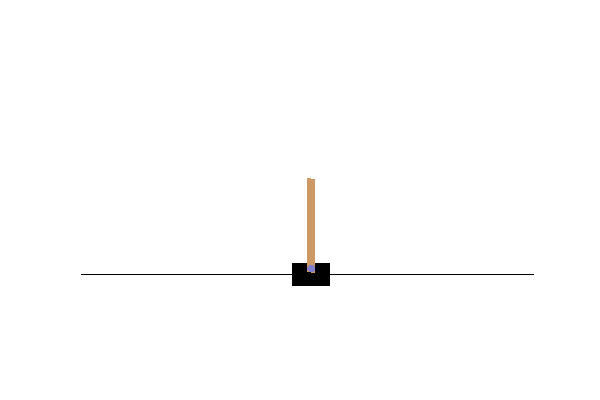
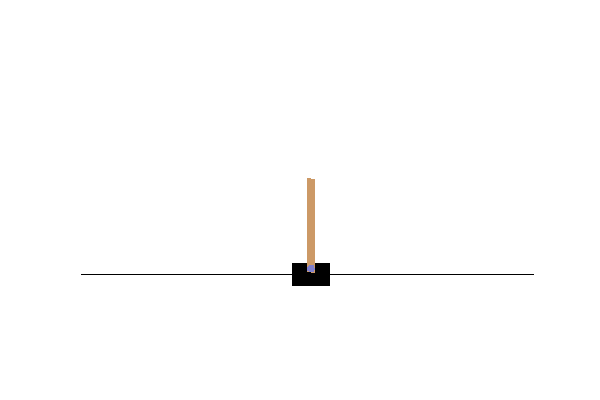
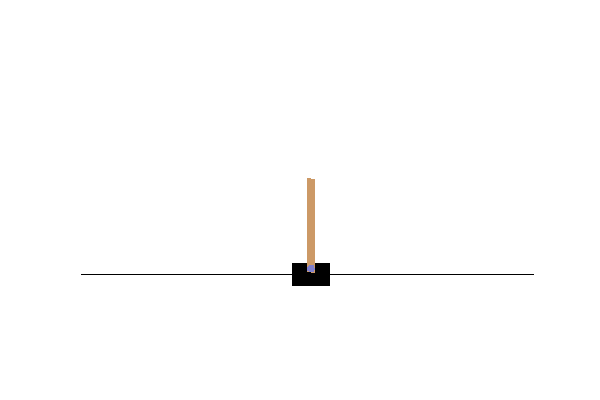
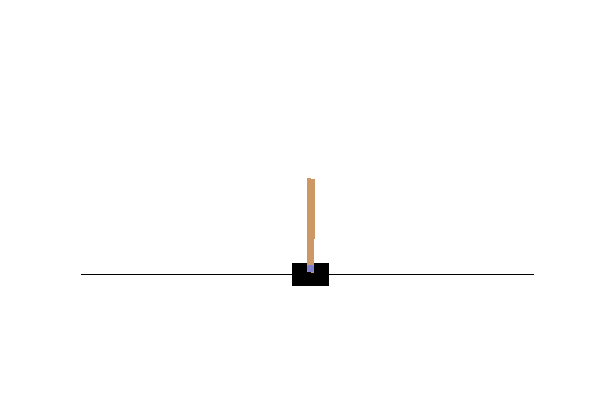
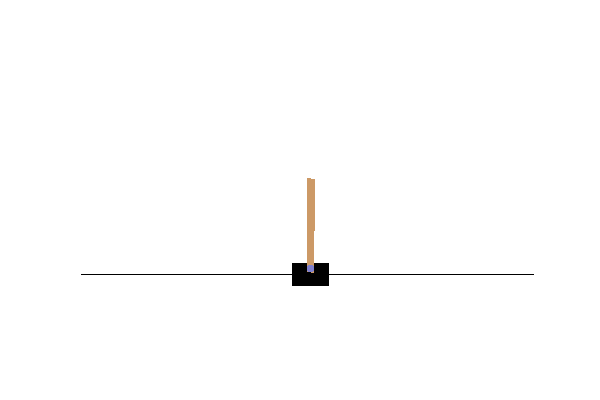
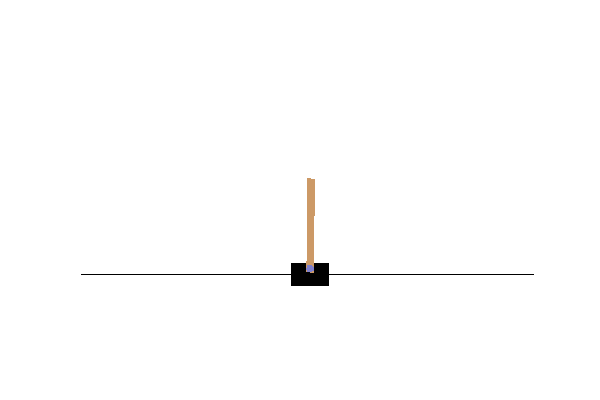
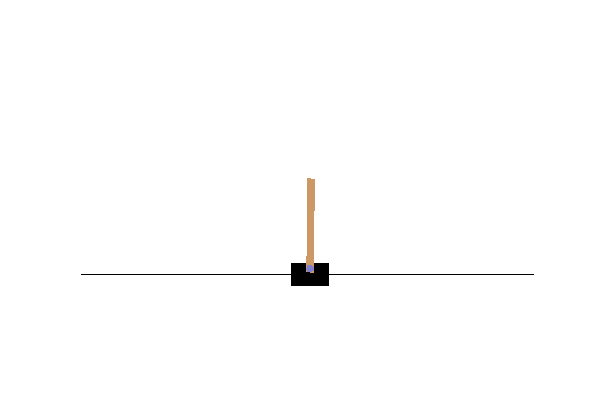
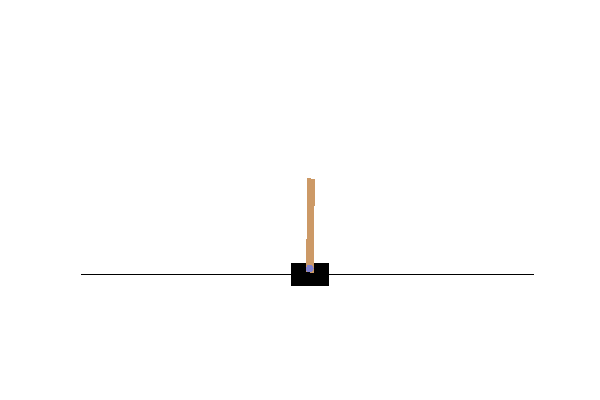
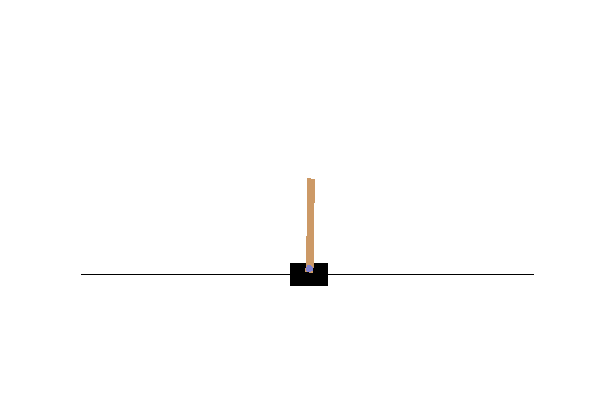
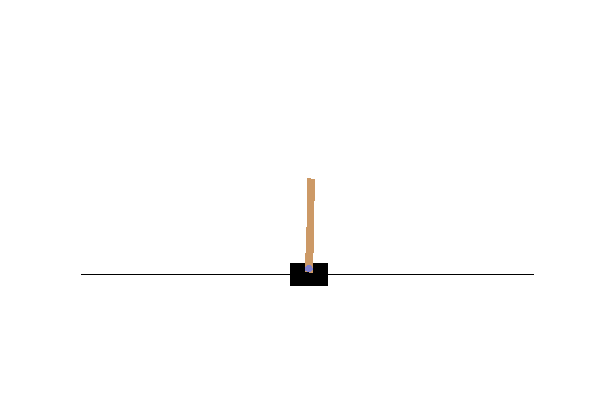
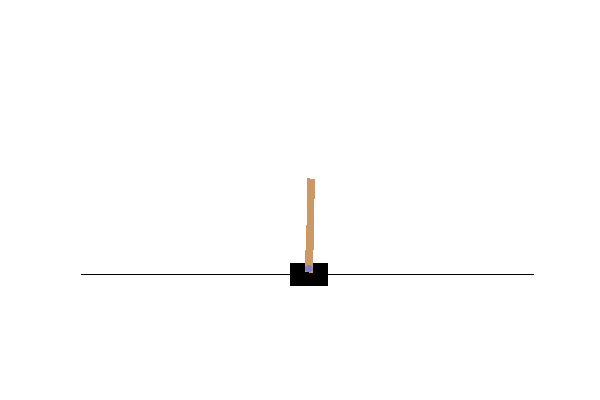
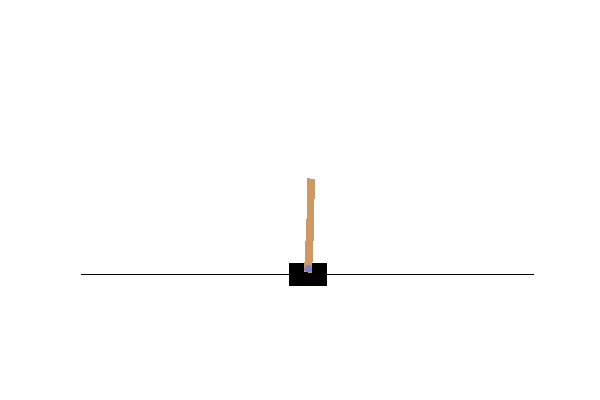
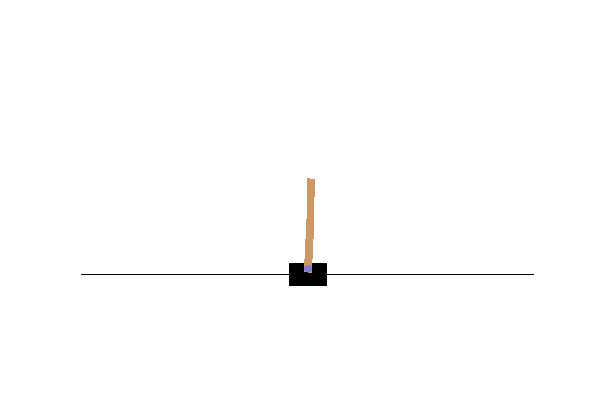
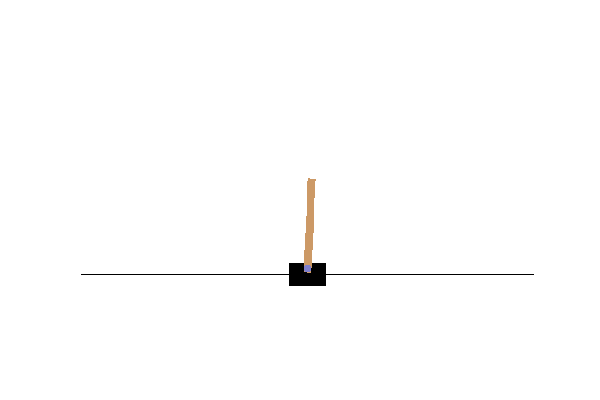
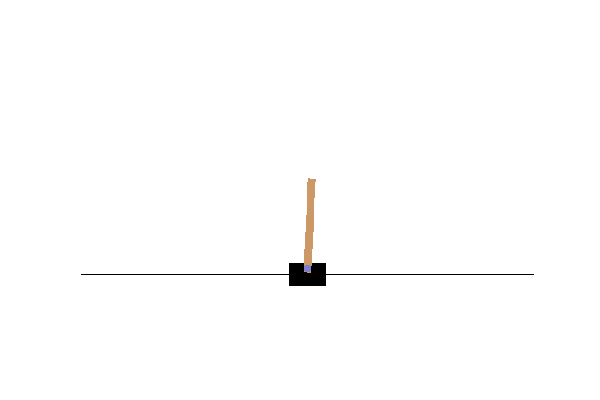
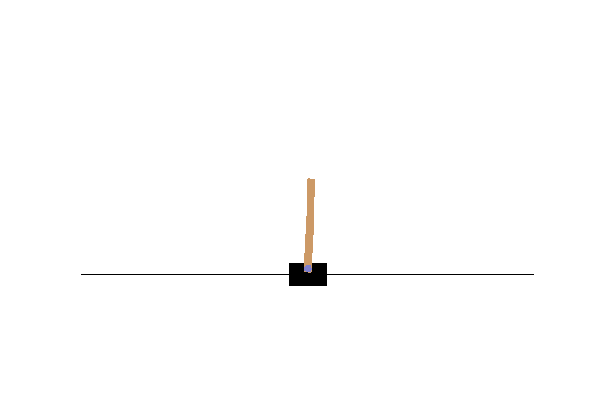
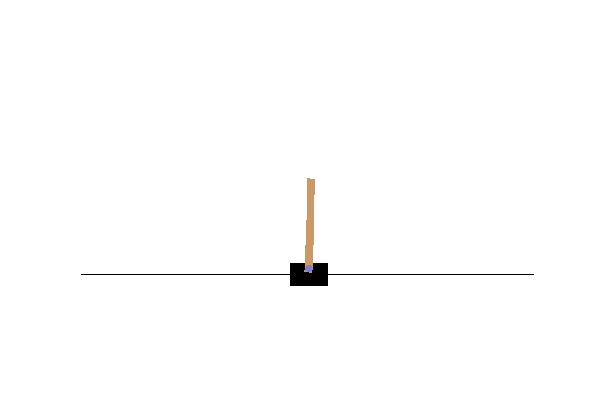
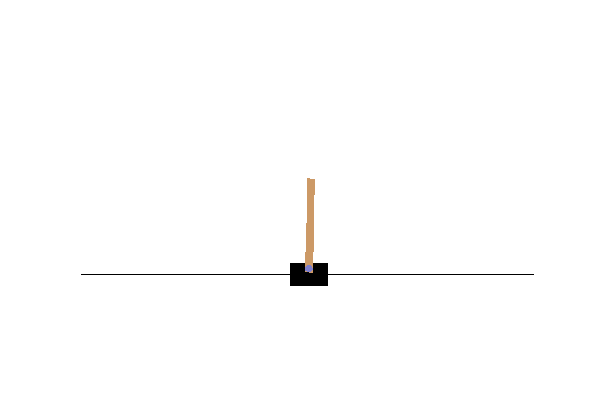
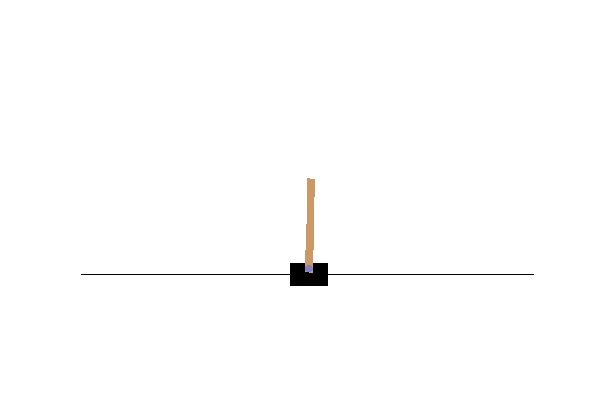
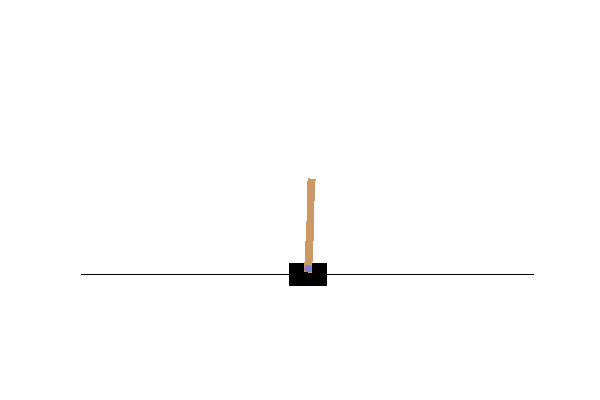
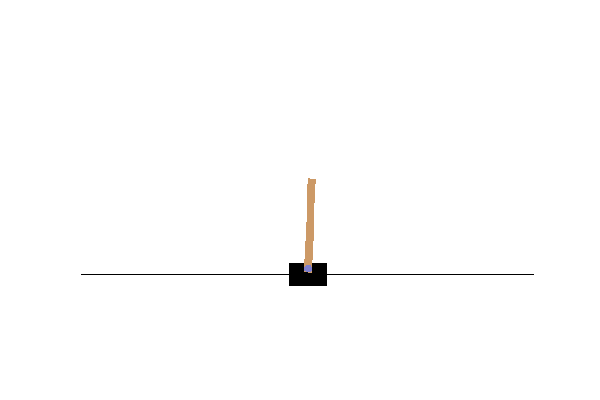
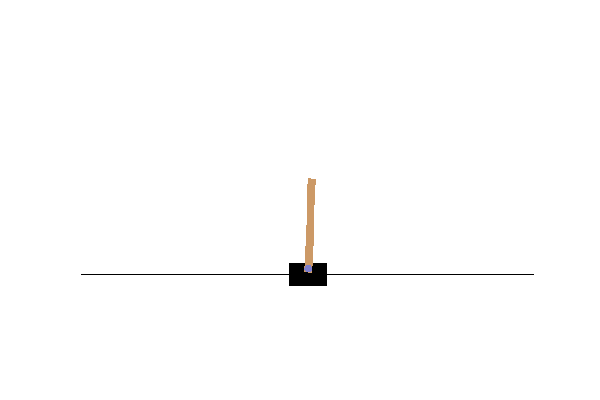
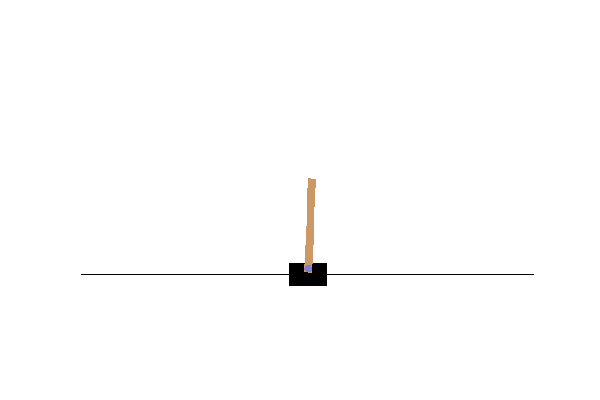
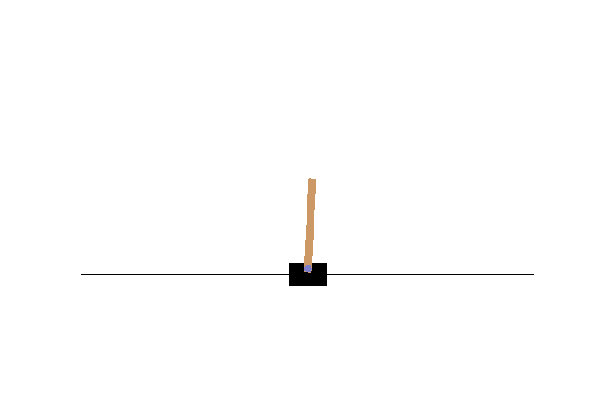
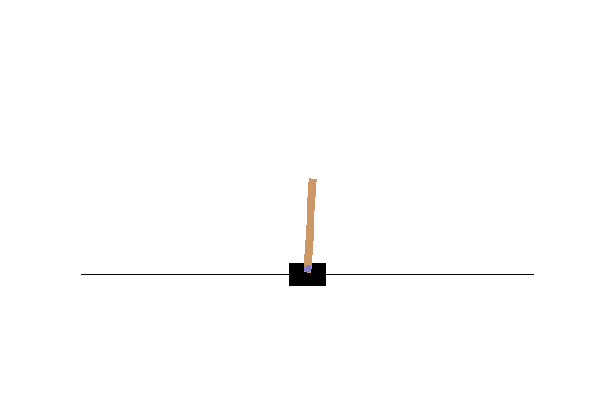
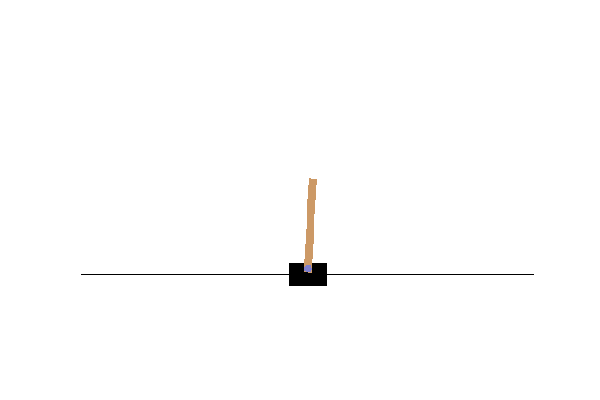
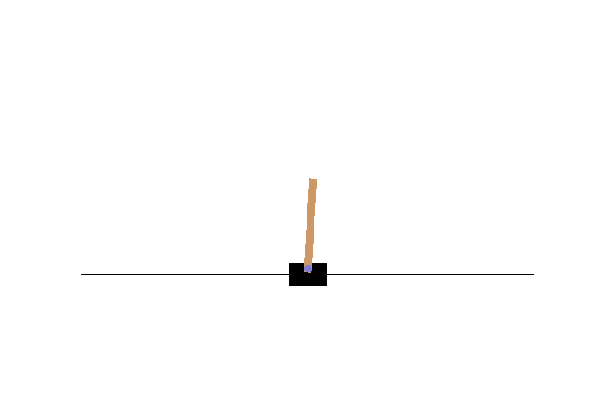
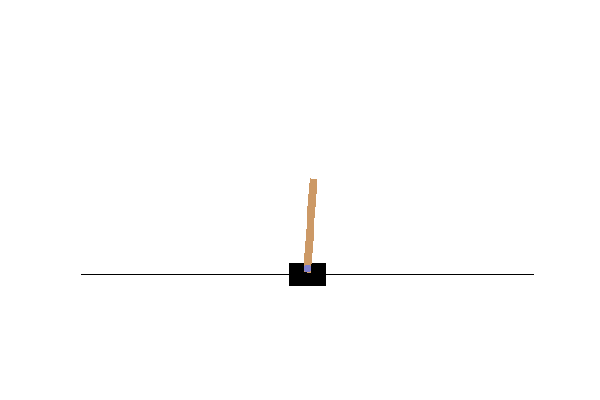
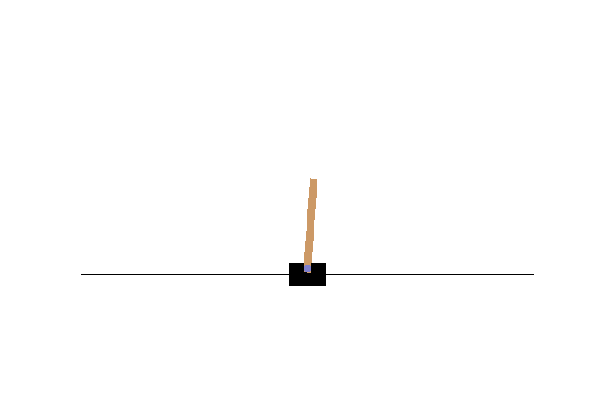
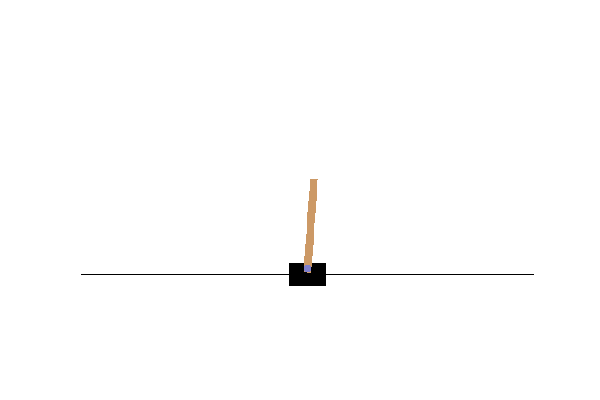
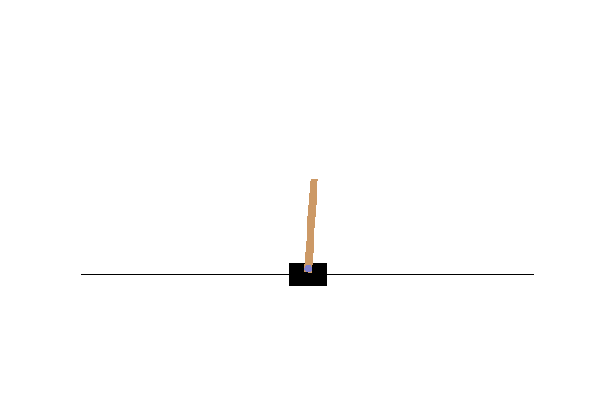
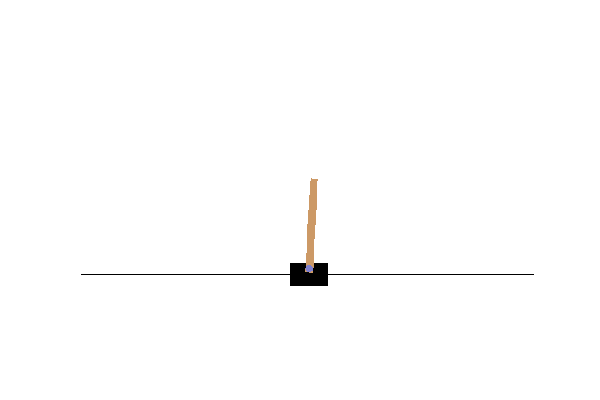
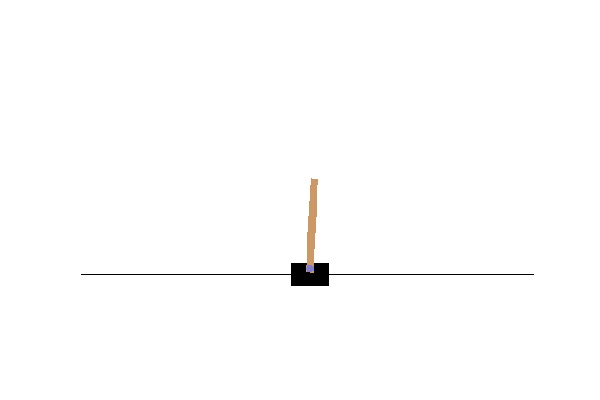
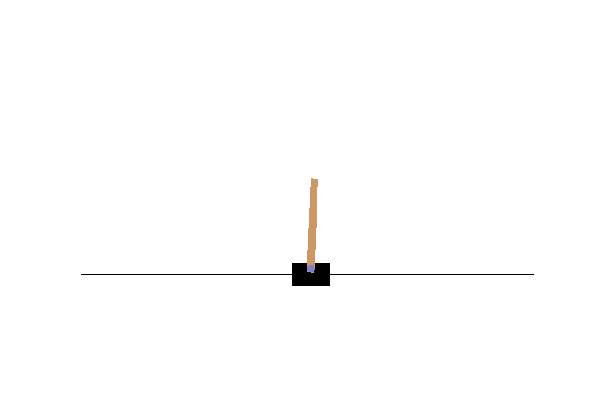
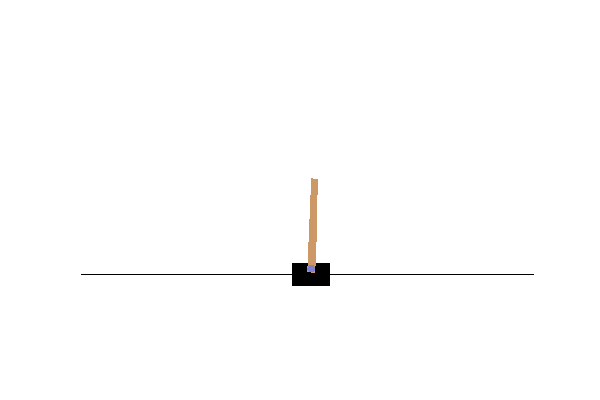
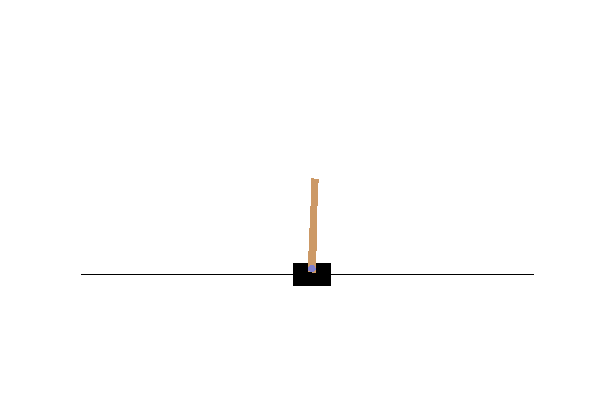
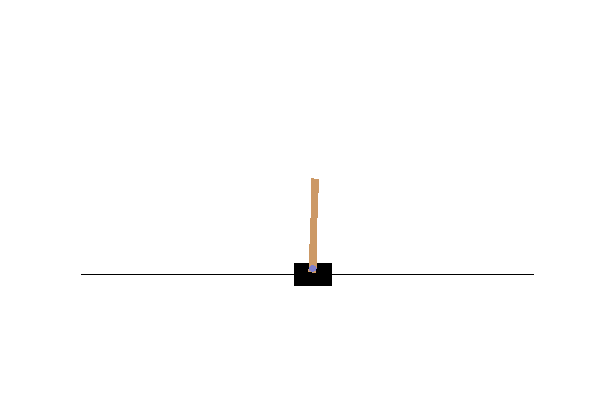
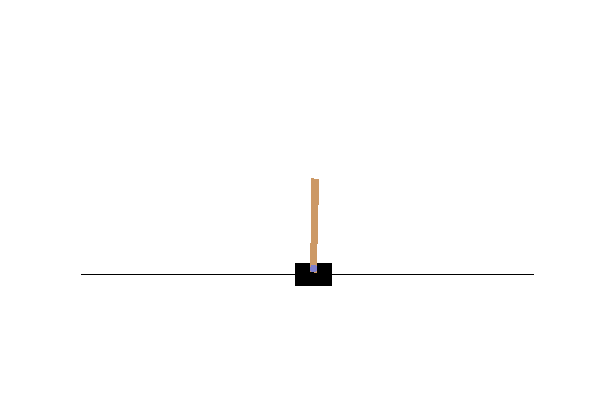
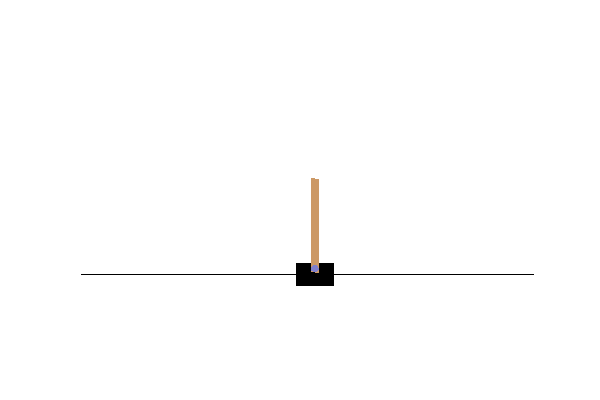
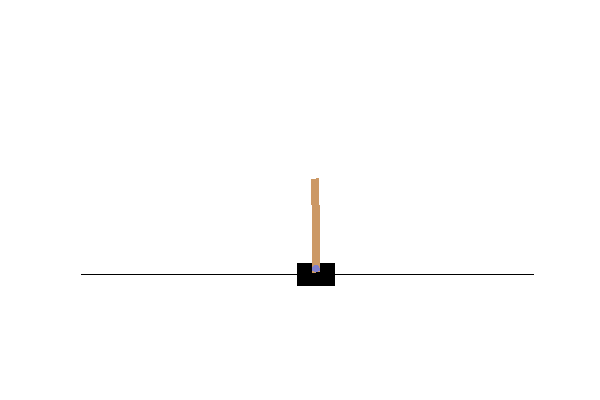
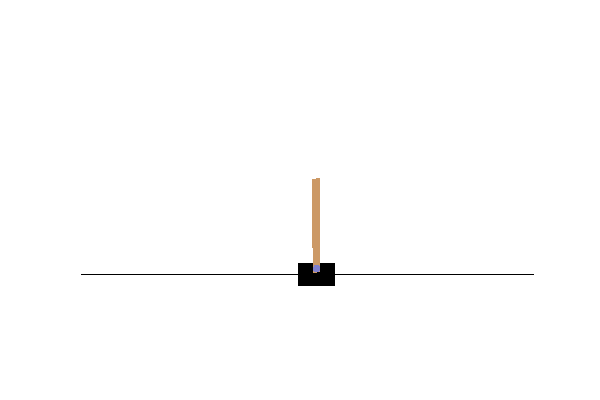
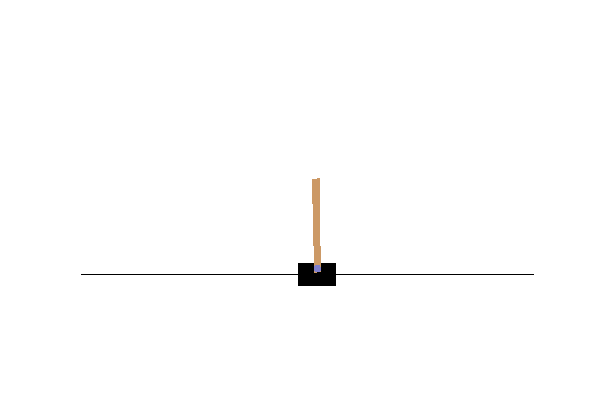
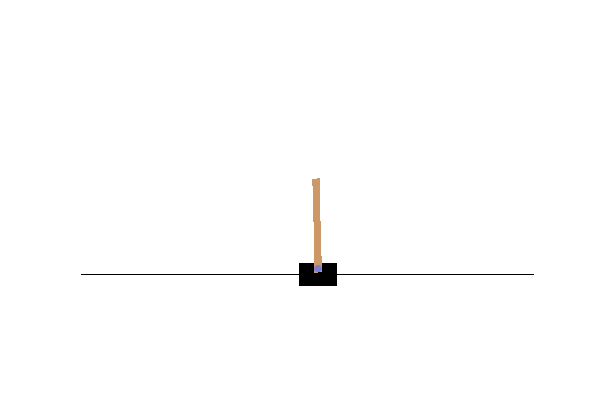
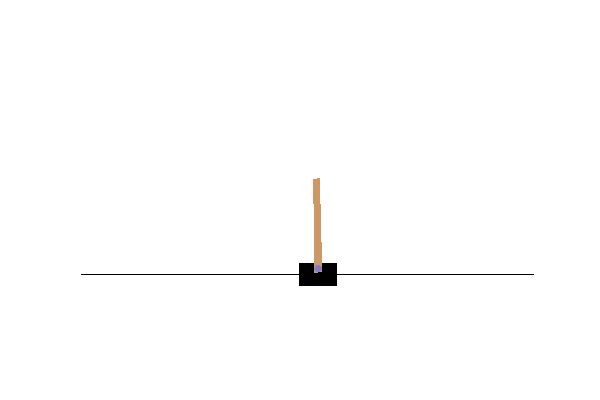
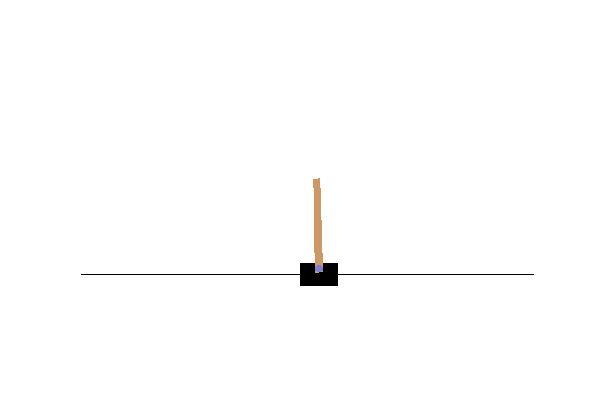
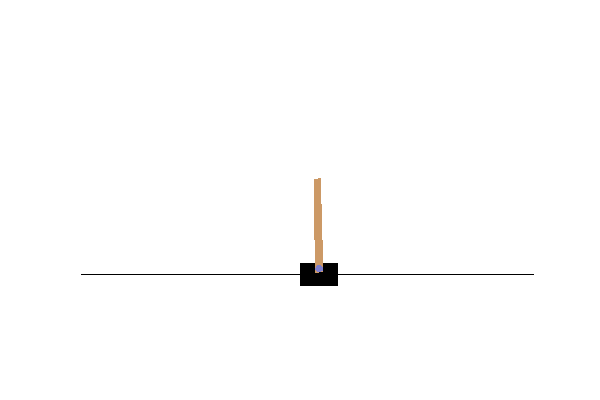
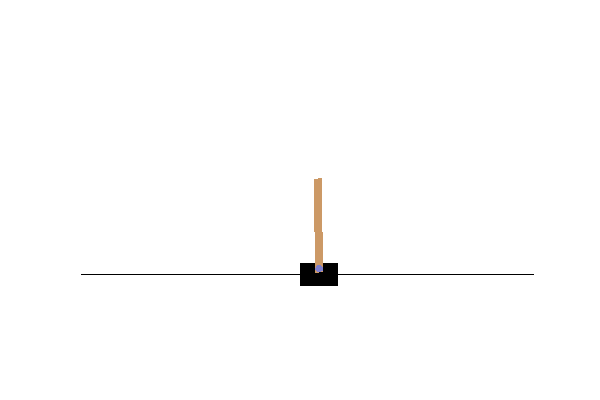
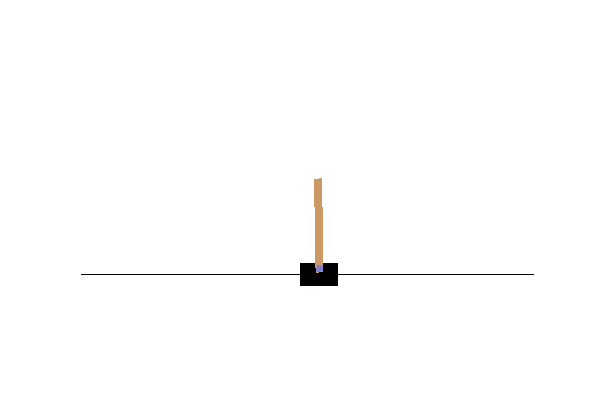
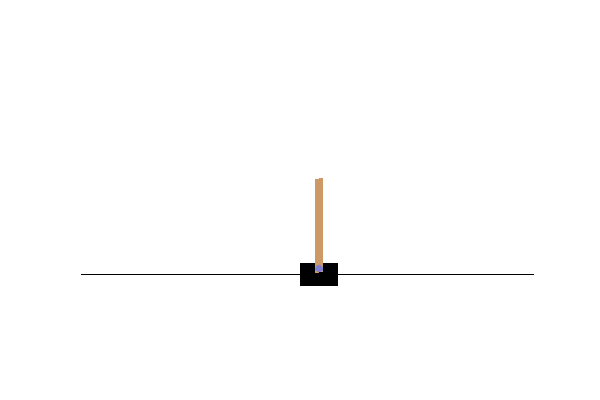
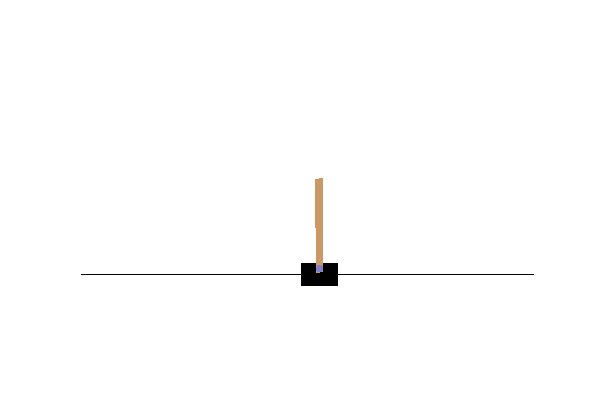
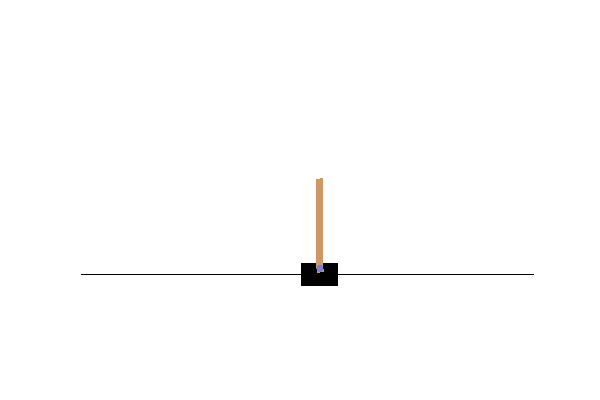
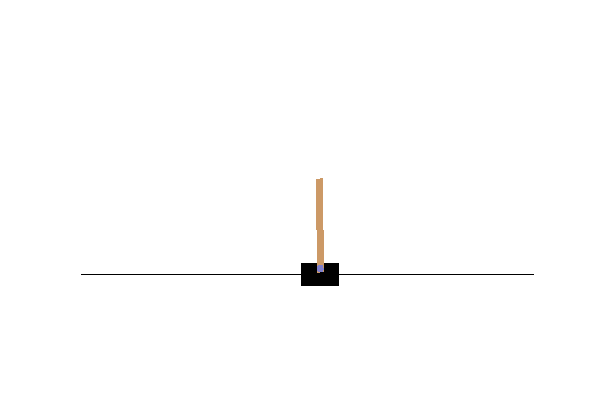
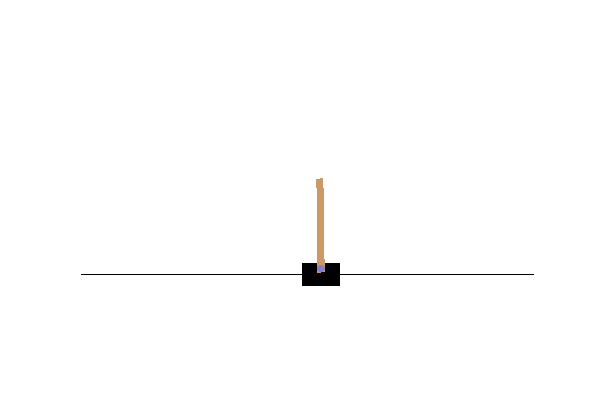
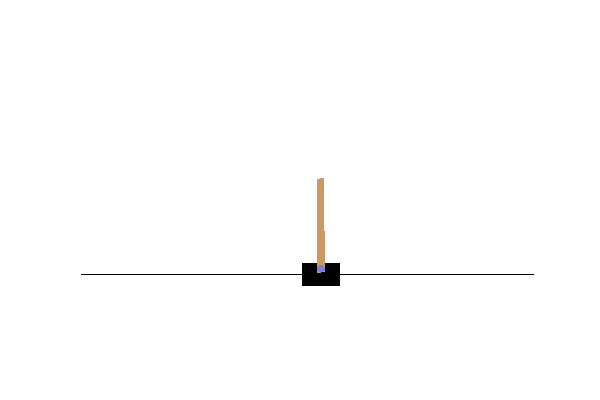
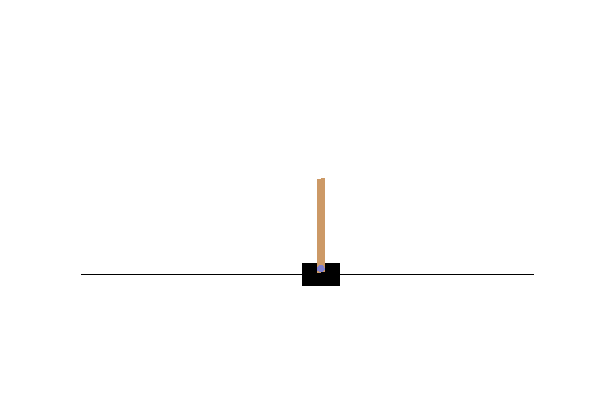
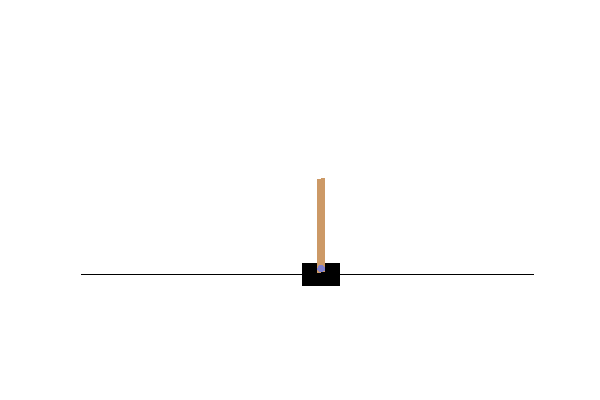
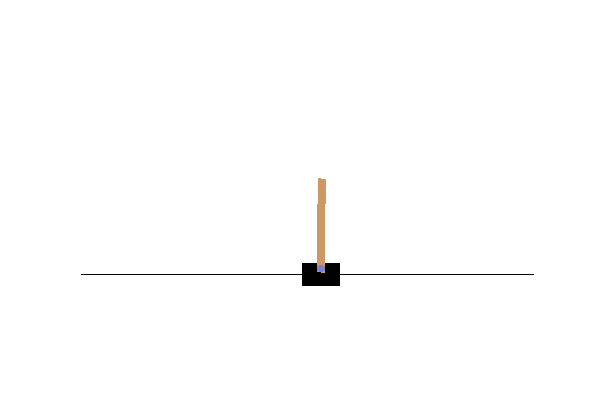
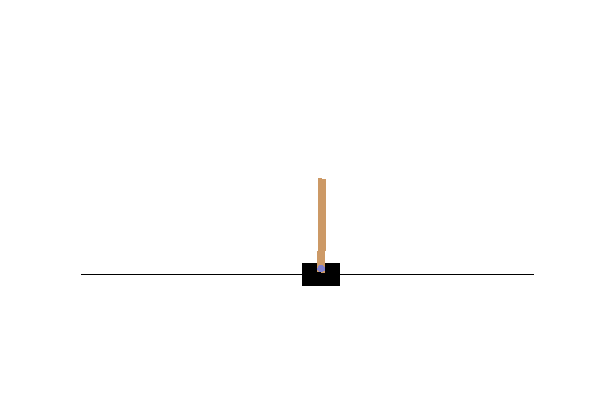
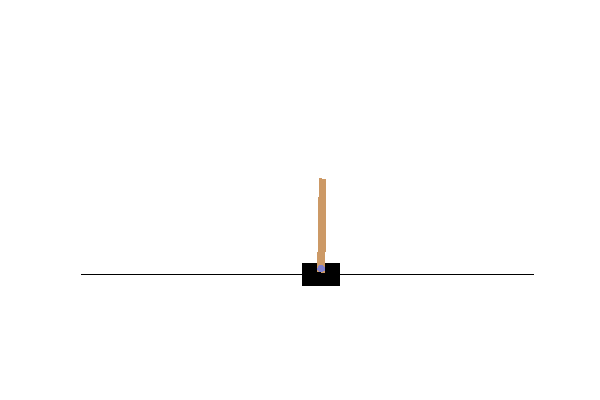
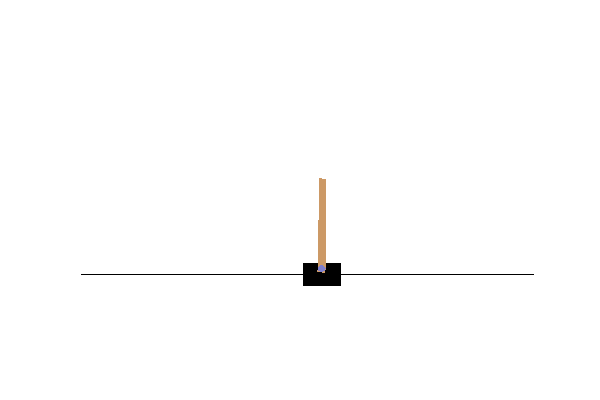
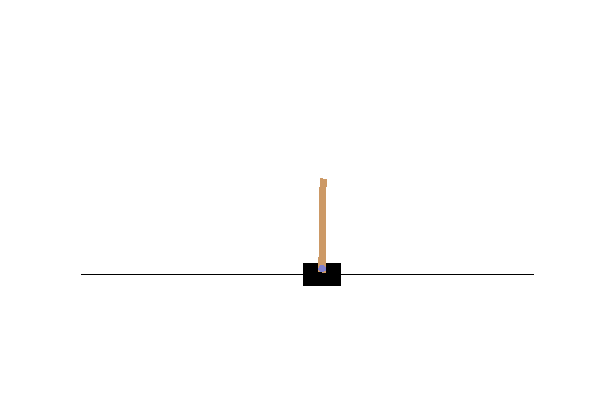
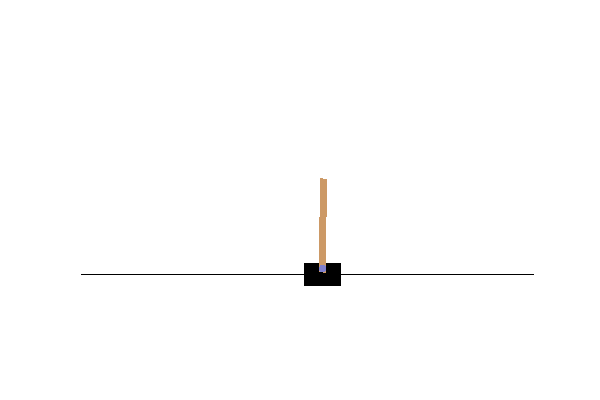
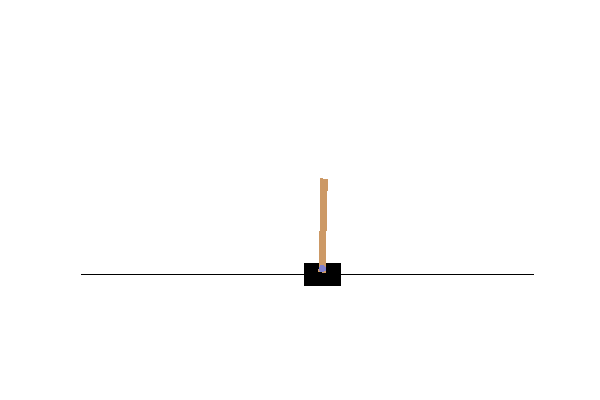
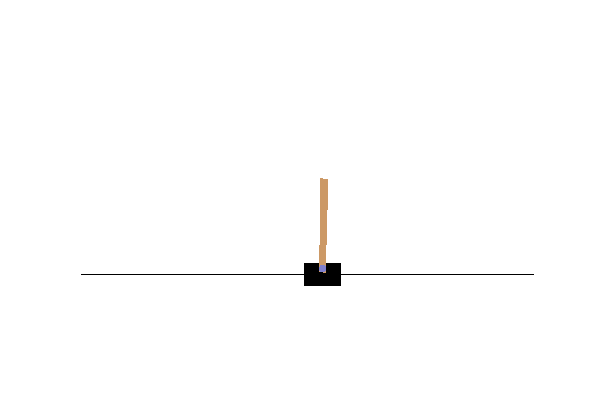
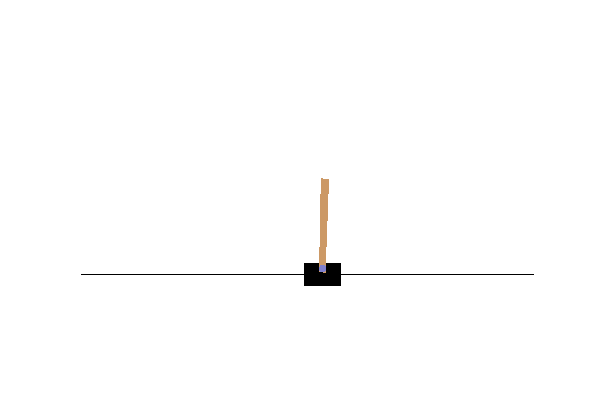
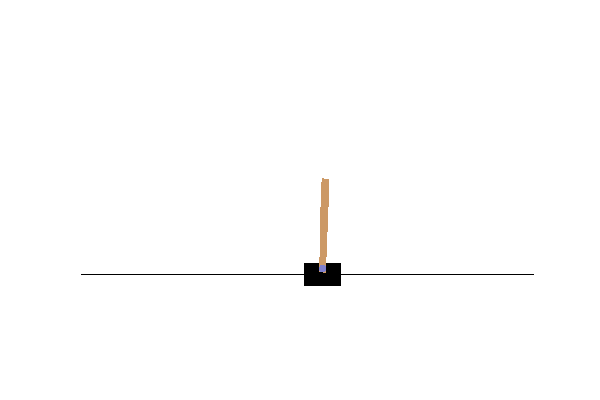
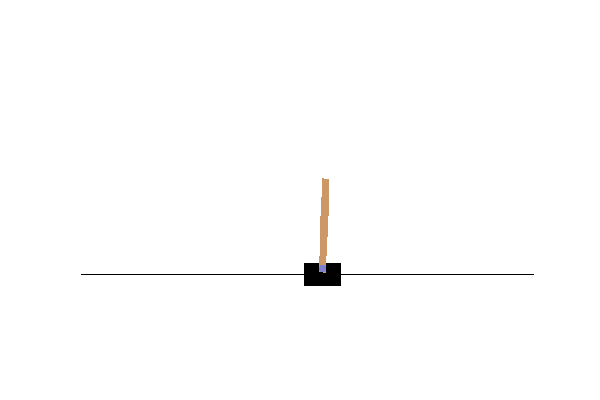
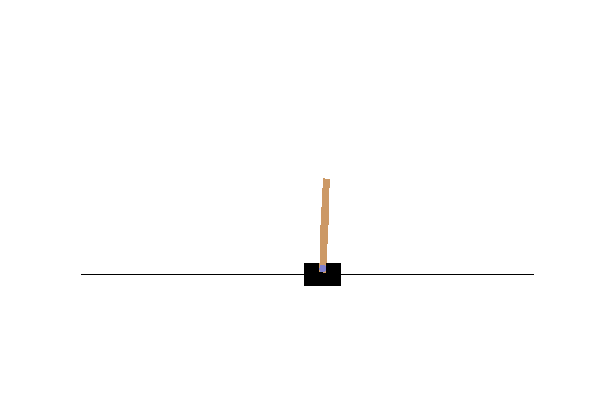
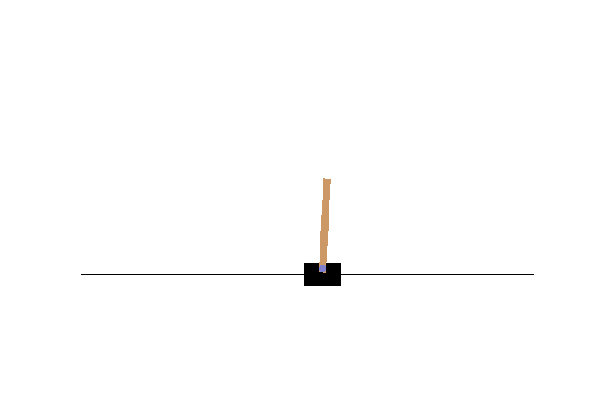
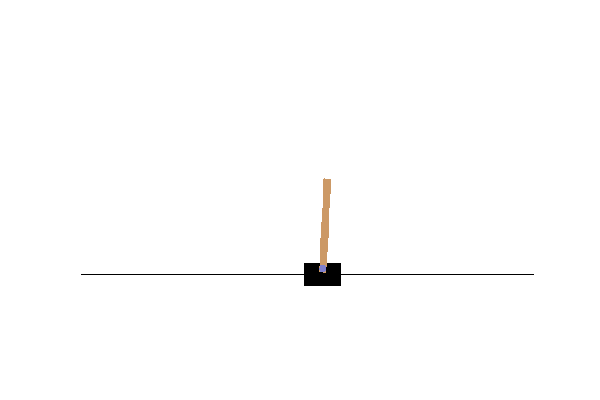
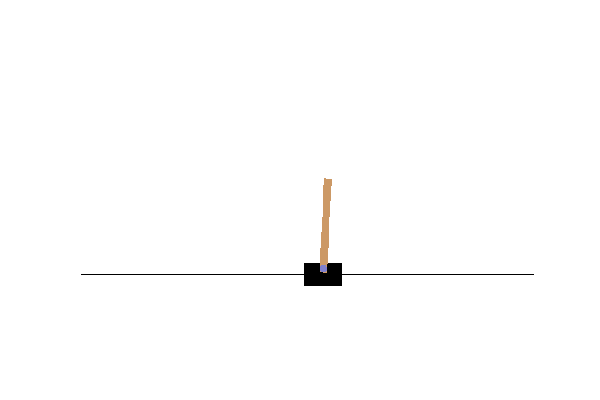
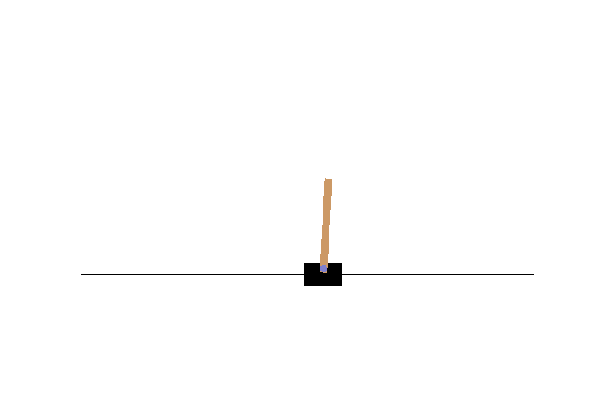
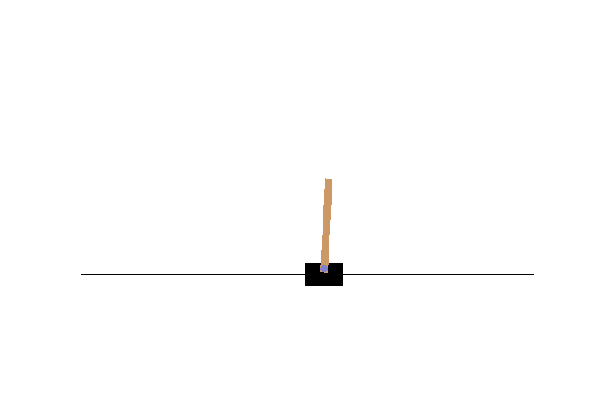
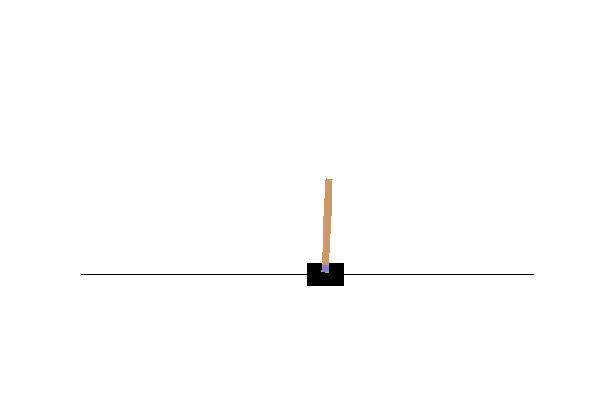
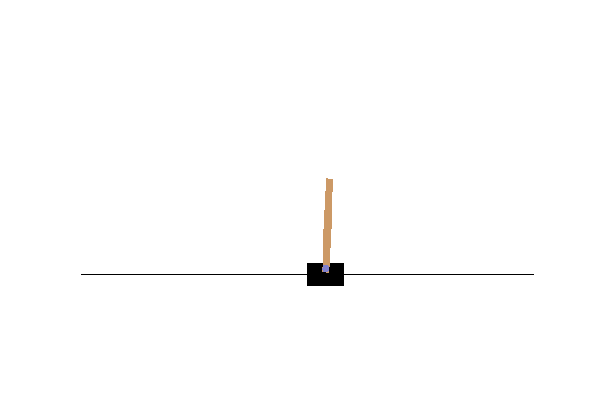
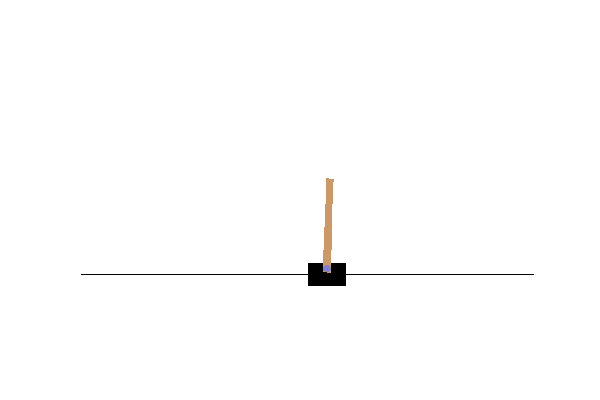
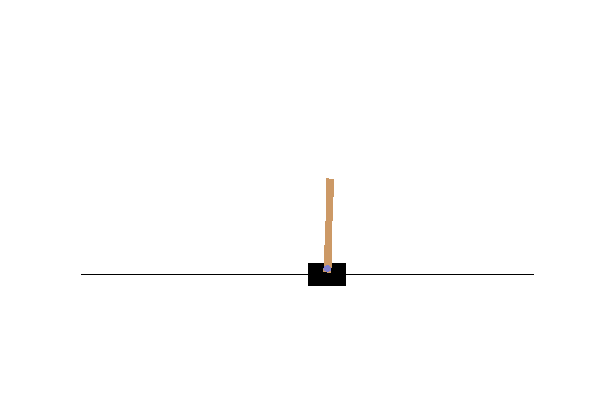
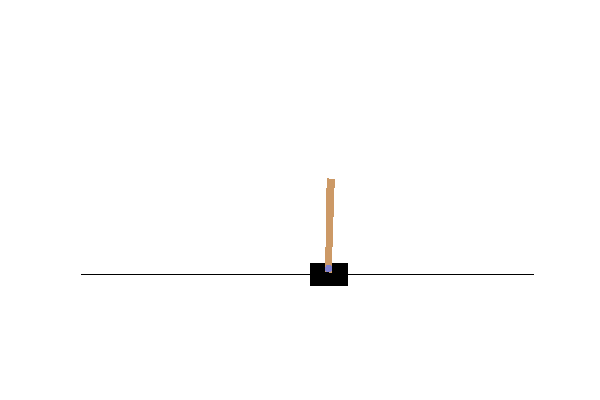
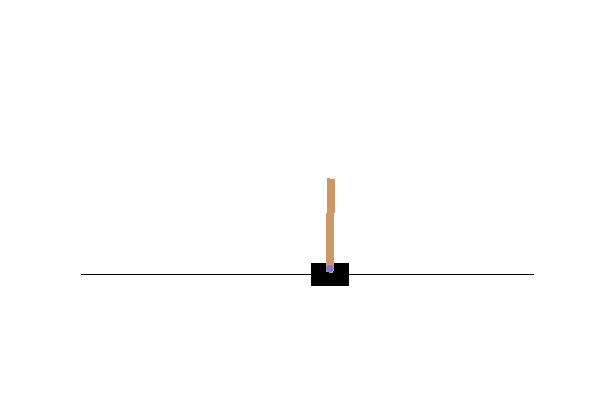
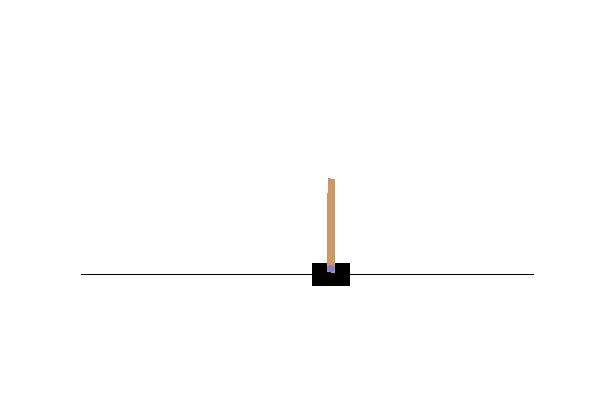
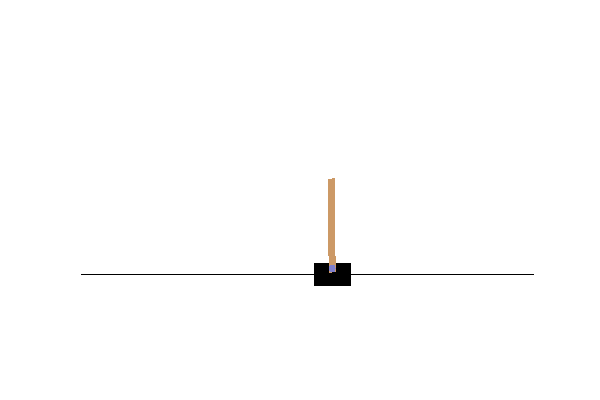
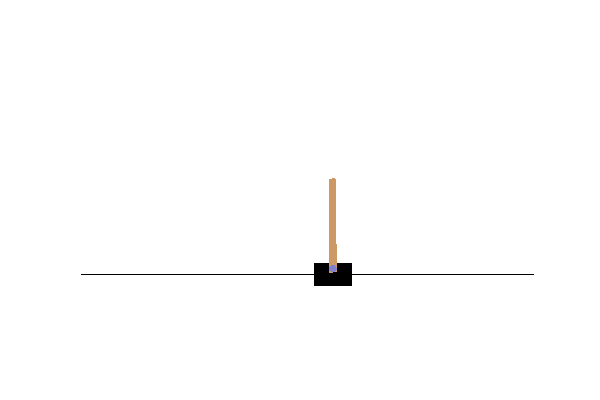
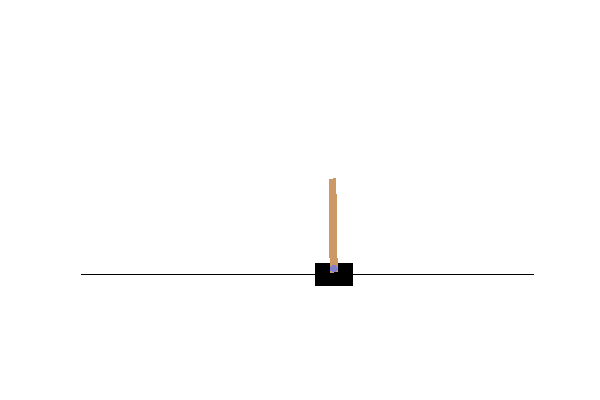
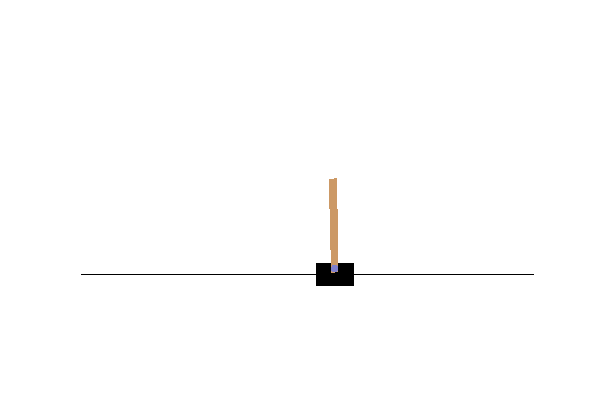
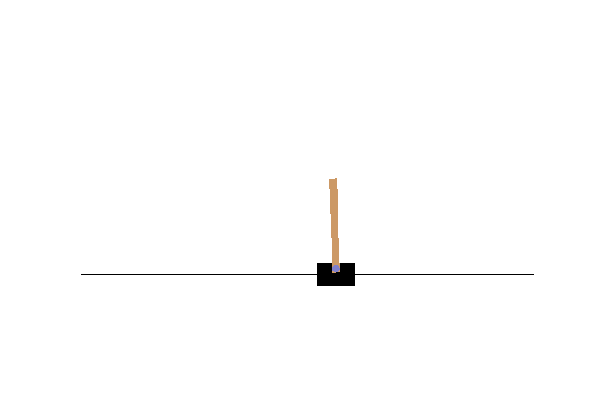
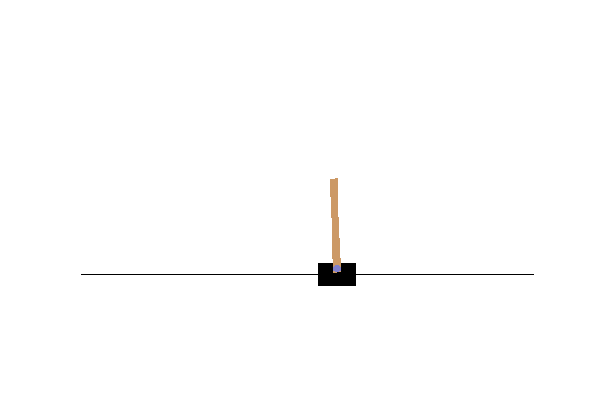
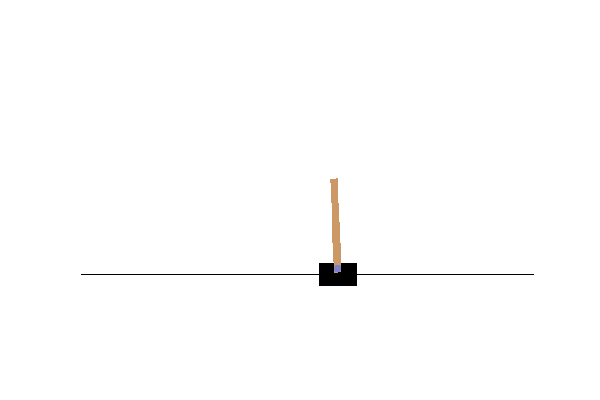
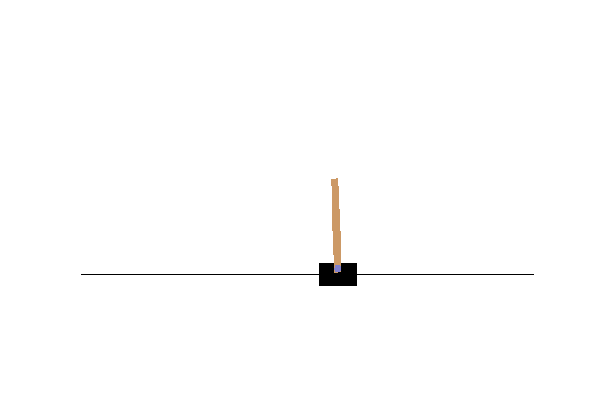
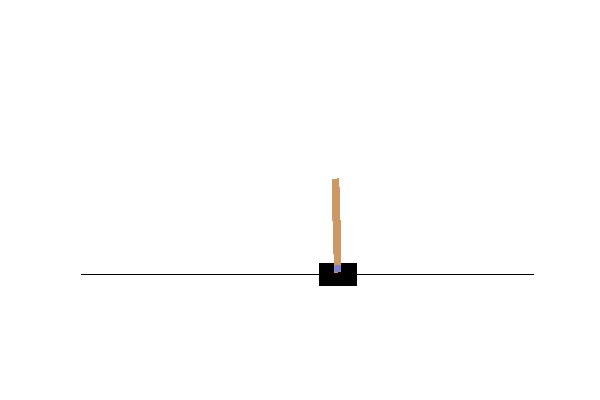
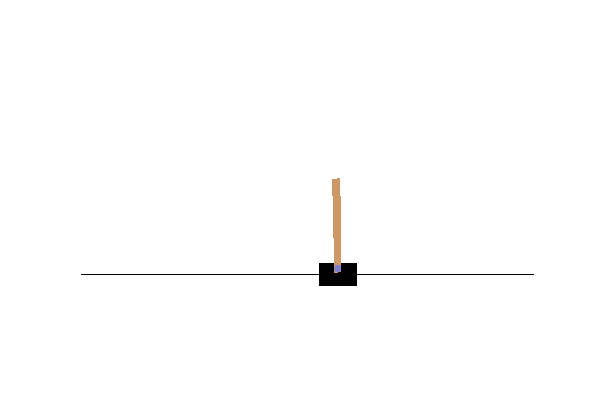
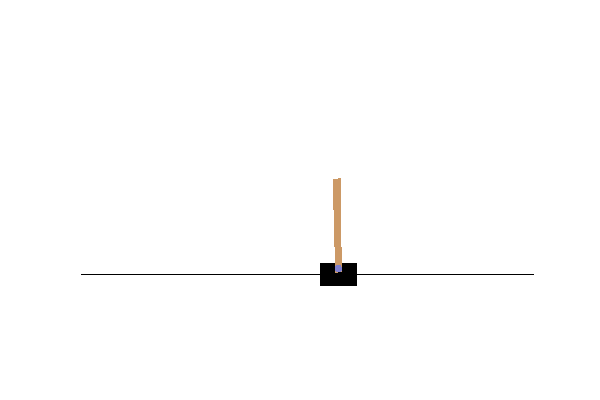
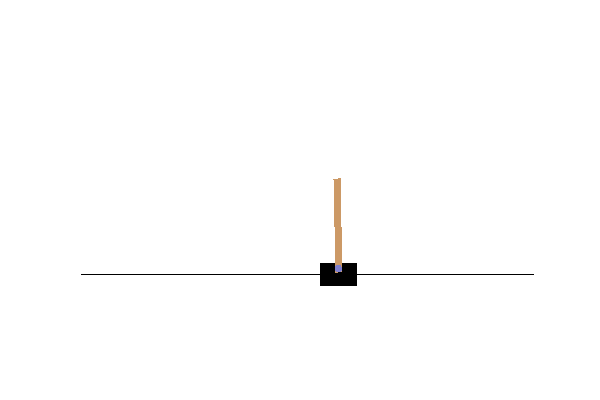
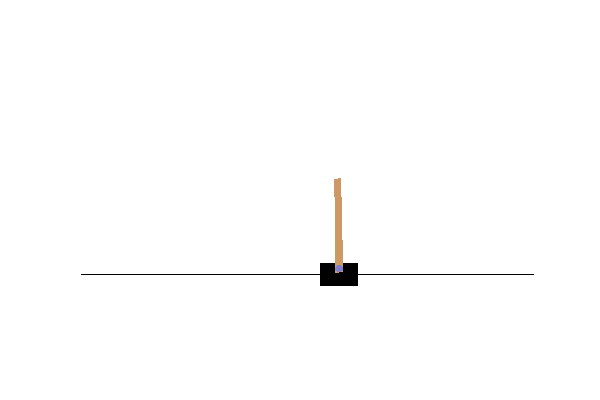
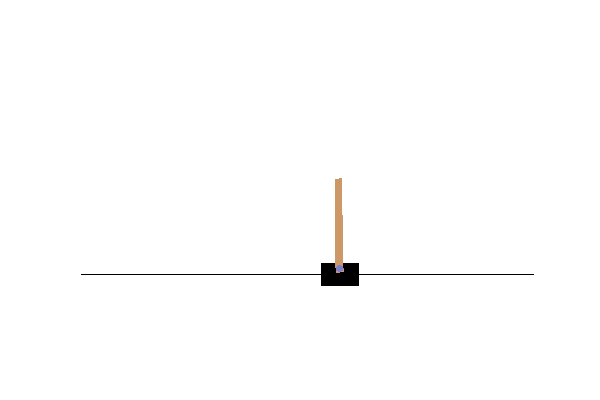
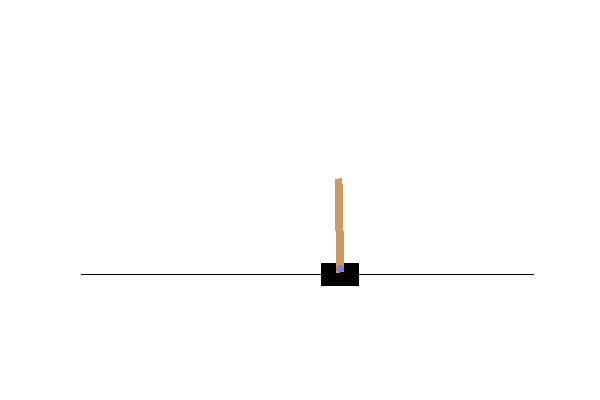
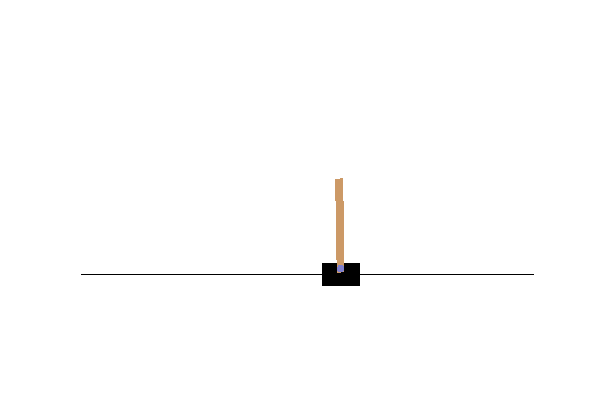
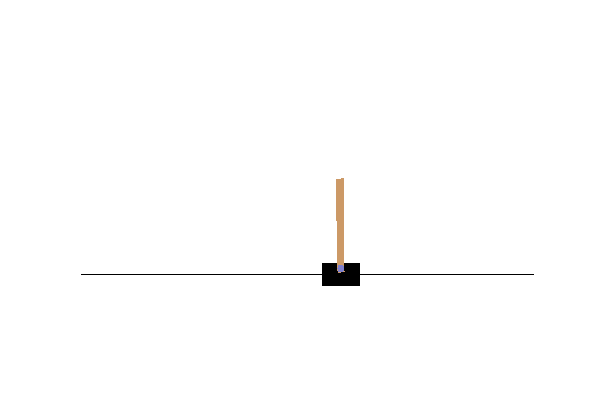
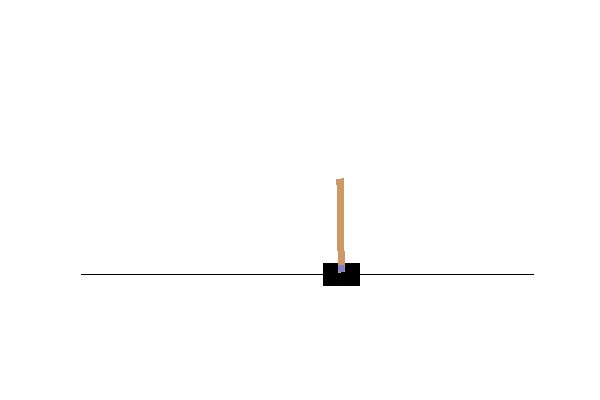
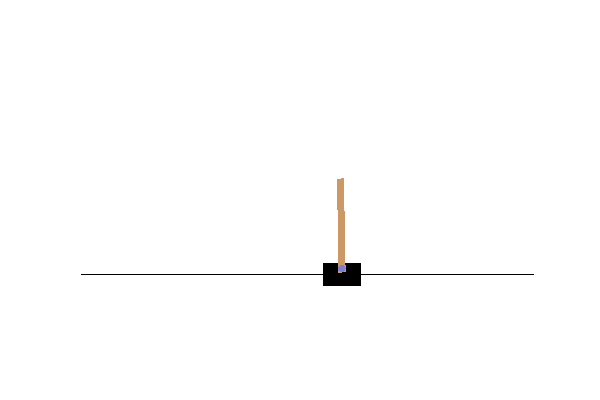
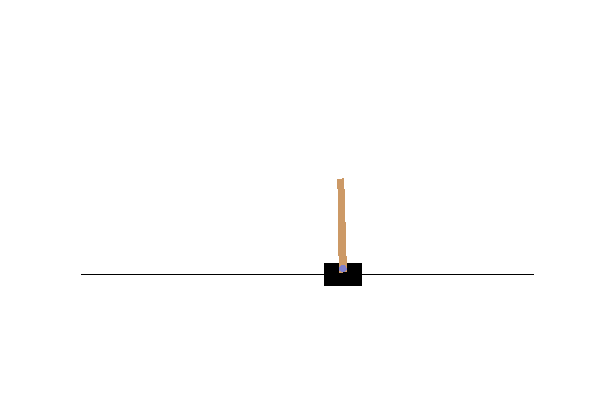
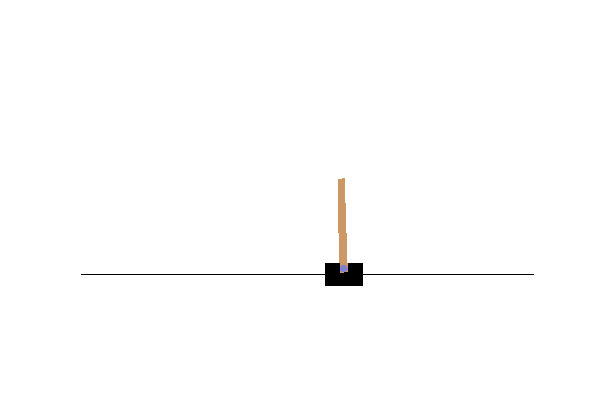
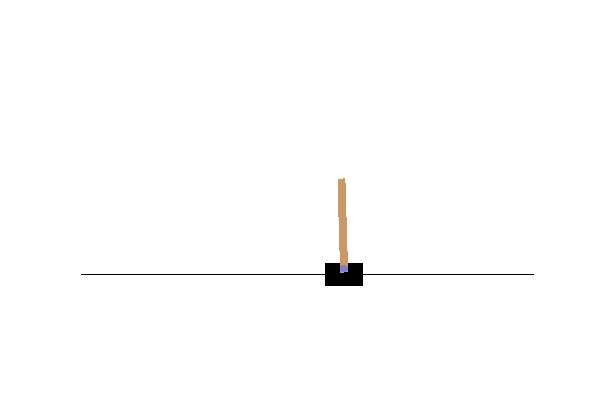
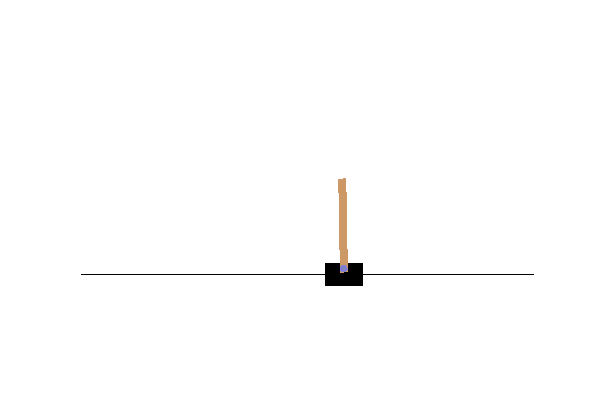
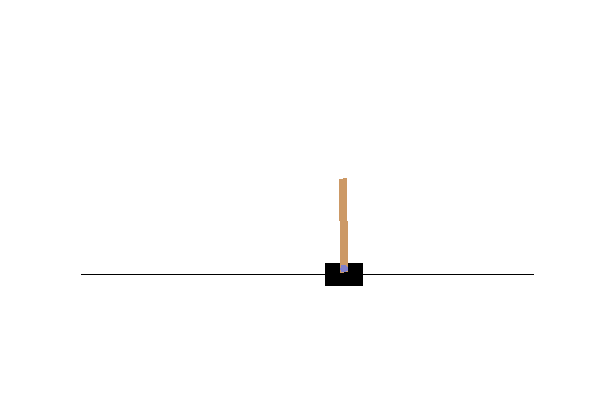
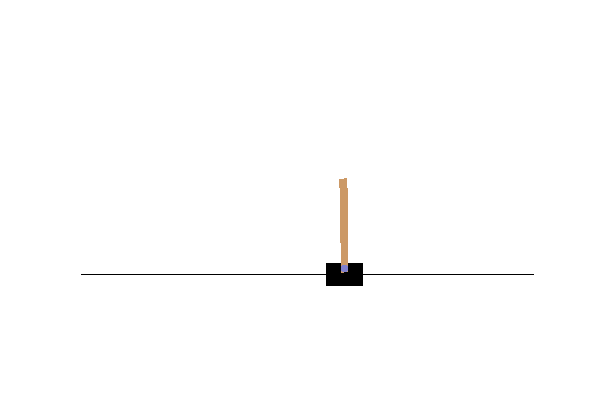
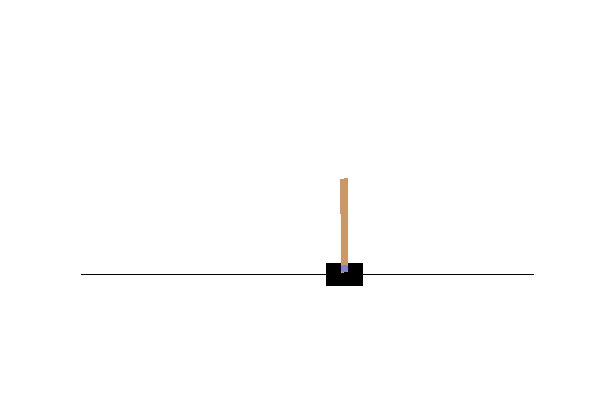
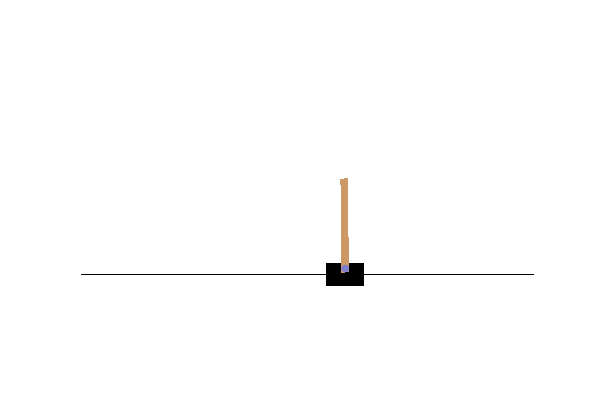
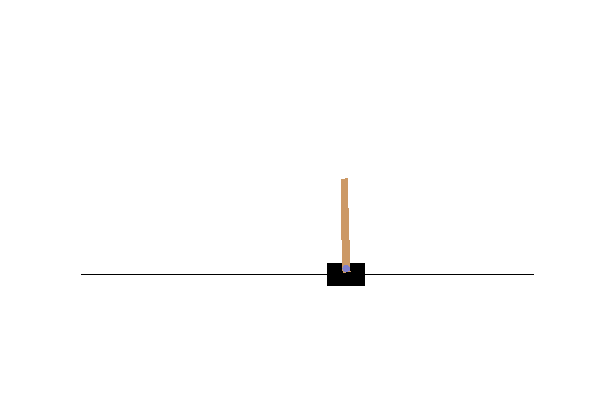
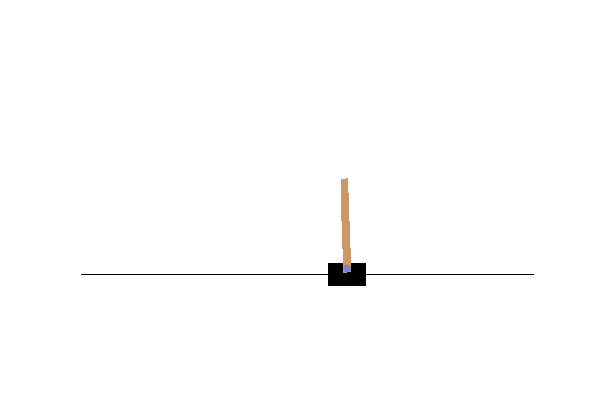
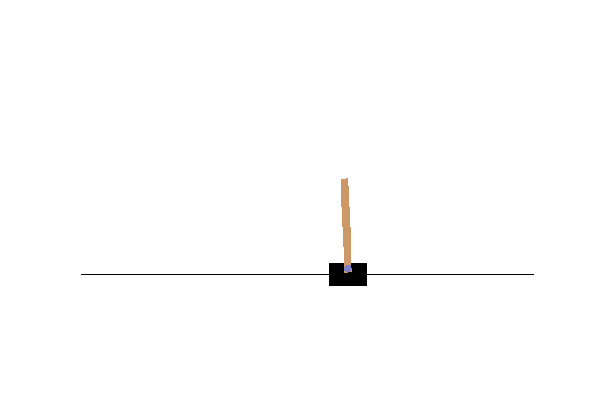
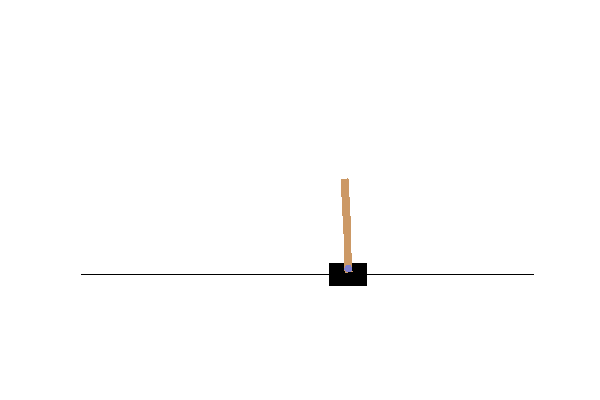
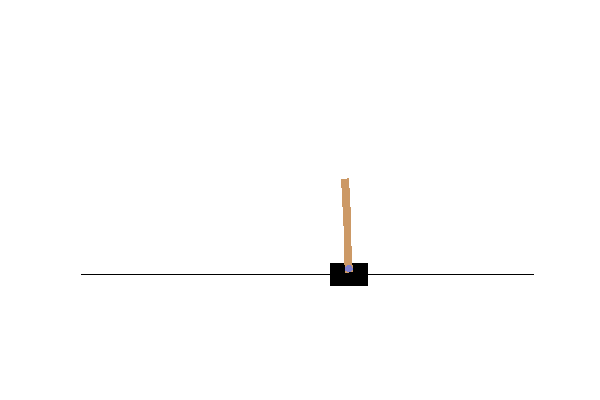
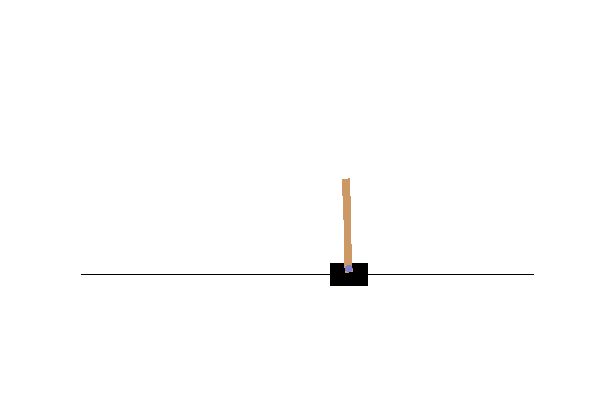
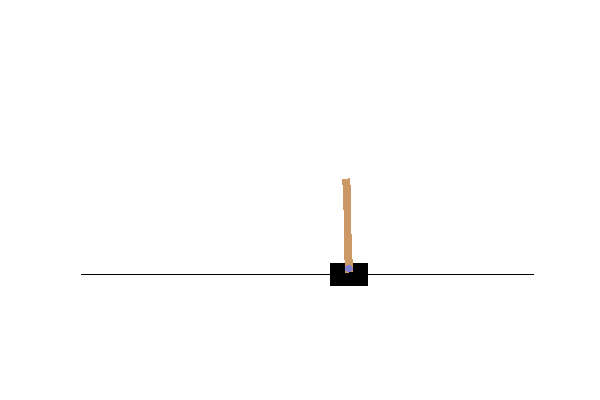
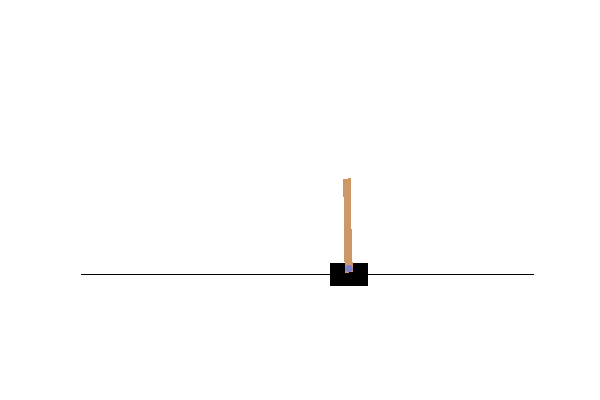
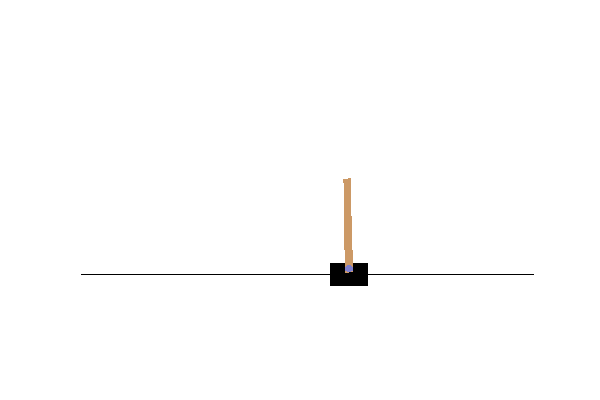
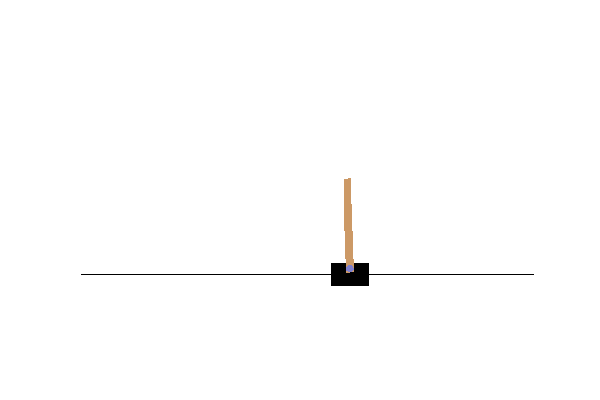
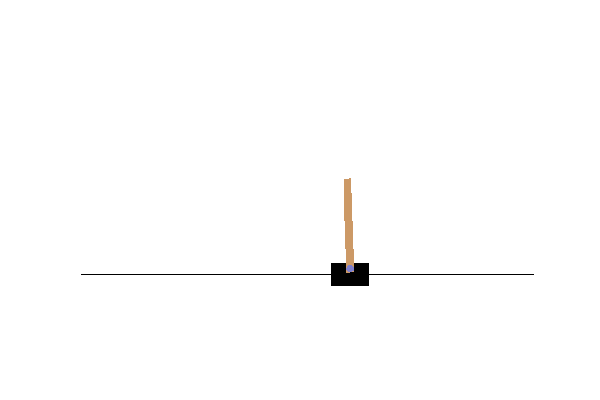
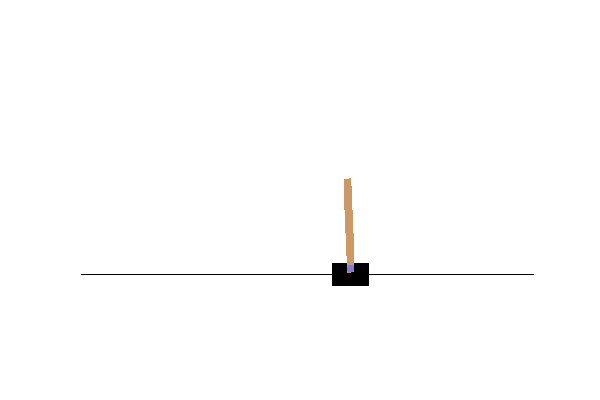
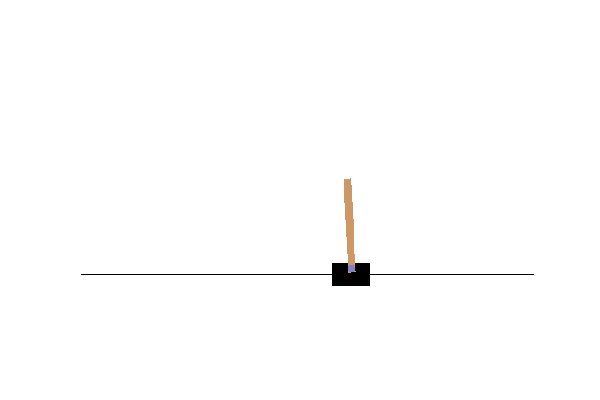
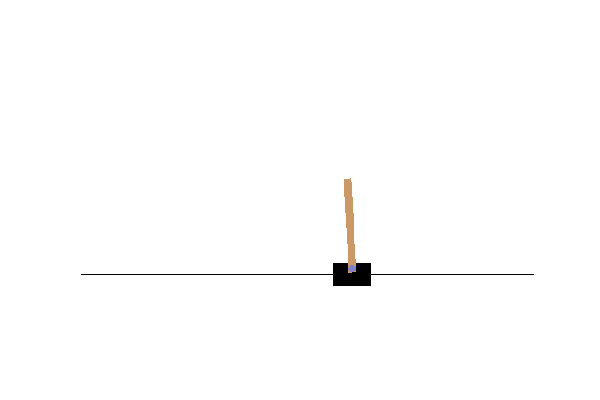
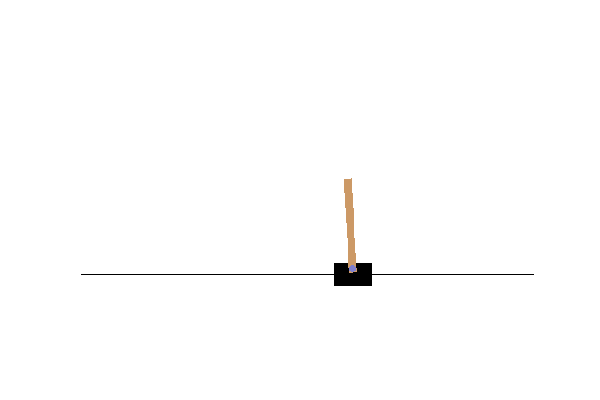
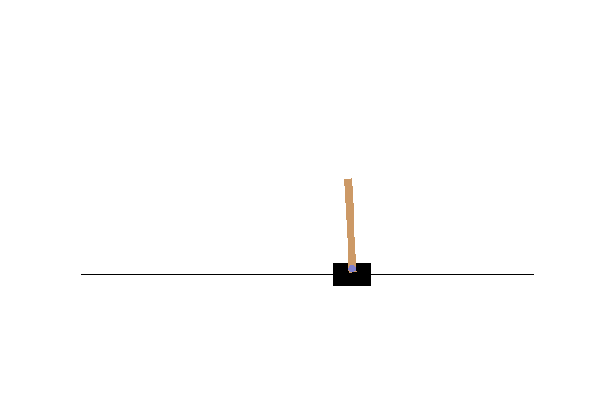
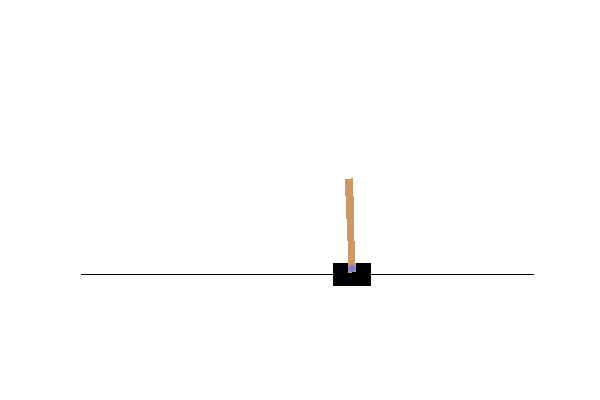
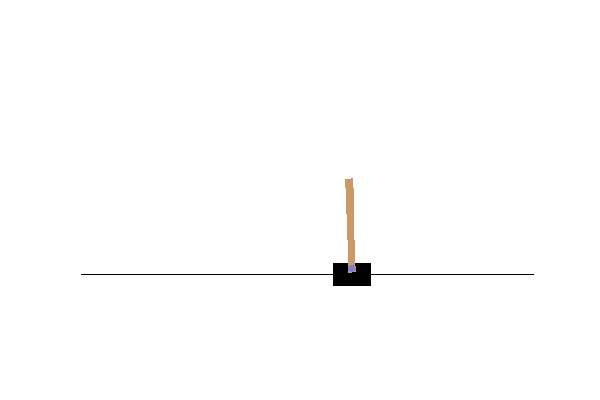
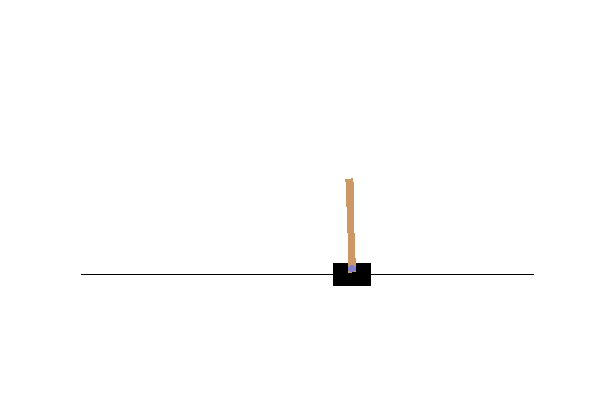
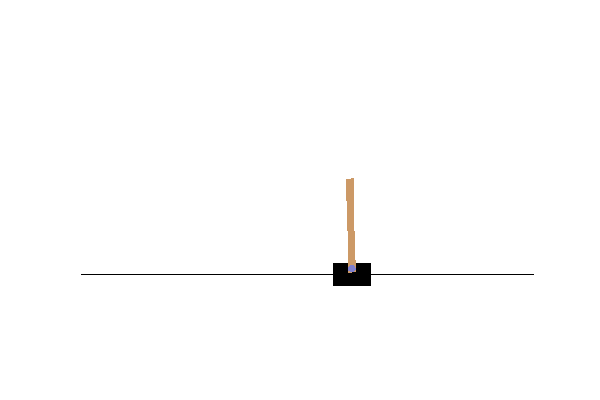
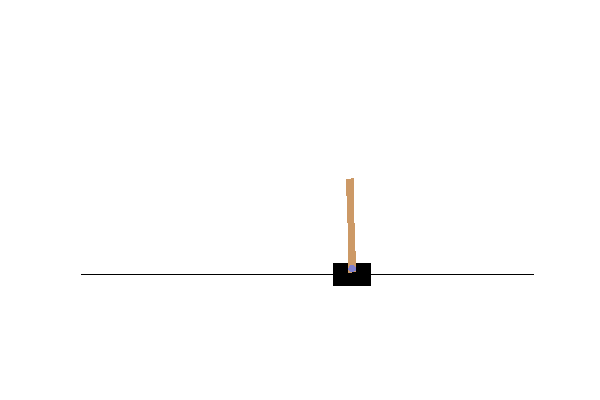
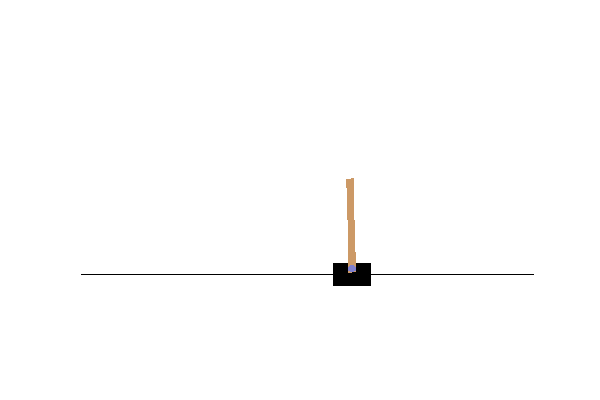
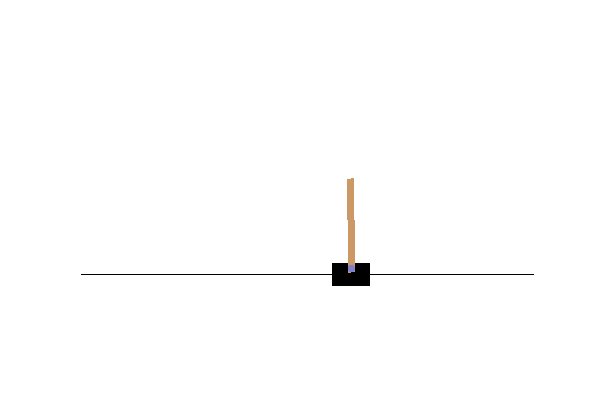
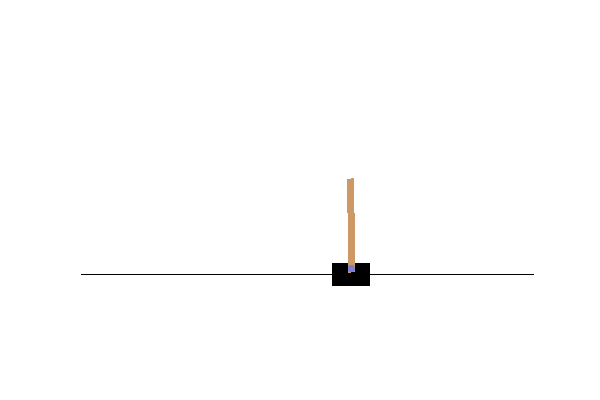
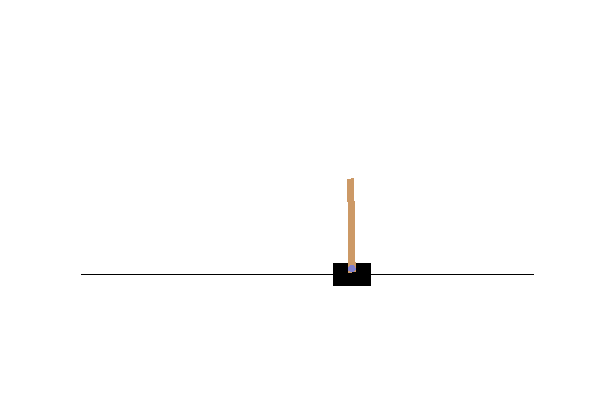
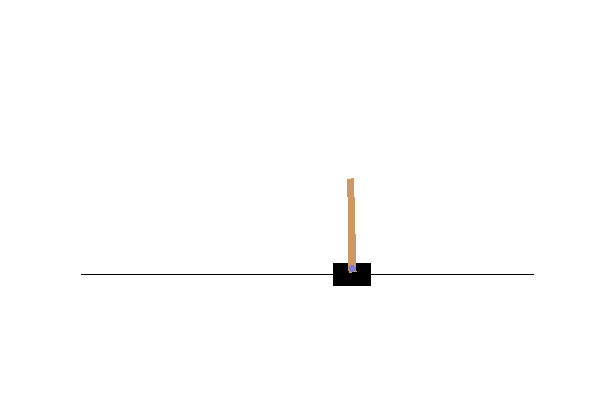
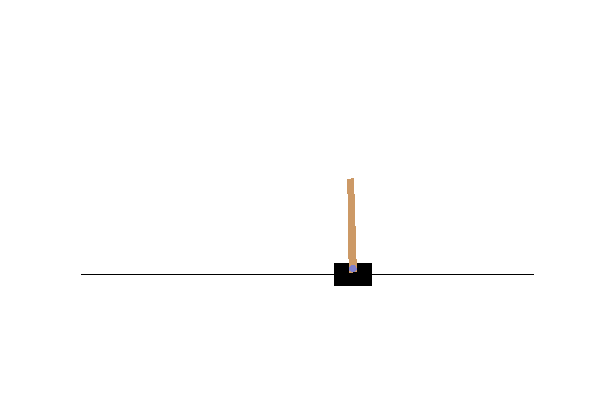
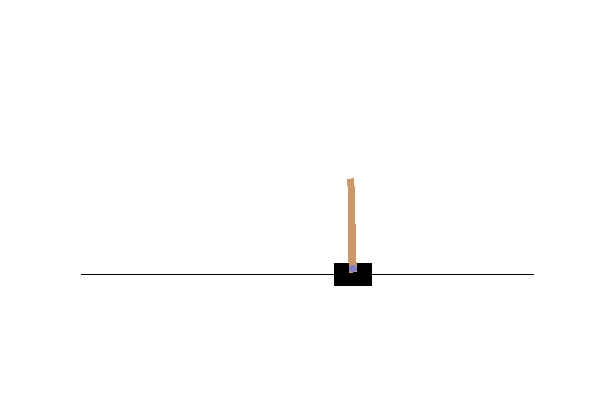
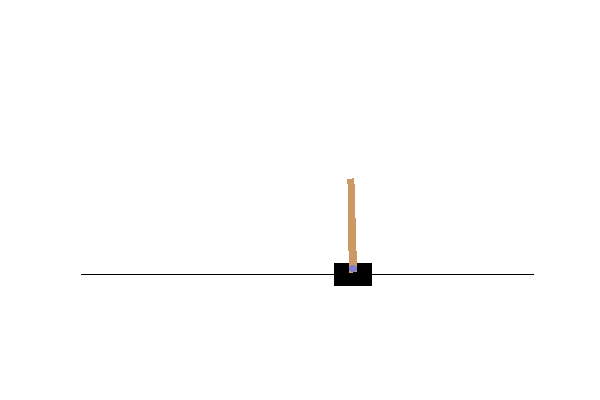
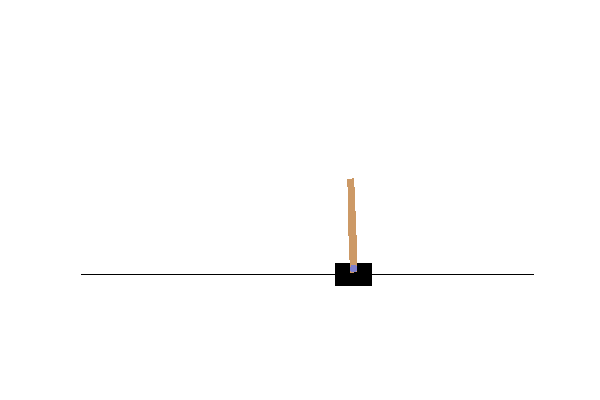
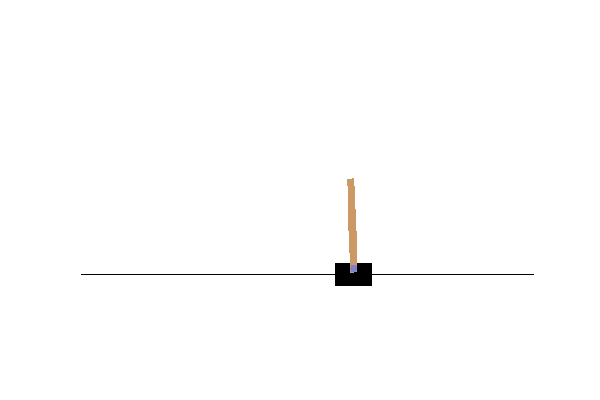
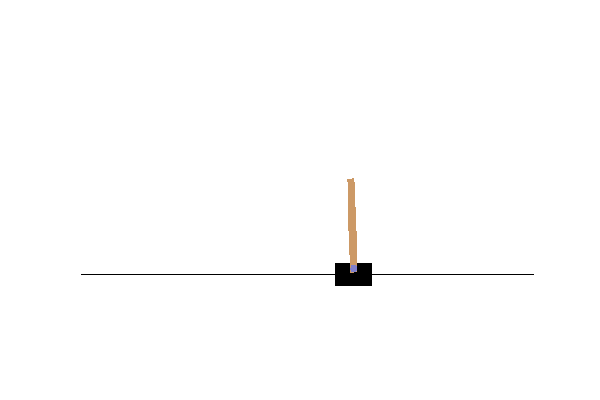
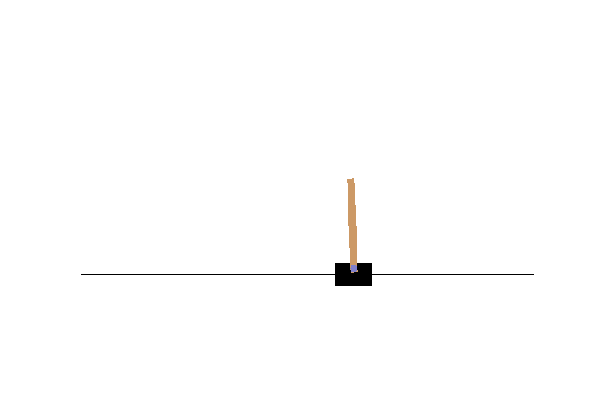
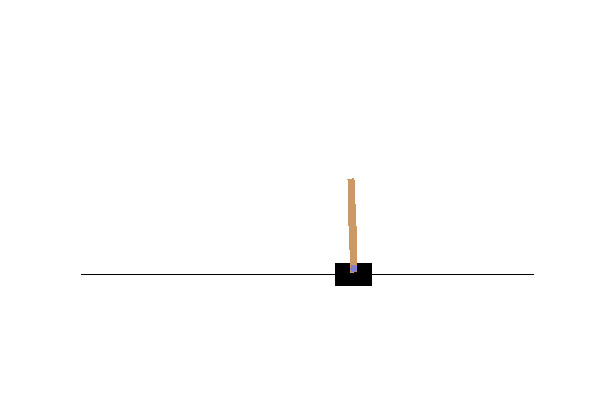
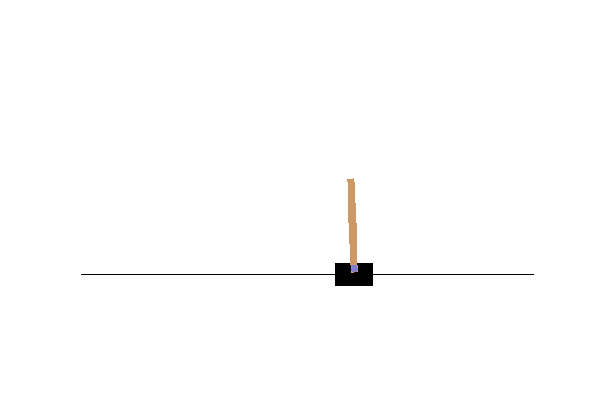
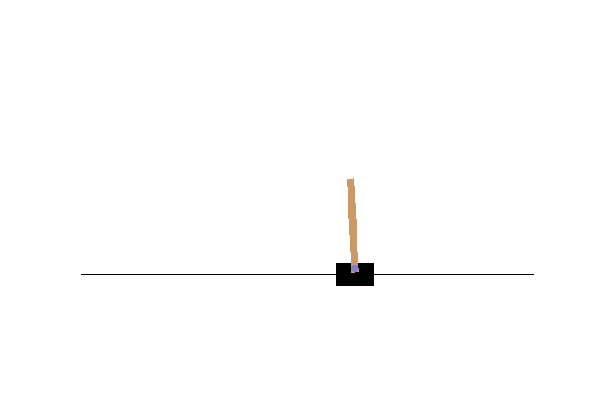
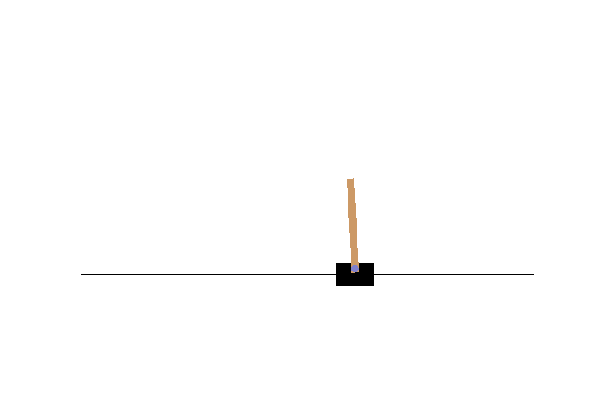
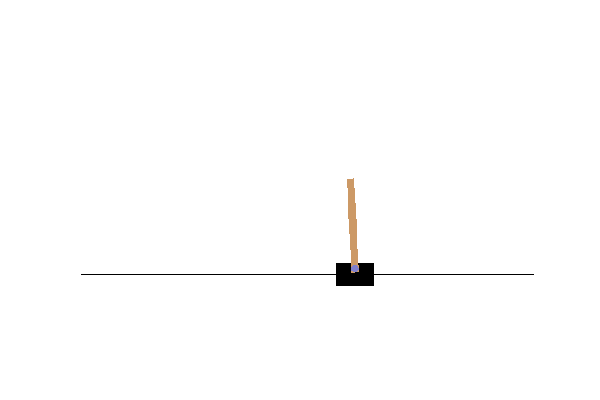
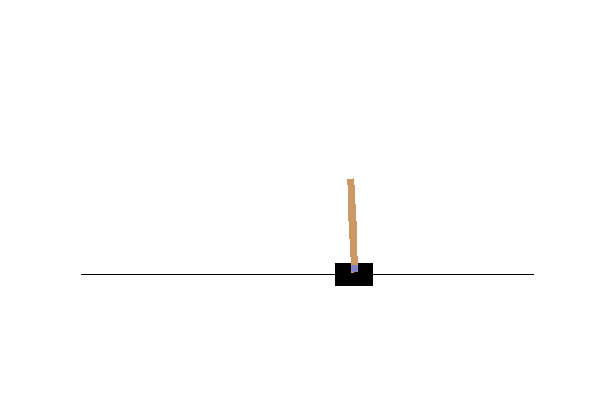
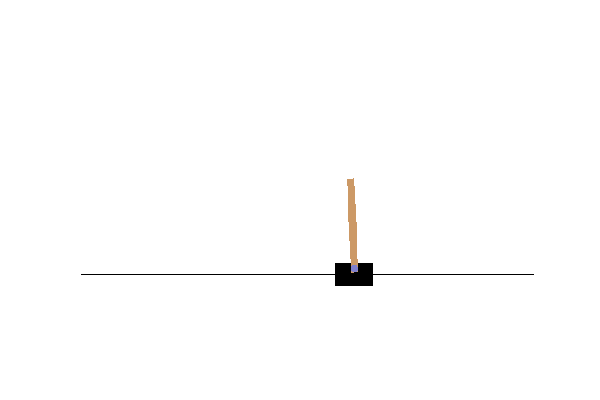
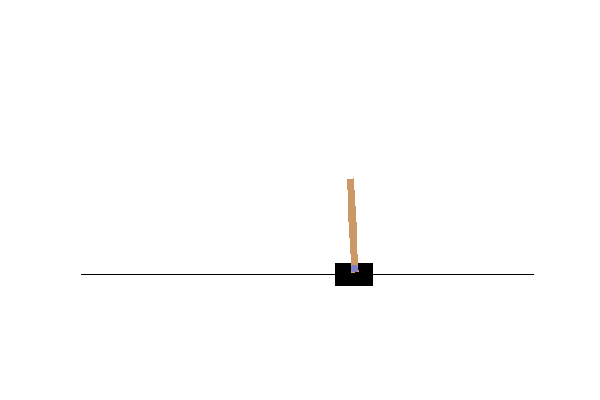
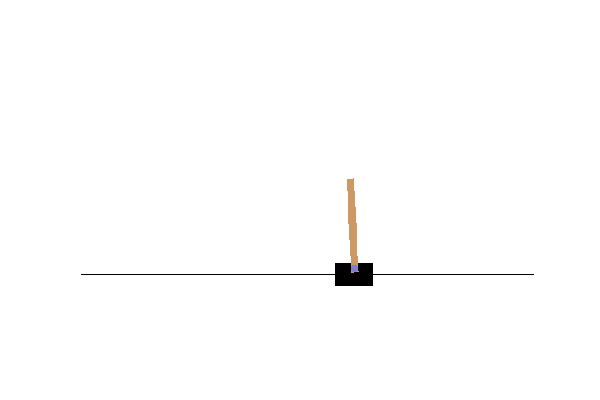
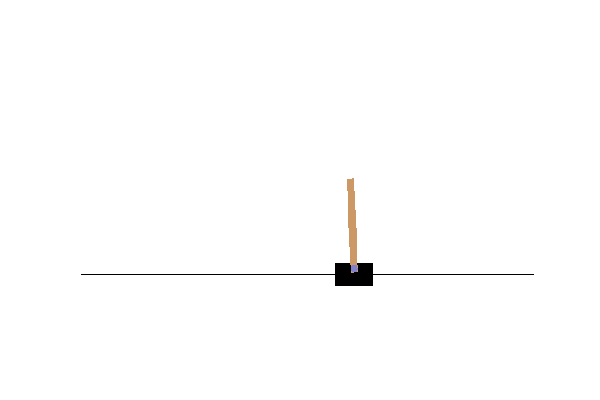
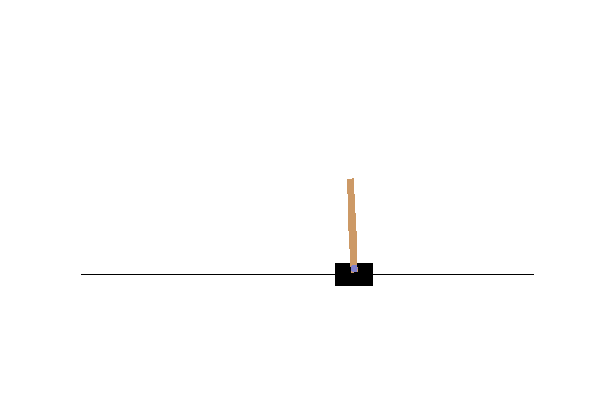
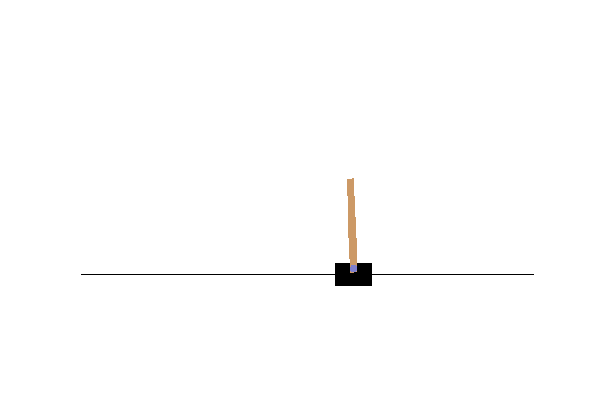
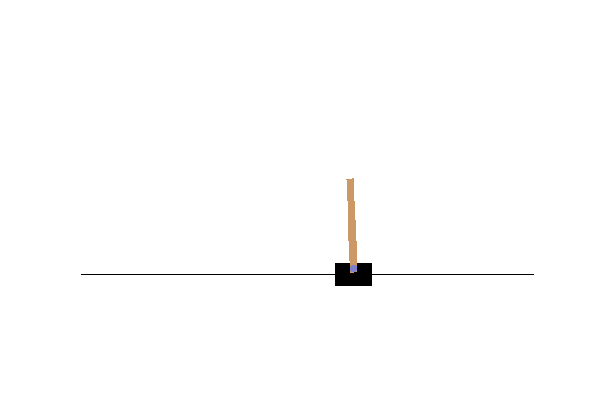
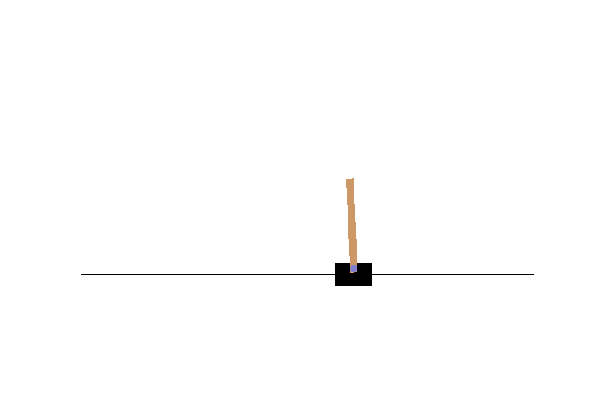
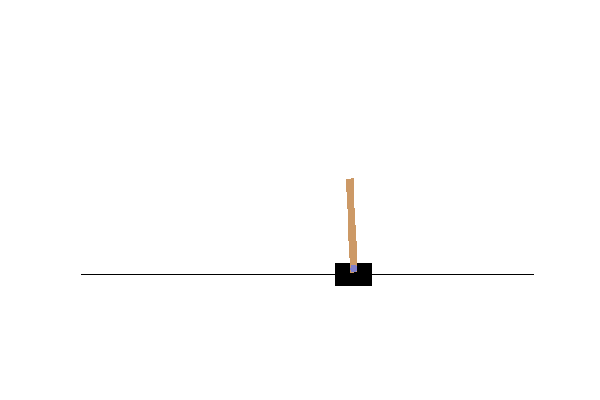
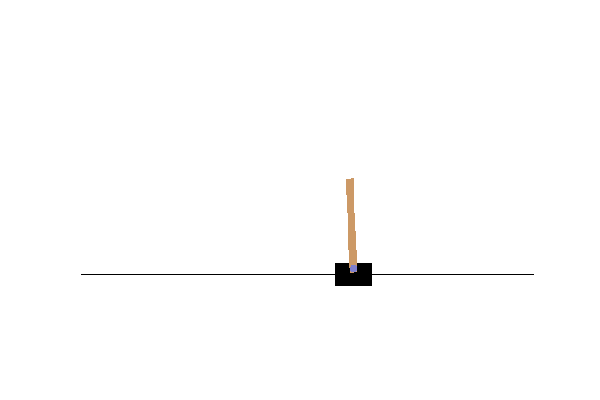
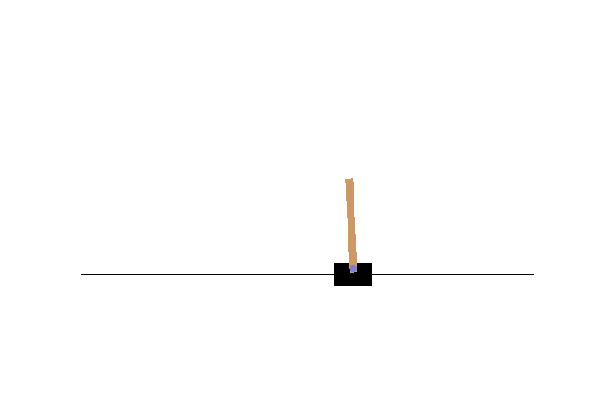
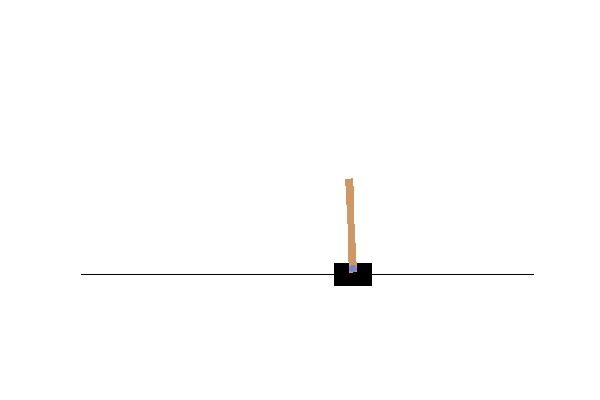
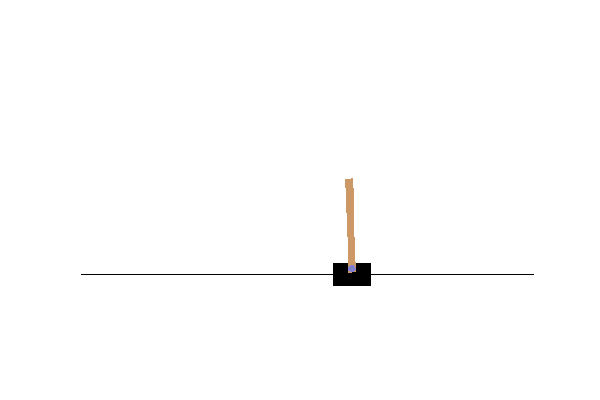
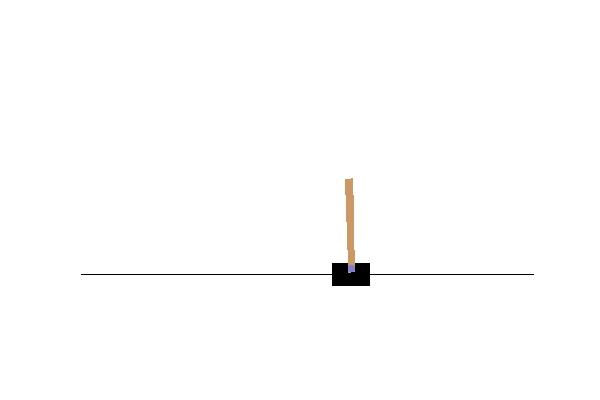
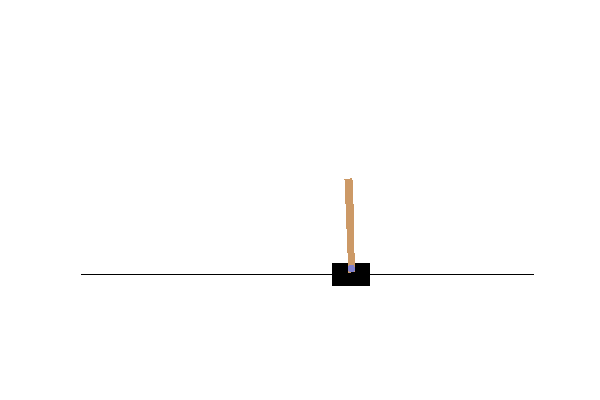
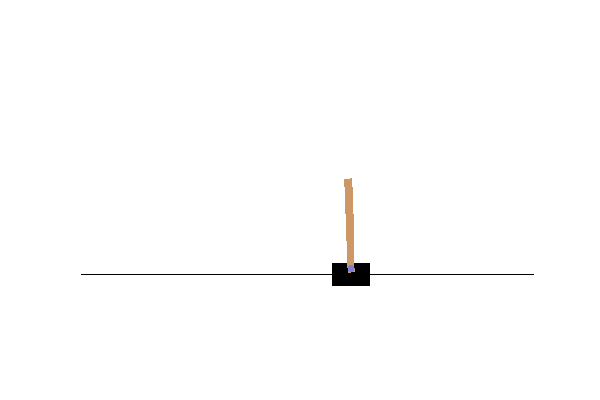
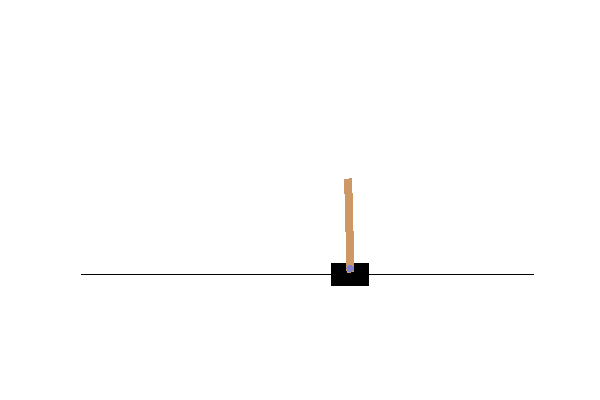
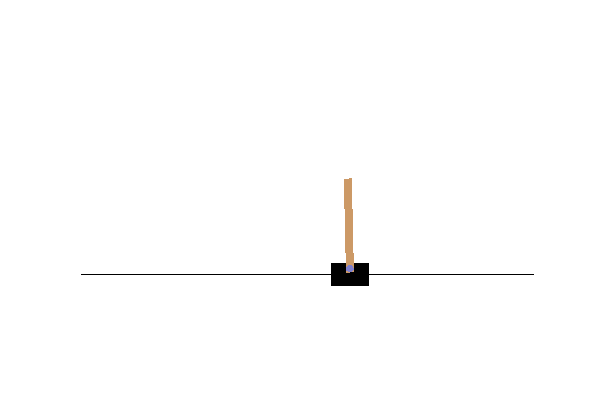
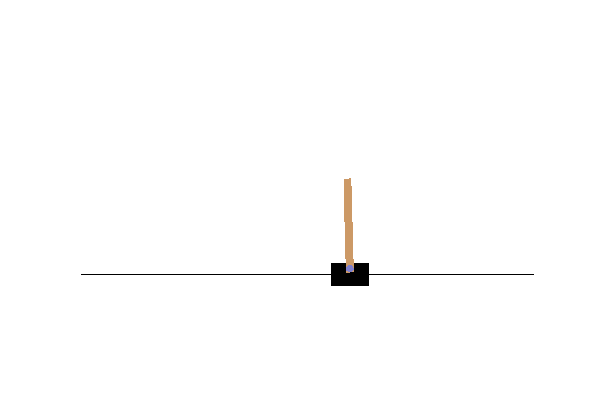
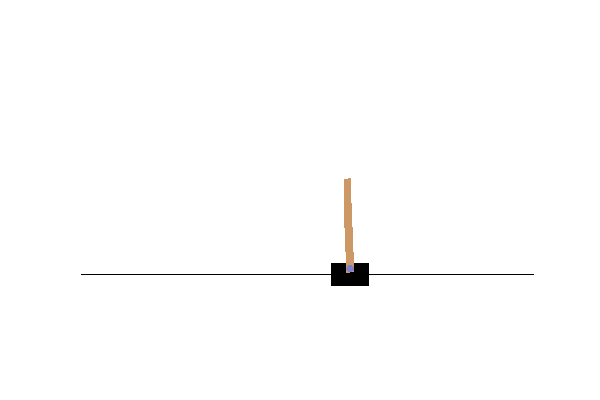
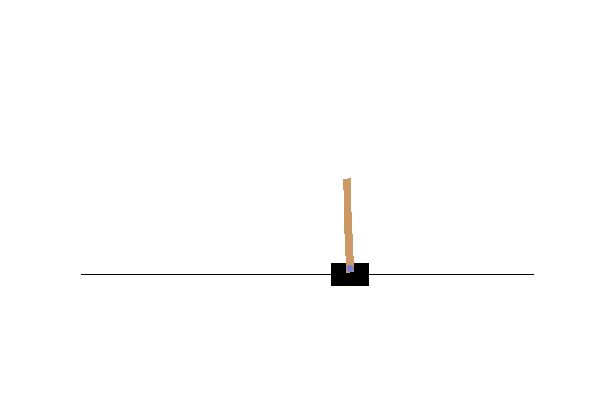
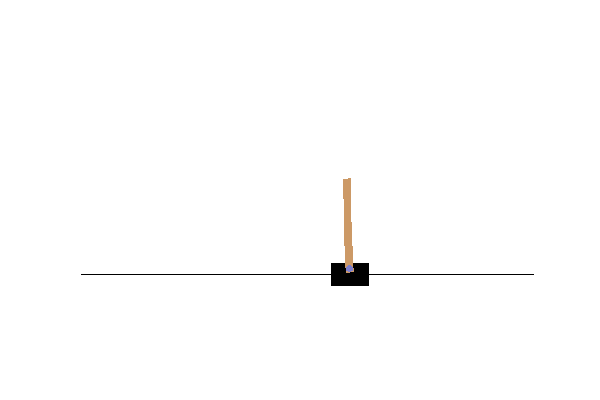
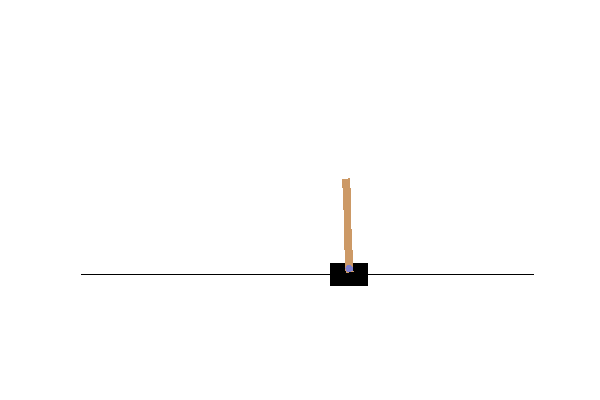
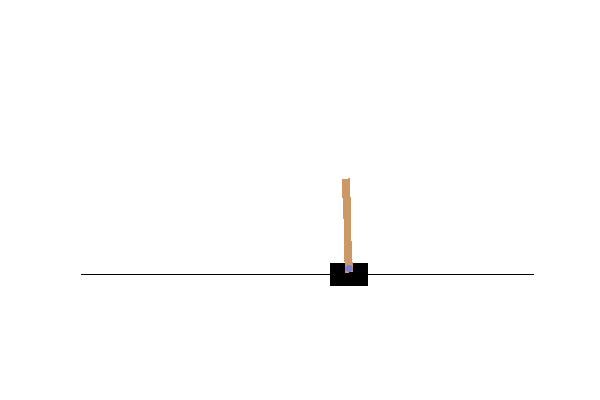
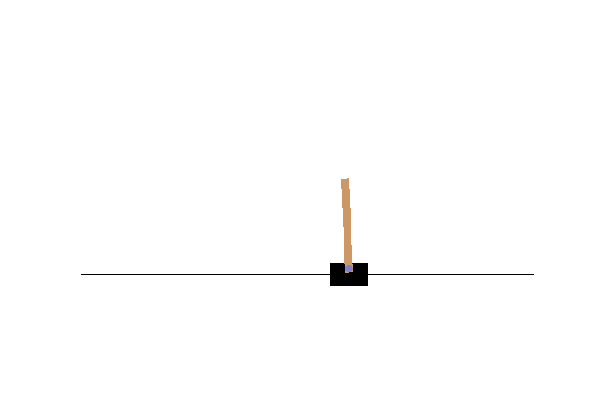
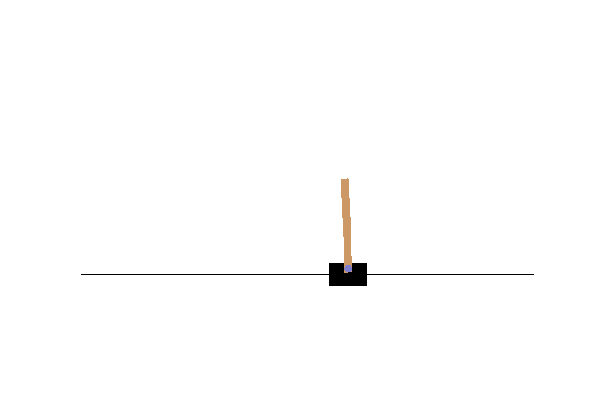
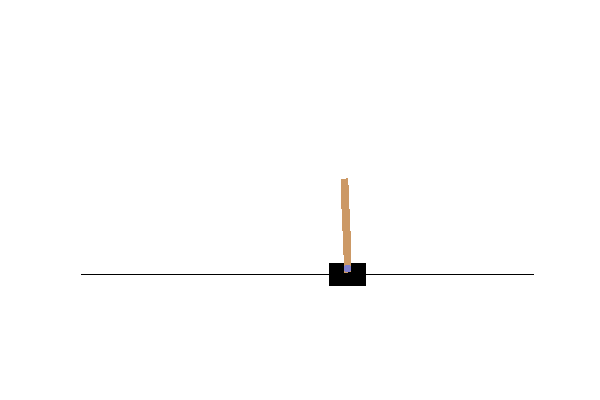
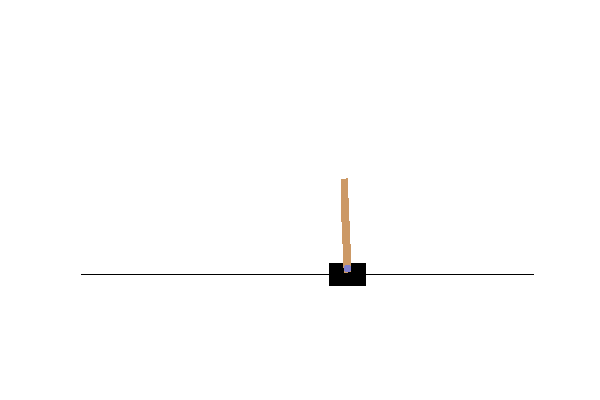
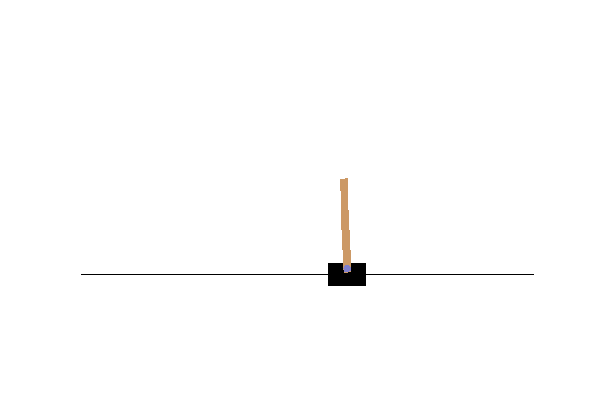
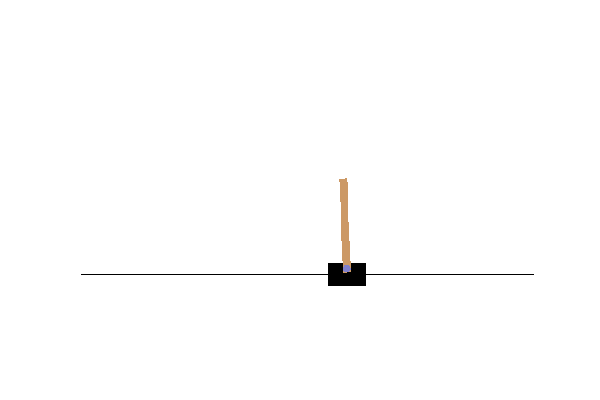
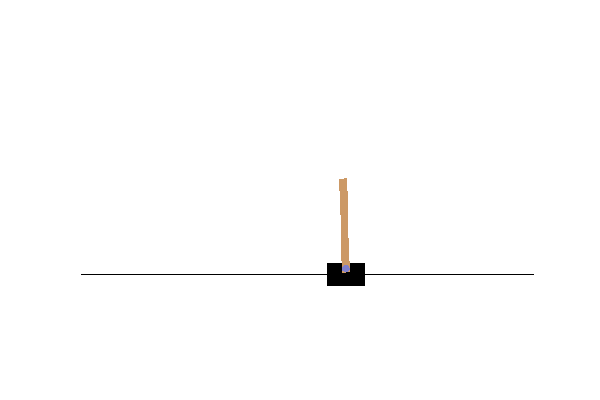
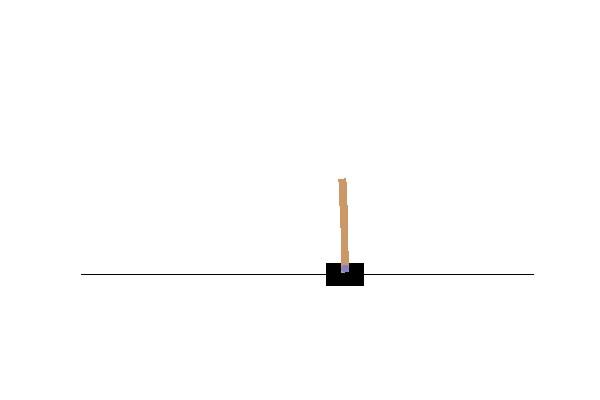
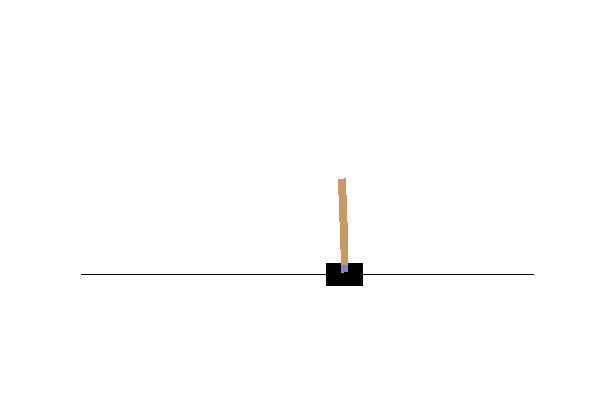
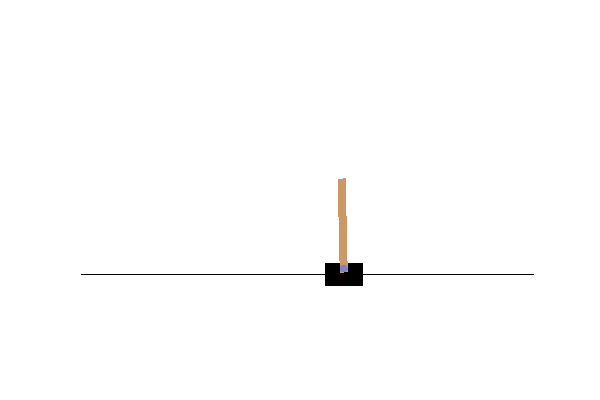
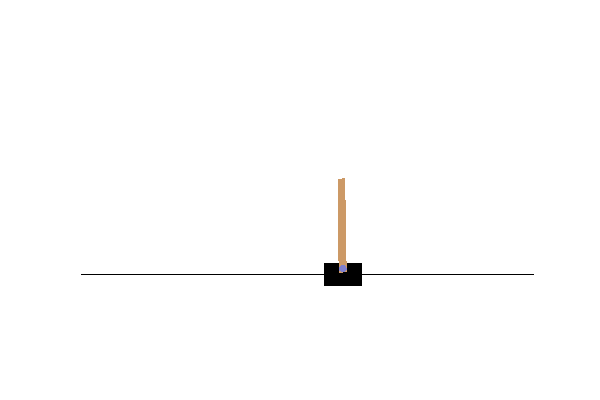
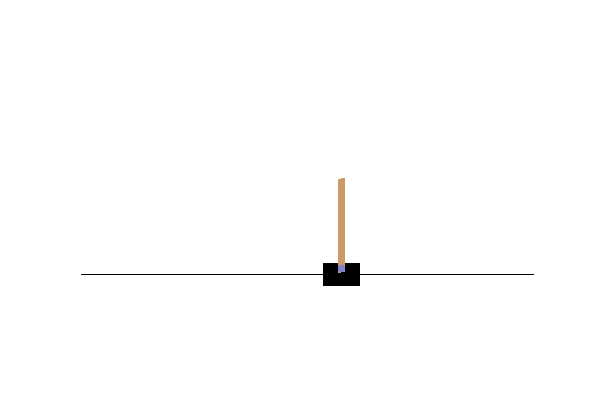
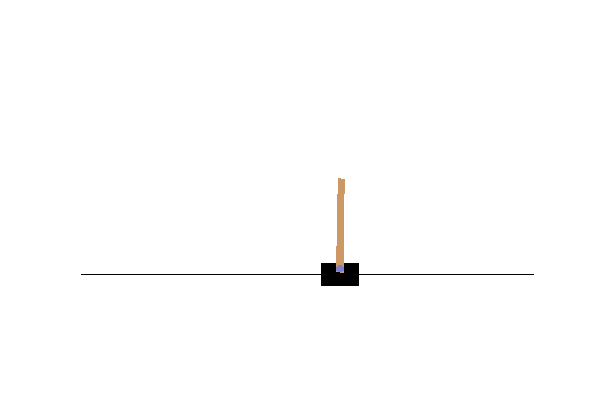
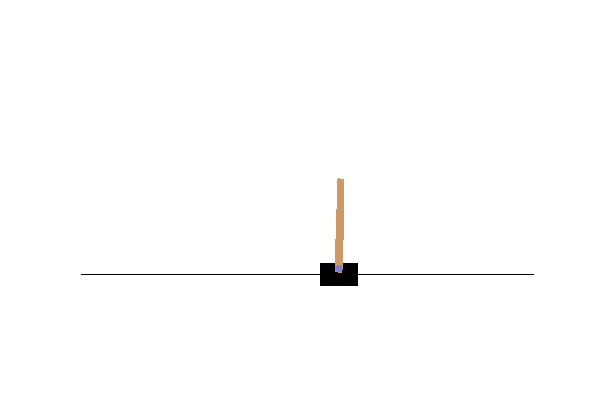
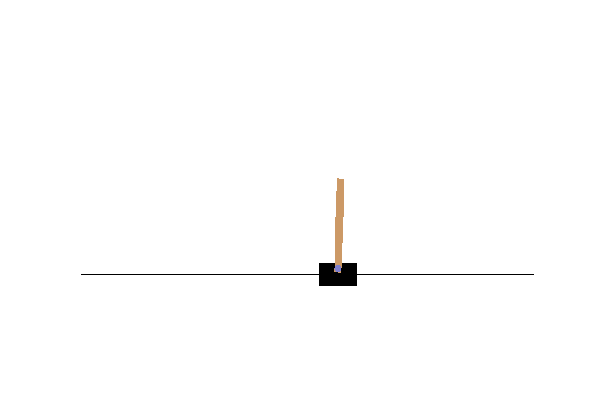
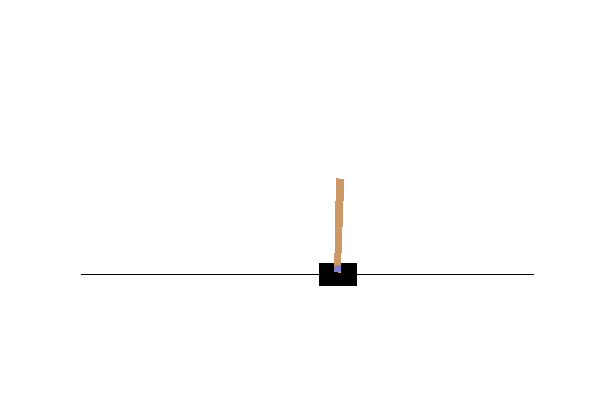
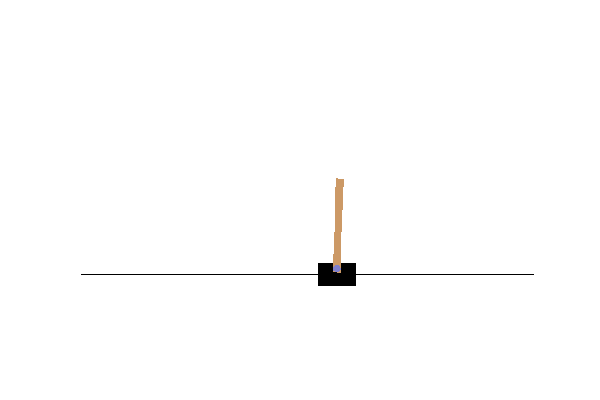
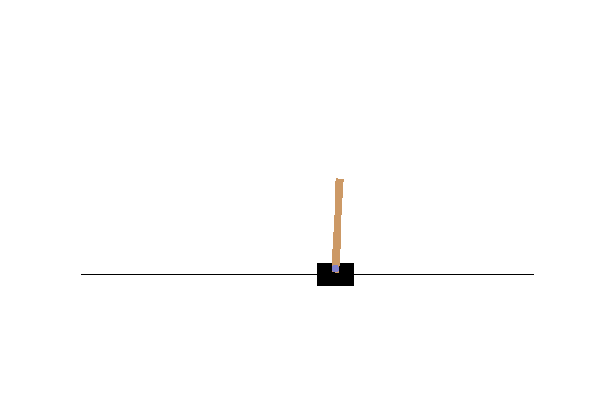
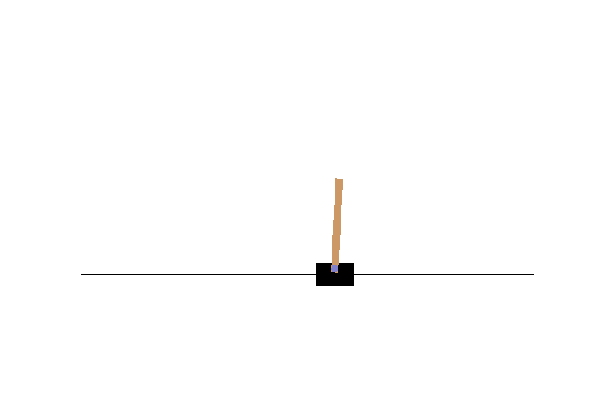
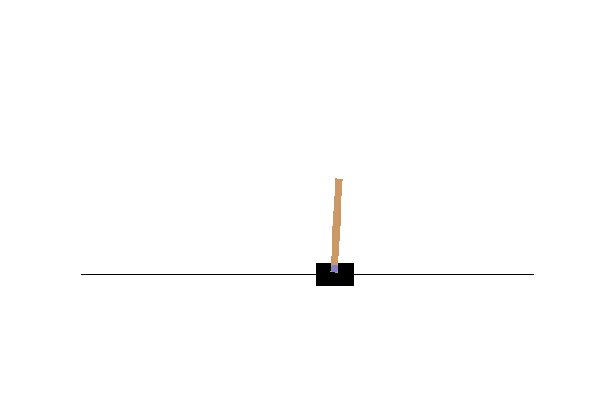
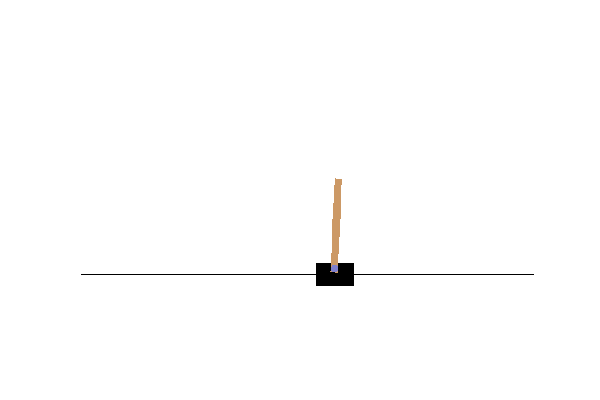
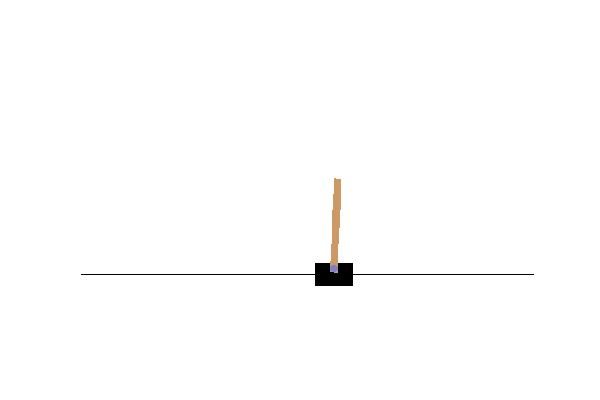
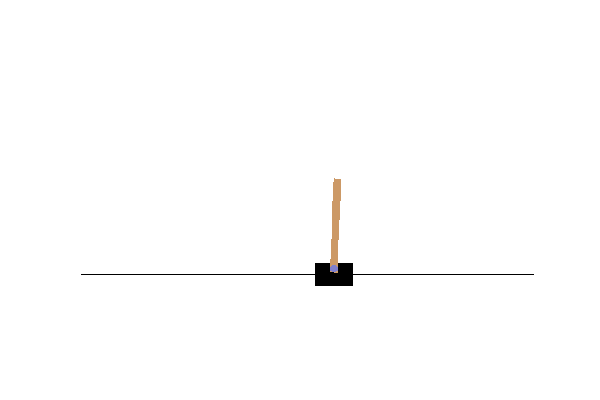
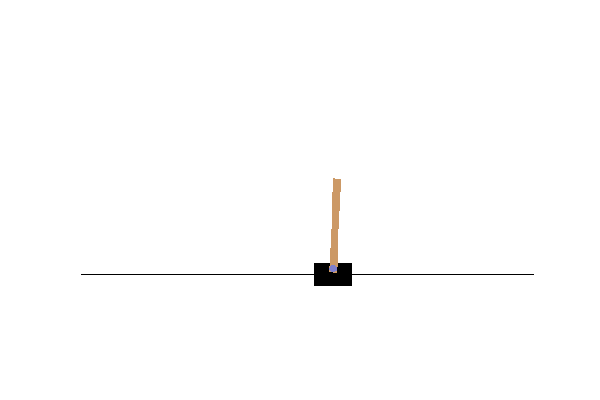
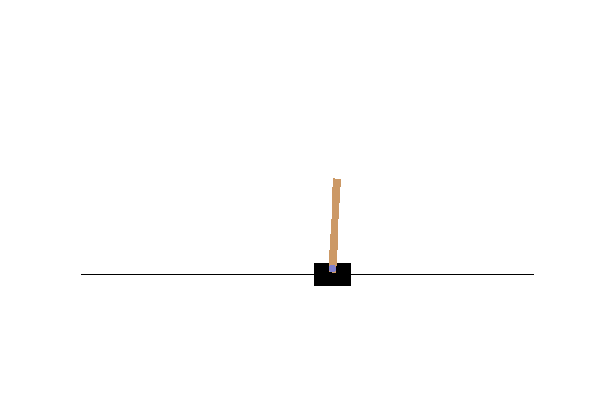

In [22]:
rewards = list(reward_queue_cartpole.queue)
t = list(range(len(rewards)))

avg_rewards = moving_average(rewards, n=100)
t_epochs = list(range(len(avg_rewards)))
plt.plot(t, rewards, label="Episodic")
plt.plot(t_epochs, avg_rewards, label="Moving Average ($n=100$)")
plt.legend()
plt.title("Rewards on CartPole")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.ylim([0, 200])
plt.show()

show_game(env_cartpole, policy_cartpole)